In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Чтобы графики были читаемыми
plt.rcParams["figure.figsize"] = (16, 9) #<- потом сие можно переопределить
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

## Определение функций $J(x, y)$ и их градиентов

In [13]:


def J1(x: np.ndarray) -> float:
    """J1(x, y) = x^2 + y^2"""
    return float(x[0]**2 + x[1]**2)


def grad_J1(x: np.ndarray) -> np.ndarray:
    """∇J1 = (2x, 2y)"""
    return np.array([2 * x[0], 2 * x[1]], dtype=float)


def make_J2(a: float = 5.0, b: float = 1.0):
    """
    J2(x, y) = x^2/a^2 + y^2/b^2
    a, b — большая и малая полуоси эллипса.
    """
    def J2(x: np.ndarray) -> float:
        return float(x[0]**2 / a**2 + x[1]**2 / b**2)

    def grad_J2(x: np.ndarray) -> np.ndarray:
        return np.array([2 * x[0] / a**2, 2 * x[1] / b**2], dtype=float)

    return J2, grad_J2


def J3(x: np.ndarray) -> float:
    """J3(x, y) = 70 (x-1)^2 + (y-1)^2 + 1"""
    return float(70 * (x[0] - 1)**2 + (x[1] - 1)**2 + 1)


def grad_J3(x: np.ndarray) -> np.ndarray:
    """∇J3 = (140 (x-1), 2 (y-1))"""
    return np.array([140 * (x[0] - 1), 2 * (x[1] - 1)], dtype=float)


def J4(x: np.ndarray) -> float:
    """
    J4(x, y) = (x-8)^2 + (y-1)^2 + 70 * (y + (x-8)^2 - 1)^2 + 1
    """
    u = x[0] - 8.0
    v = x[1] - 1.0
    return float(u**2 + v**2 + 70 * (v + u**2)**2 + 1)


def grad_J4(x: np.ndarray) -> np.ndarray:
    """
    ∇J4:
      обозначим u = x-8, v = y-1, w = v + u^2
      dJ/du = 2u + 280 u w
      dJ/dv = 2v + 140 w
    """
    u = x[0] - 8.0
    v = x[1] - 1.0
    w = v + u**2
    dJ_du = 2 * u + 280 * u * w
    dJ_dv = 2 * v + 140 * w
    return np.array([dJ_du, dJ_dv], dtype=float)


# фиксируем параметры для J2
a_ell = 5.0   # большая полуось
b_ell = 1.0   # малая полуось
J2, grad_J2 = make_J2(a=a_ell, b=b_ell)

## Сам градиентный спуск

In [14]:
def gradient_descent(
    func,
    grad,
    x0,
    step_mode: str = "constant",
    h0: float = 0.1,        # базовый шаг (для постоянного режима)
    c: float = 0.1,         # коэффициент для убывающих шагов
    power: float = 0.6,     # показатель степени в режиме "power"
    max_iters: int = 10000,
    tol_x: float = 1e-6,    # ||x_{k+1} - x_k||
    tol_f: float = 1e-6,    # |J_{k+1} - J_k|
    stop_by_x: bool = True,
    stop_by_f: bool = True,
):
    """
    Универсальный градиентный спуск.

    step_mode:
        - "constant": h_k = h0
        - "1_over_k": h_k = c / (k+1)
        - "power":    h_k = c * (1 + k)^(-power)
    """

    x = np.asarray(x0, dtype=float)
    xs = [x.copy()]
    fs = [func(x)]
    stop_reason = None

    for k in range(max_iters):
        g = grad(x)

        if step_mode == "constant":
            h = h0
        elif step_mode == "1_over_k":
            h = c / (k + 1)
        elif step_mode == "power":
            h = c * (1.0 + k) ** (-power)
        else:
            raise ValueError(f"Неизвестный режим шага: {step_mode}") #<- Шоб оно если что нормально упало и сказало почему

        x_new = x - h * g
        f_new = func(x_new)

        xs.append(x_new.copy())
        fs.append(f_new)

        dx_norm = np.linalg.norm(x_new - x)
        df_abs = abs(f_new - fs[-2])

        x = x_new

        # критерии остановки
        if stop_by_x and dx_norm < tol_x:
            stop_reason = f"tol_x: ||x_(k+1)-x_k|| = {dx_norm:.2e}"
            break
        if stop_by_f and df_abs < tol_f and k > 0:
            stop_reason = f"tol_f: |J_(k+1)-J_k| = {df_abs:.2e}"
            break

    if stop_reason is None:
        stop_reason = f"max_iters = {max_iters}"

    return {
        "x_path": np.array(xs),
        "f_path": np.array(fs),
        "stop_reason": stop_reason,
        "iters": len(xs) - 1,
    }

In [15]:


# Конфигурации для функций: начальная точка и шаги
FUNCTIONS = {
    "f1": {
        "func": J1,
        "grad": grad_J1,
        "title": r"$J_1(x, y) = x^2 + y^2$",
        "x0": np.array([5.0, 5.0]),
        # параметры шага
        "constant_h": 0.2,
        "power_c": 0.5,
        "power_alpha": 0.6,
    },
    "f2": {
        "func": J2,
        "grad": grad_J2,
        "title": rf"$J_2(x, y) = \frac{{x^2}}{{{a_ell}^2}} + \frac{{y^2}}{{{b_ell}^2}}$",
        "x0": np.array([5.0, 3.0]),
        "constant_h": 0.2,
        "power_c": 0.5,
        "power_alpha": 0.6,
    },
    "f3": {
        "func": J3,
        "grad": grad_J3,
        "title": r"$J_3(x, y) = 70(x-1)^2 + (y-1)^2 + 1$",
        "x0": np.array([-5.0, 5.0]),
        "constant_h": 0.01,
        "power_c": 0.5,
        "power_alpha": 0.9,
    },
    "f4": {
        "func": J4,
        "grad": grad_J4,
        "title": r"$J_4(x, y) = (x-8)^2 + (y-1)^2 + 70(y + (x-8)^2 - 1)^2 + 1$",
        "x0": np.array([8.0, 3.0]),
        "constant_h": 0.001,
        "power_c": 0.05,
        "power_alpha": 0.9,
    },
}

# какие режимы шага будем реально рисовать в отчёте
STEP_MODES_FOR_REPORT = ["constant", "power"]

# отдельный пример режима 1/(k+1) на простой функции J1
ONE_OVER_K_DEMO = {
    "enabled": True,
    "func_key": "f1",
    "c": 0.5,  # h_k = 0.5 / (k+1)
}

## Строилка графиков

In [16]:


def plot_trajectory(xs: np.ndarray, title: str, filename: str):
    """
    График траектории x_k = (x_k, y_k) на плоскости.
    """
    plt.figure()
    plt.plot(xs[:, 0], xs[:, 1], marker="o", linestyle="-")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()


def plot_J_values(fs: np.ndarray, title: str, filename: str):
    """
    График J(x_k) по итерациям.
    """
    k = np.arange(len(fs))
    plt.figure()
    plt.plot(k, fs, marker="o", linestyle="-")
    plt.xlabel("итерация k")
    plt.ylabel("J(x_k)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

In [17]:
results = {}

for key, cfg in FUNCTIONS.items():
    func = cfg["func"]
    grad = cfg["grad"]
    x0 = cfg["x0"]

    for mode in STEP_MODES_FOR_REPORT:
        if mode == "constant":
            h0 = cfg["constant_h"]
            res = gradient_descent(
                func=func,
                grad=grad,
                x0=x0,
                step_mode="constant",
                h0=h0,
                max_iters=20000,
                tol_x=1e-6,
                tol_f=1e-6,
                stop_by_x=True,
                stop_by_f=True,
            )
            step_descr = f"постоянный шаг h = {h0}"
            suffix = "constant"

        elif mode == "power":
            c = cfg["power_c"]
            alpha = cfg["power_alpha"]
            res = gradient_descent(
                func=func,
                grad=grad,
                x0=x0,
                step_mode="power",
                c=c,
                power=alpha,
                max_iters=20000,
                tol_x=1e-6,
                tol_f=1e-6,
                stop_by_x=True,
                stop_by_f=True,
            )
            step_descr = rf"$h_k = {c} (1 + k)^{{-{alpha}}}$"
            suffix = "power"

        else:
            continue

        xs = res["x_path"]
        fs = res["f_path"]

        # имена файлов строго фиксируем под отчёт
        traj_filename = f"{key}_traj_{suffix}.png"
        J_filename = f"{key}_J_{suffix}.png"

        # графики
        plot_trajectory(
            xs,
            title=f"Траектория для {cfg['title']} ({step_descr})",
            filename=traj_filename,
        )

        plot_J_values(
            fs,
            title=f"Убывание J(x_k) для {cfg['title']} ({step_descr})",
            filename=J_filename,
        )

        # сохраняем результат в словарь
        results[(key, suffix)] = {
            "traj_file": traj_filename,
            "J_file": J_filename,
            "x_star": xs[-1],
            "J_star": fs[-1],
            "iters": res["iters"],
            "stop_reason": res["stop_reason"],
            "step_descr": step_descr,
        }

# Дополнительно: пример режима h_k = c / (k+1) для J1
if ONE_OVER_K_DEMO["enabled"]:
    key = ONE_OVER_K_DEMO["func_key"]
    cfg = FUNCTIONS[key]
    c_demo = ONE_OVER_K_DEMO["c"]

    res_demo = gradient_descent(
        func=cfg["func"],
        grad=cfg["grad"],
        x0=cfg["x0"],
        step_mode="1_over_k",
        c=c_demo,
        max_iters=20_000,
        tol_x=1e-6,
        tol_f=1e-6,
        stop_by_x=True,
        stop_by_f=True,
    )

    xs_demo = res_demo["x_path"]
    fs_demo = res_demo["f_path"]

    traj_filename = f"{key}_traj_1_over_k.png"
    J_filename = f"{key}_J_1_over_k.png"

    plot_trajectory(
        xs_demo,
        title=f"Траектория для {cfg['title']} (h_k = {c_demo}/(k+1))",
        filename=traj_filename,
    )

    plot_J_values(
        fs_demo,
        title=f"Убывание J(x_k) для {cfg['title']} (h_k = {c_demo}/(k+1))",
        filename=J_filename,
    )

    results[(key, "1_over_k")] = {
        "traj_file": traj_filename,
        "J_file": J_filename,
        "x_star": xs_demo[-1],
        "J_star": fs_demo[-1],
        "iters": res_demo["iters"],
        "stop_reason": res_demo["stop_reason"],
        "step_descr": f"h_k = {c_demo} / (k+1)",
    }

## Сводка
Добавлена отдельно, чтобы не перезапускать весь код, тк при живом сервере все массивы сохраняются

Функция f1, режим шага: constant
  шаг: постоянный шаг h = 0.2
  x* = [0.0005078 0.0005078]
  J(x*) = 0.00000052
  число итераций: 18
  причина остановки: tol_f: |J_(k+1)-J_k| = 9.17e-07
  файлы графиков: f1_traj_constant.png, f1_J_constant.png
  Траектория:


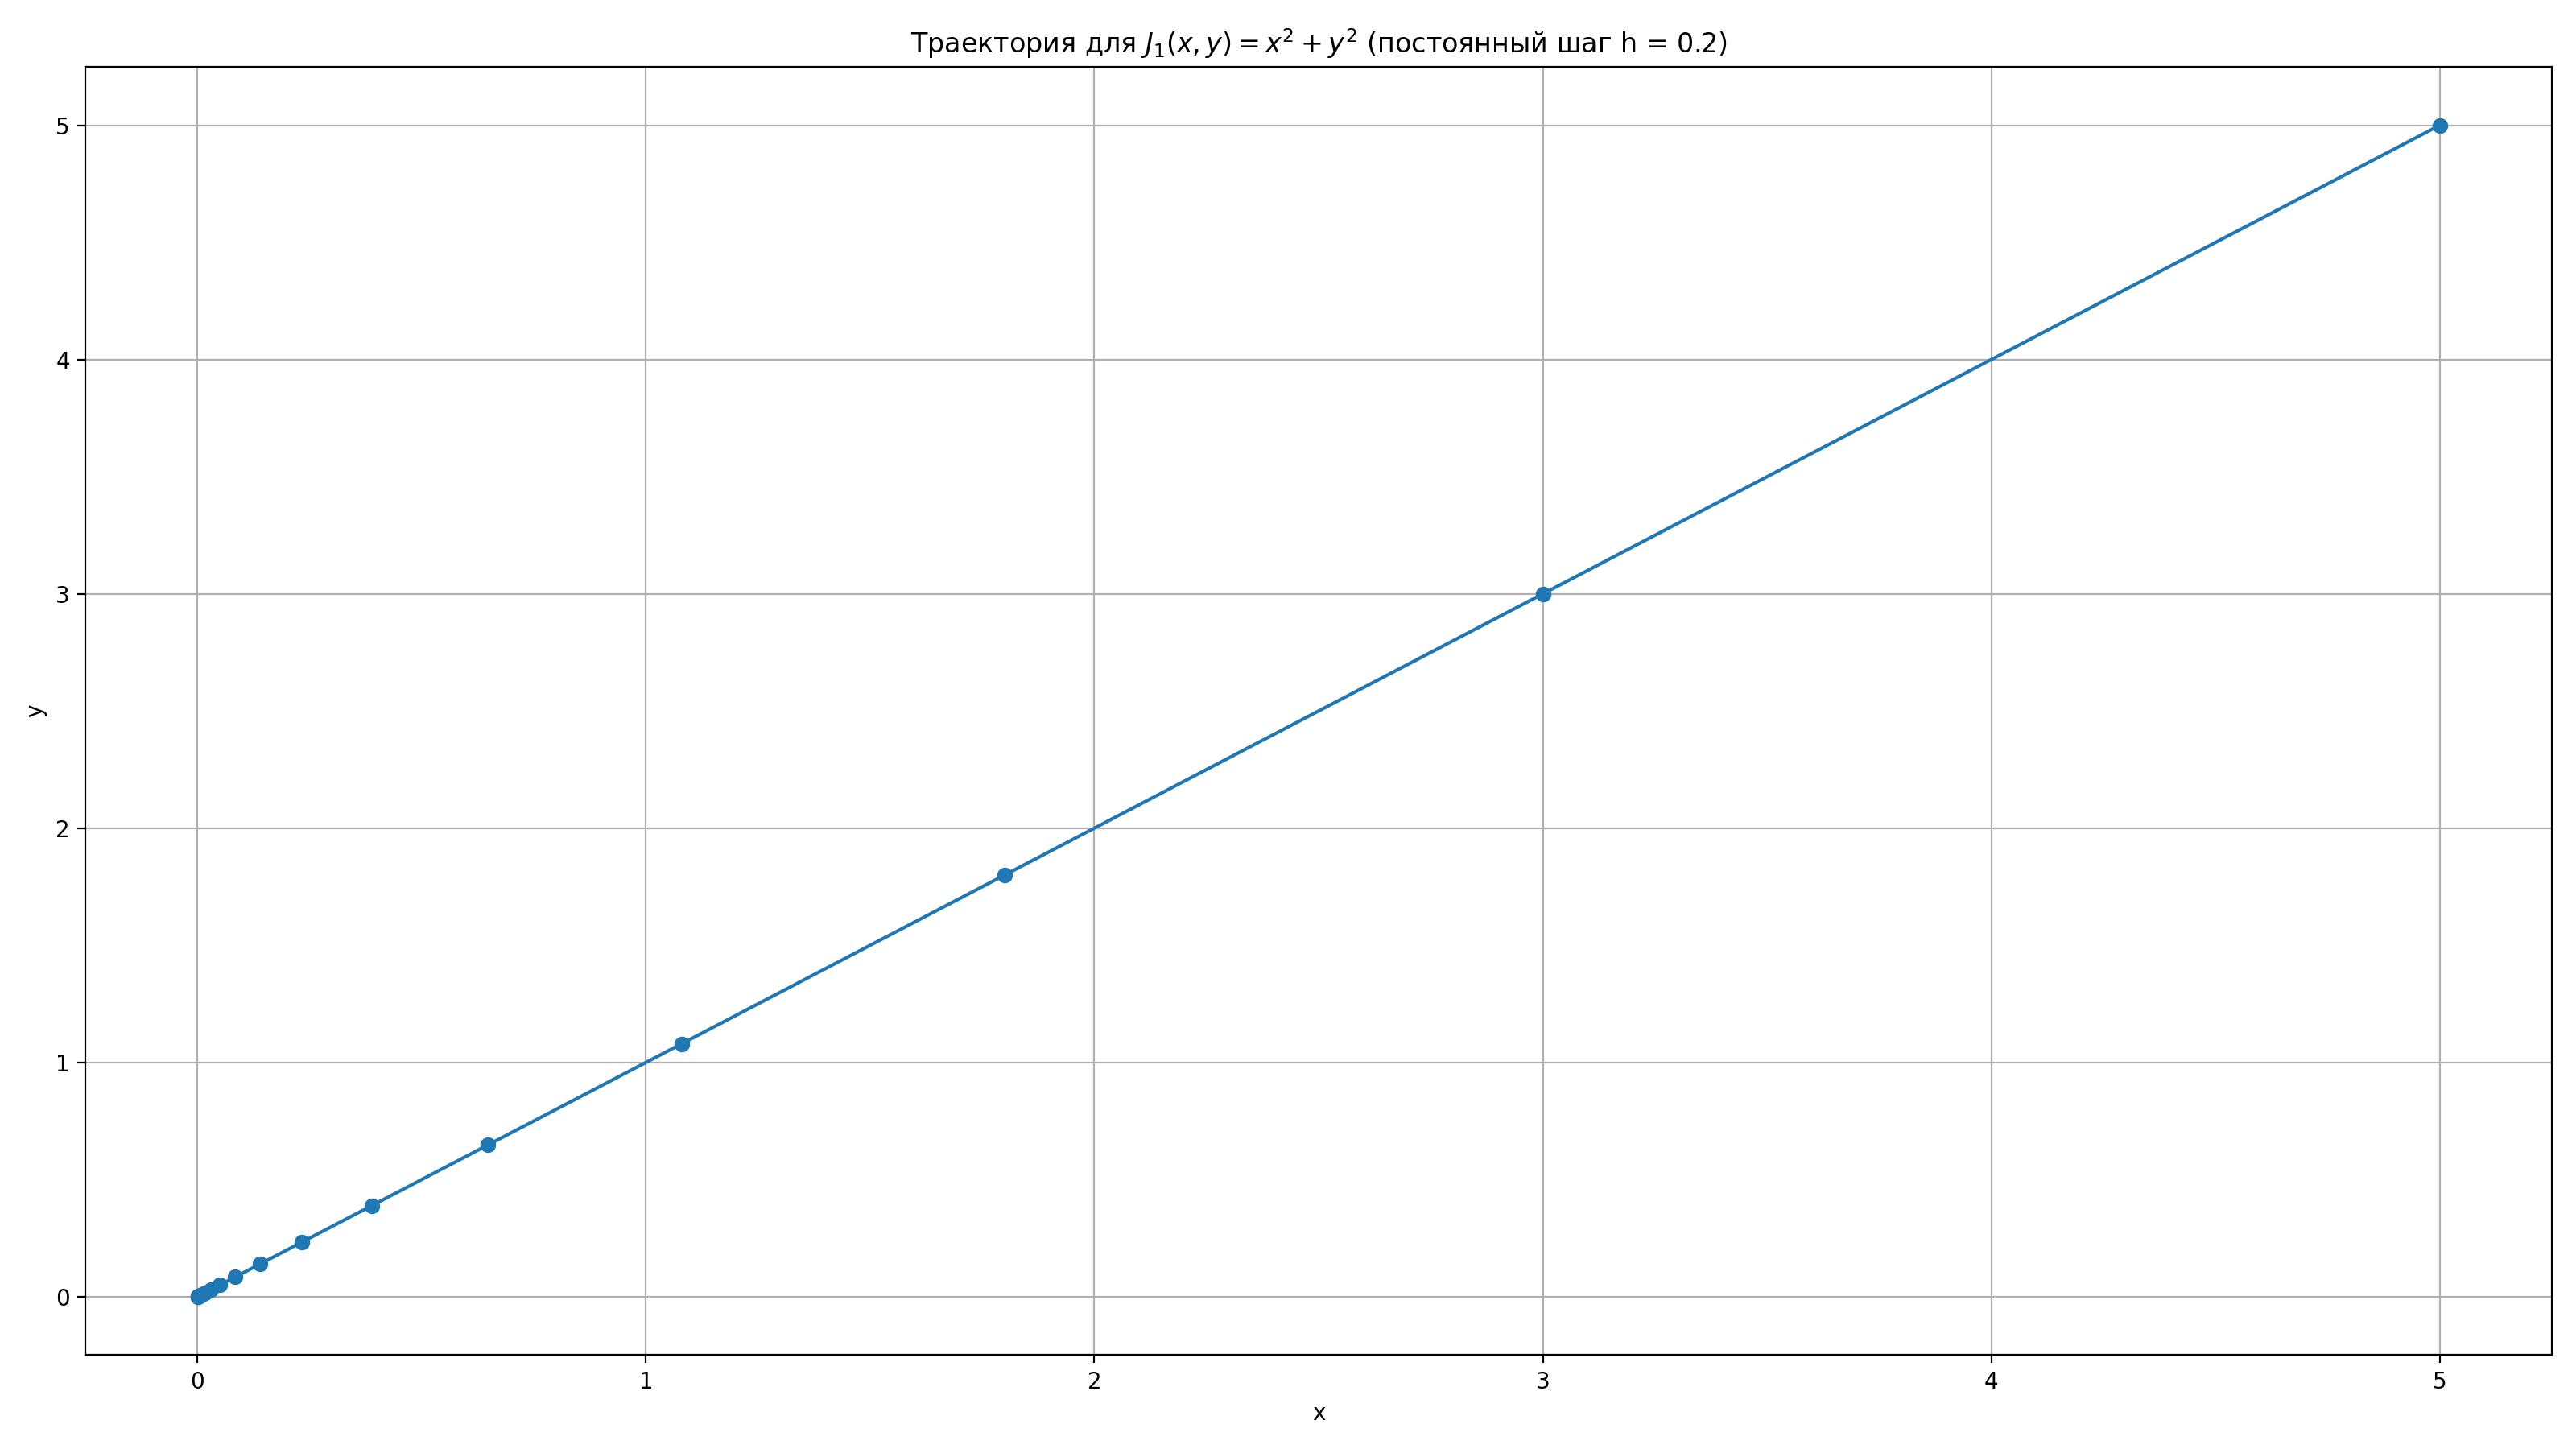

  Значение J(x_k):


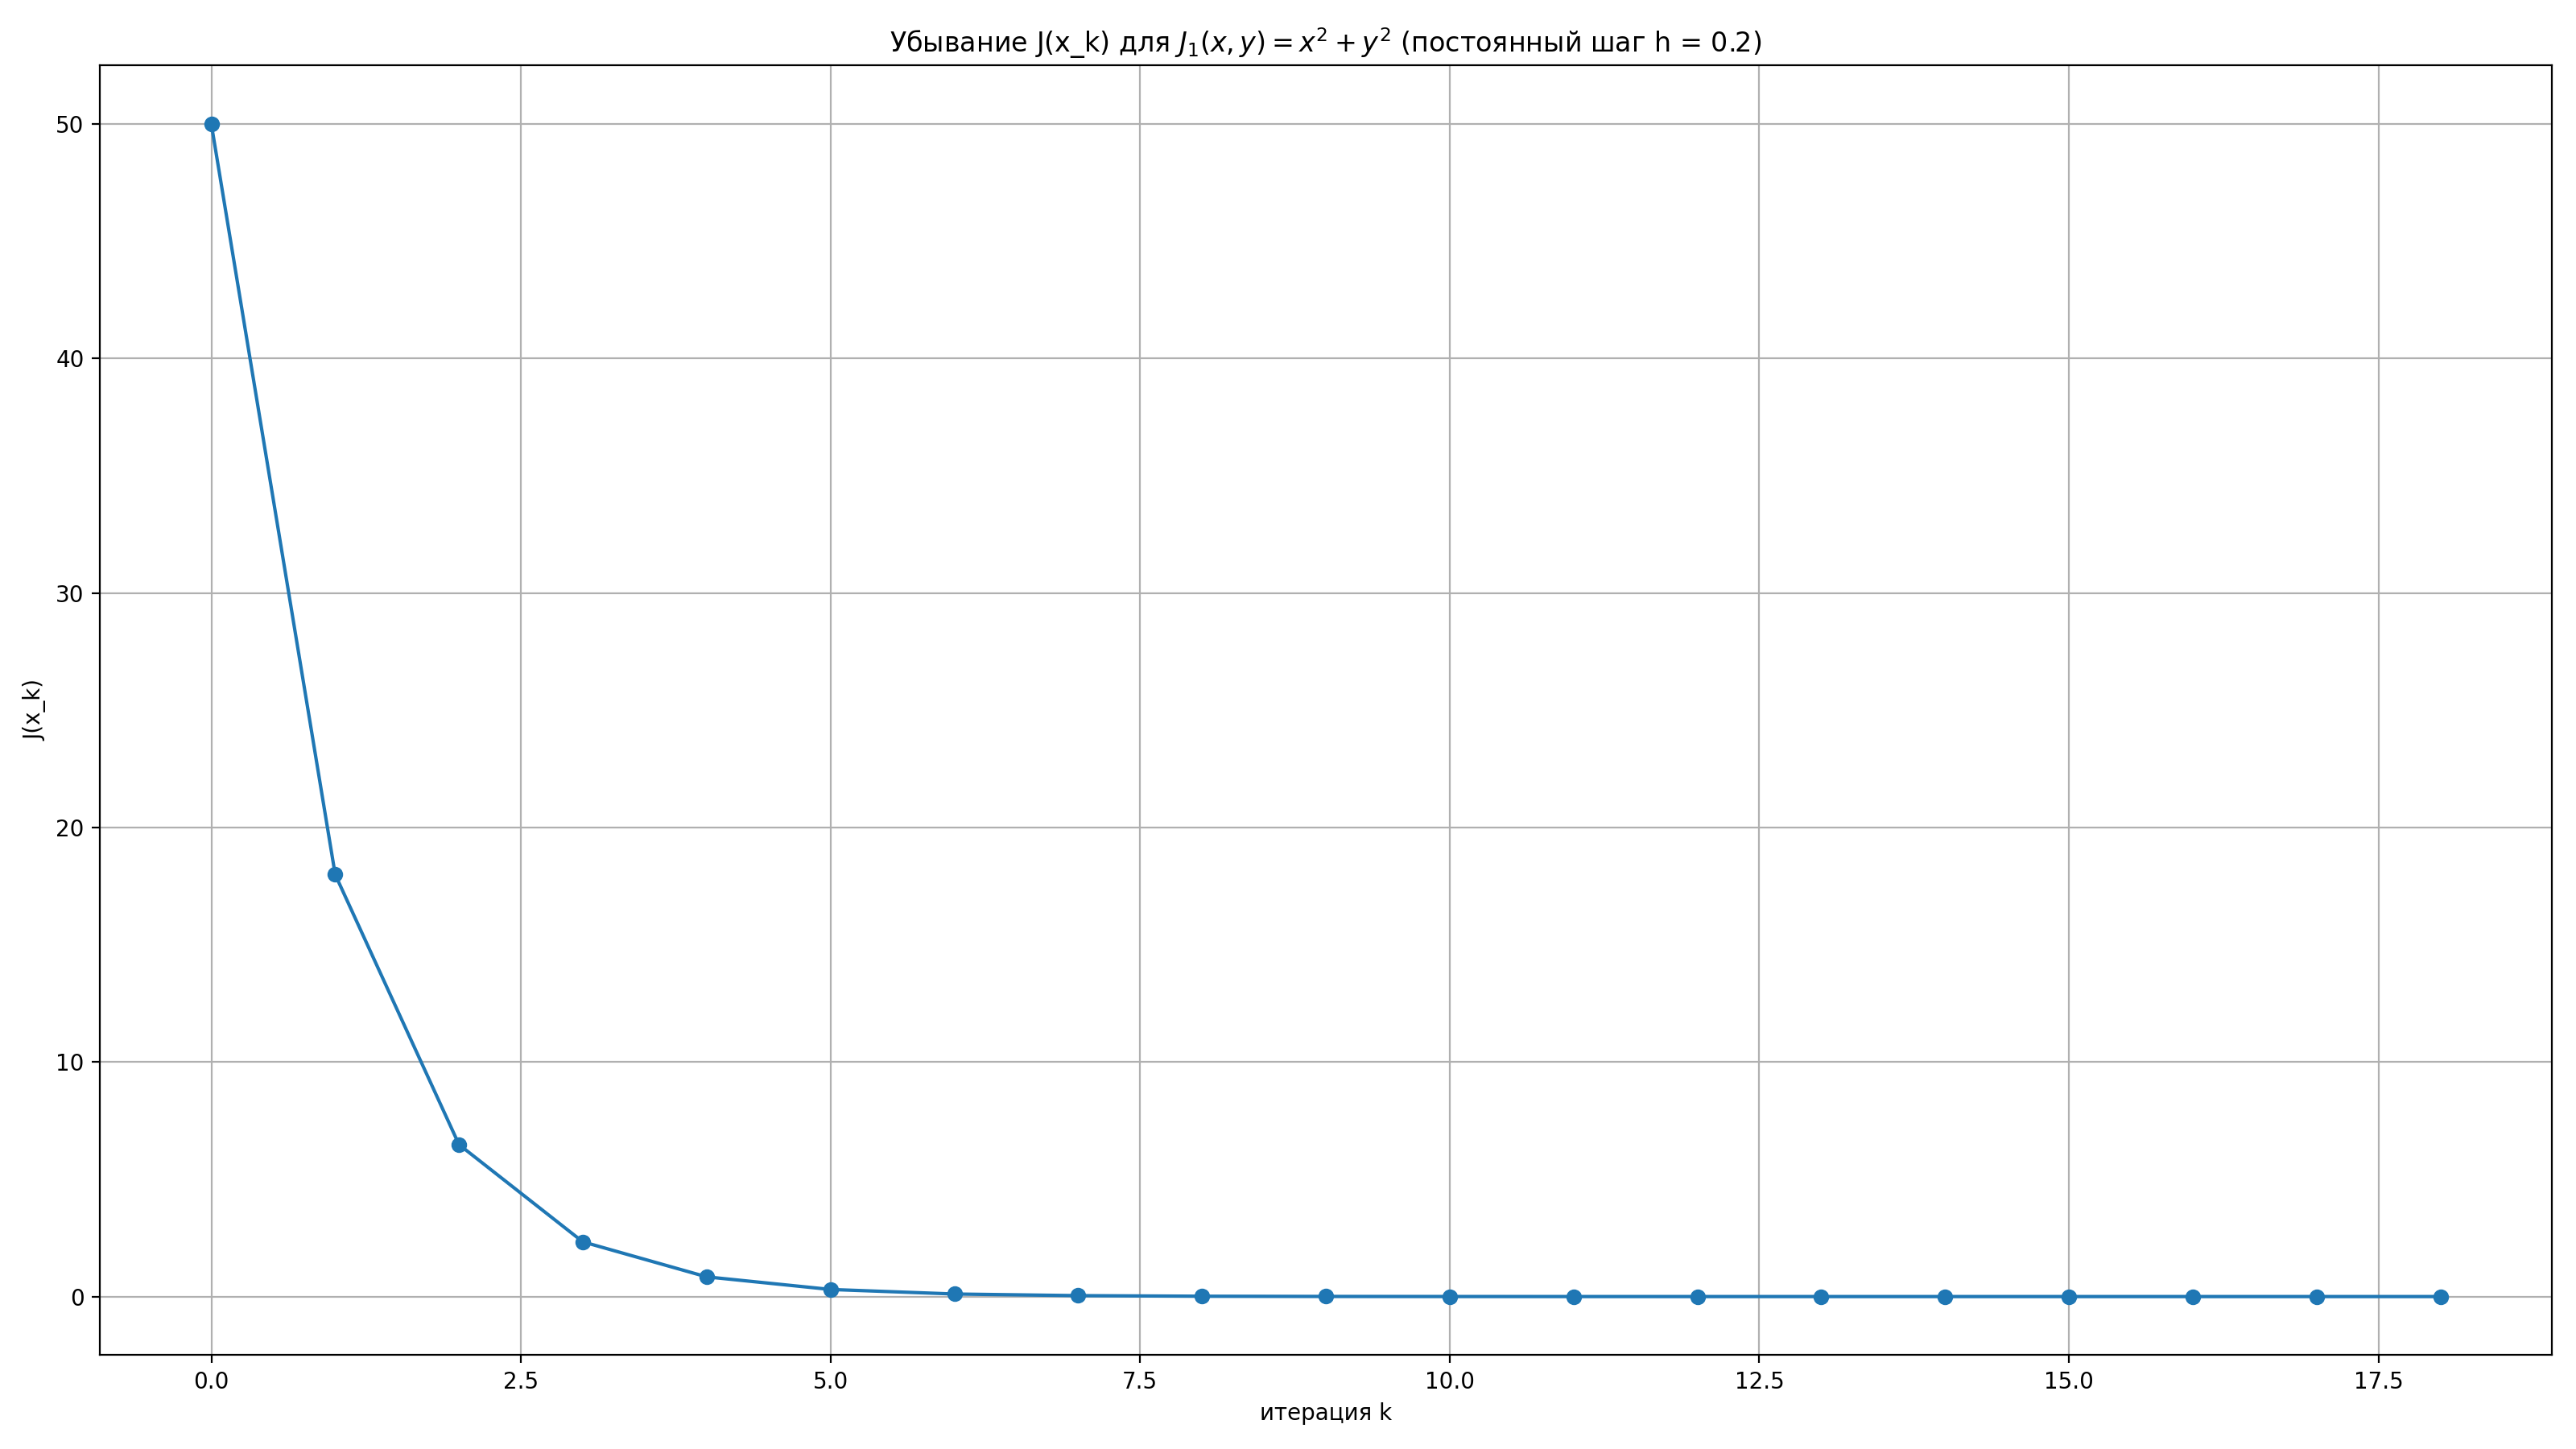

------------------------------------------------------------
Функция f1, режим шага: power
  шаг: $h_k = 0.5 (1 + k)^{-0.6}$
  x* = [0. 0.]
  J(x*) = 0.00000000
  число итераций: 2
  причина остановки: tol_x: ||x_(k+1)-x_k|| = 0.00e+00
  файлы графиков: f1_traj_power.png, f1_J_power.png
  Траектория:


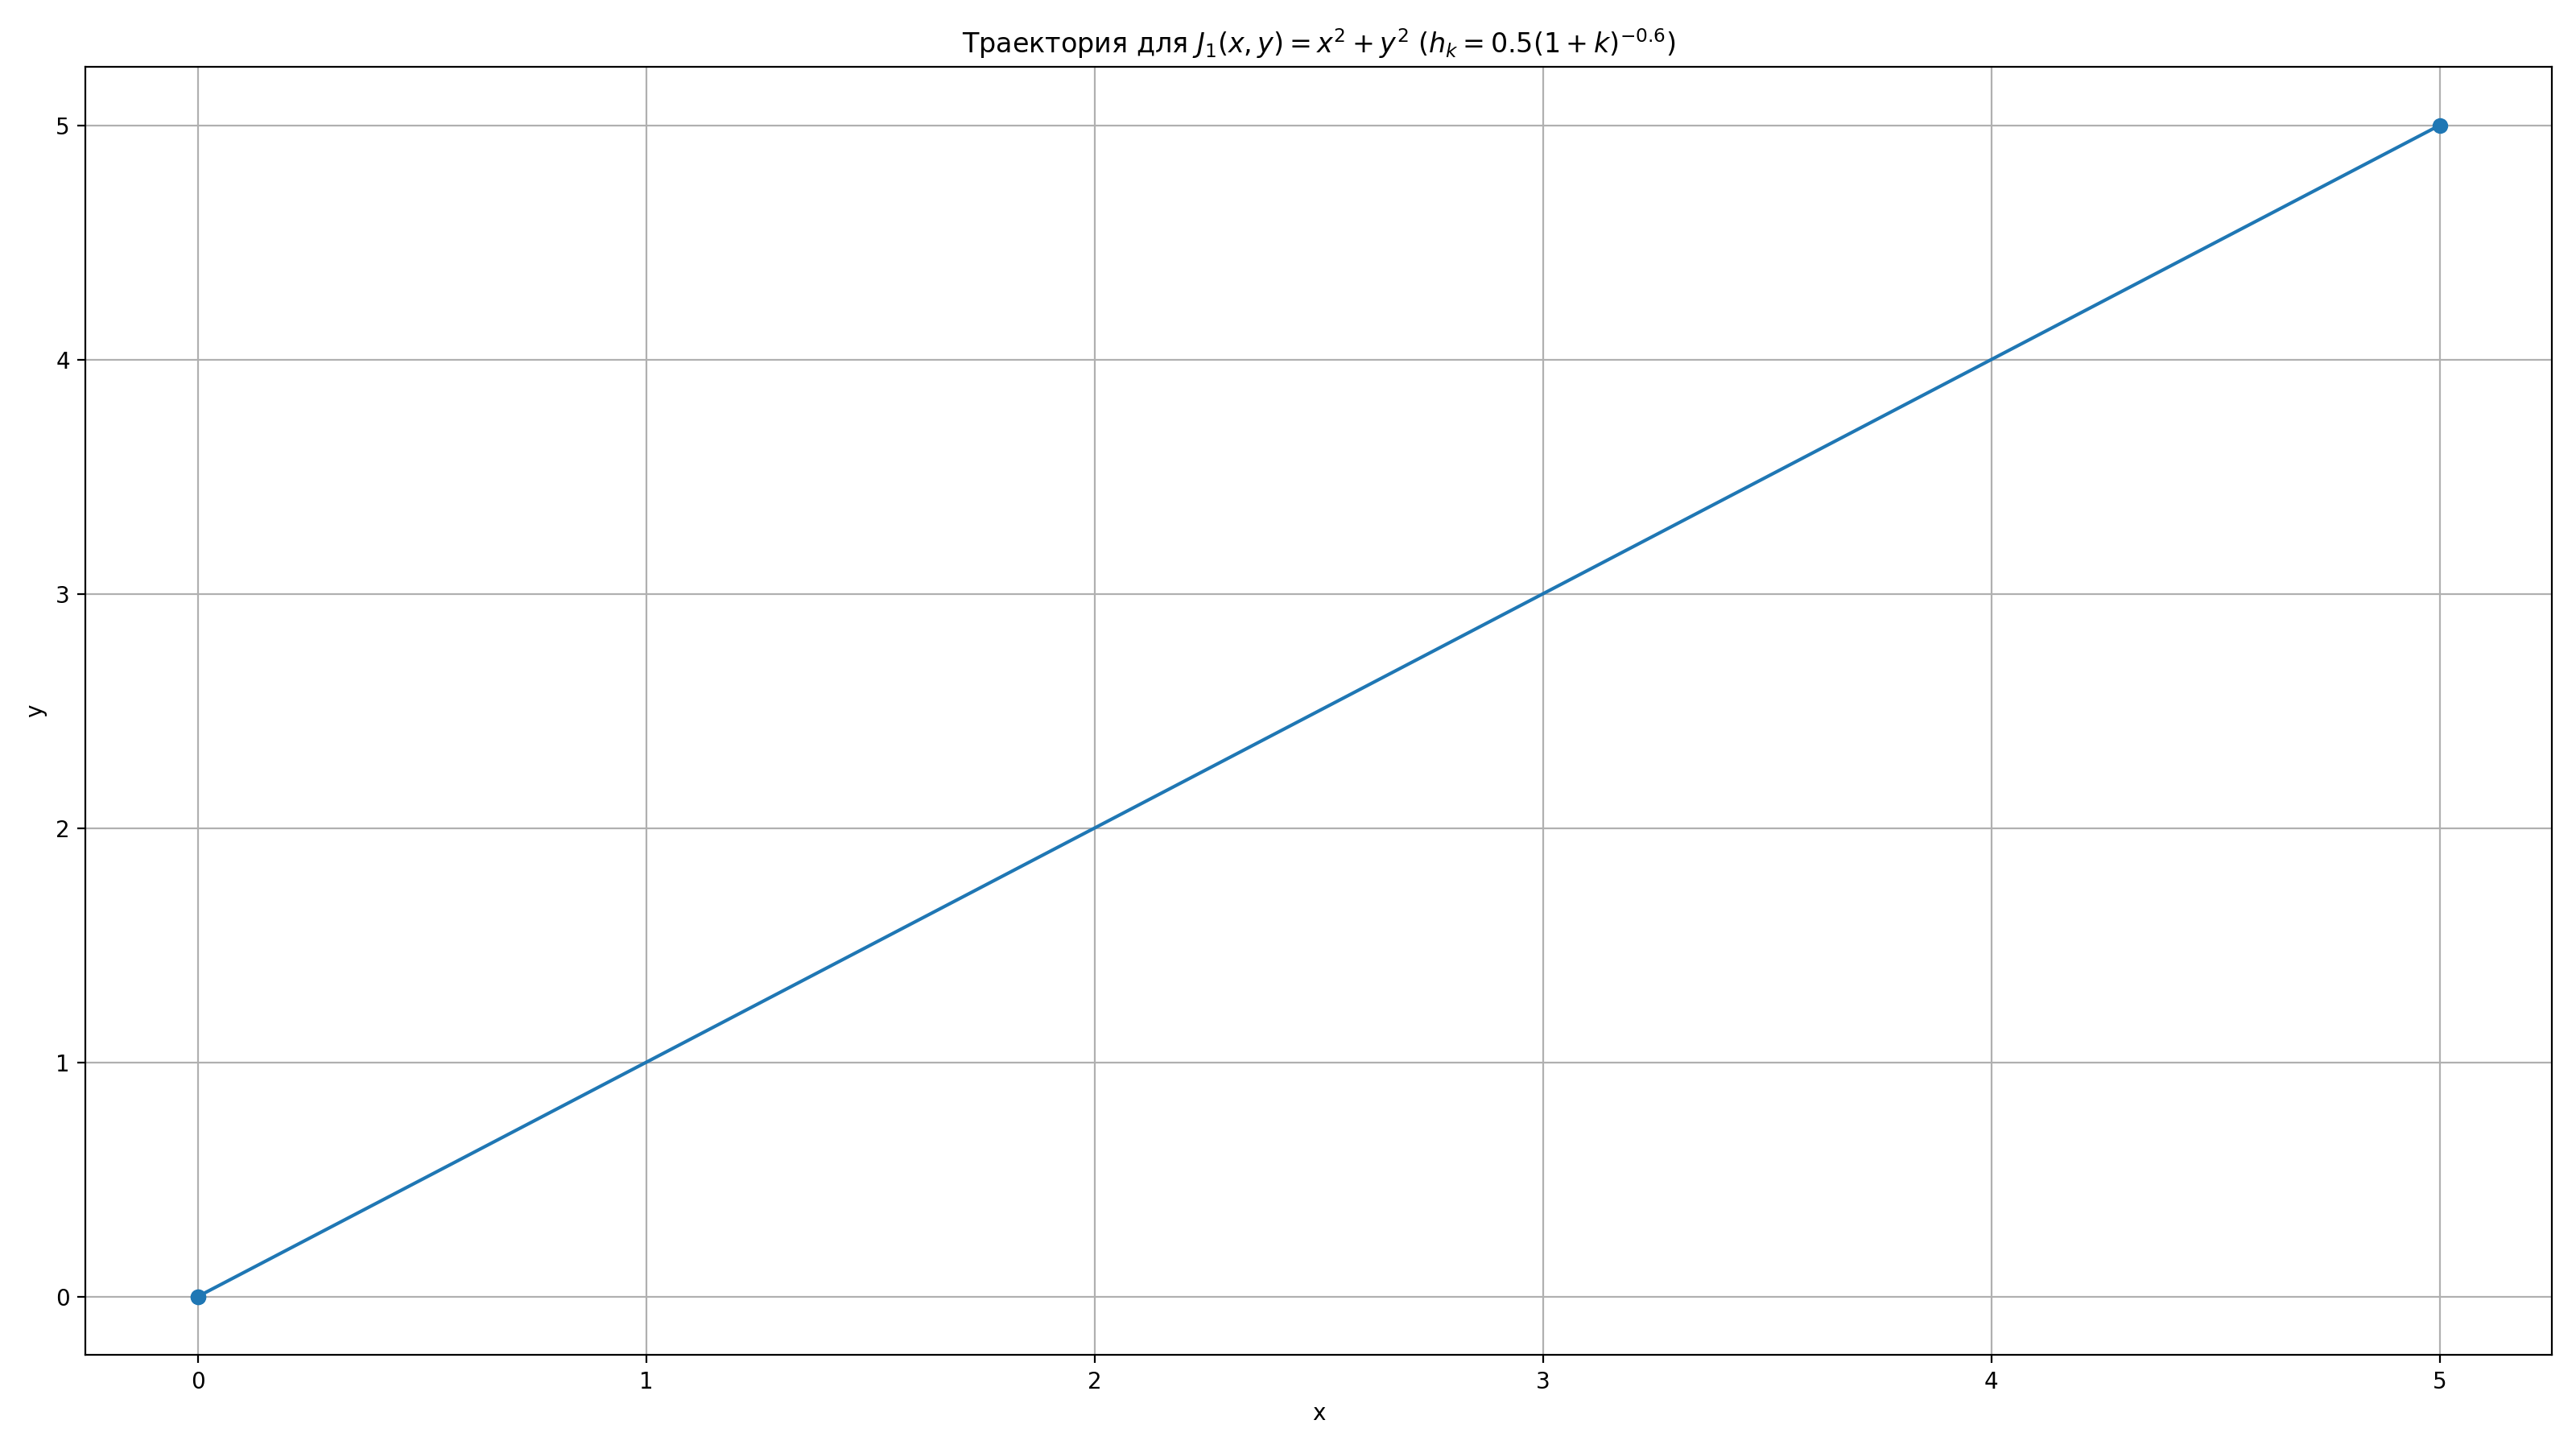

  Значение J(x_k):


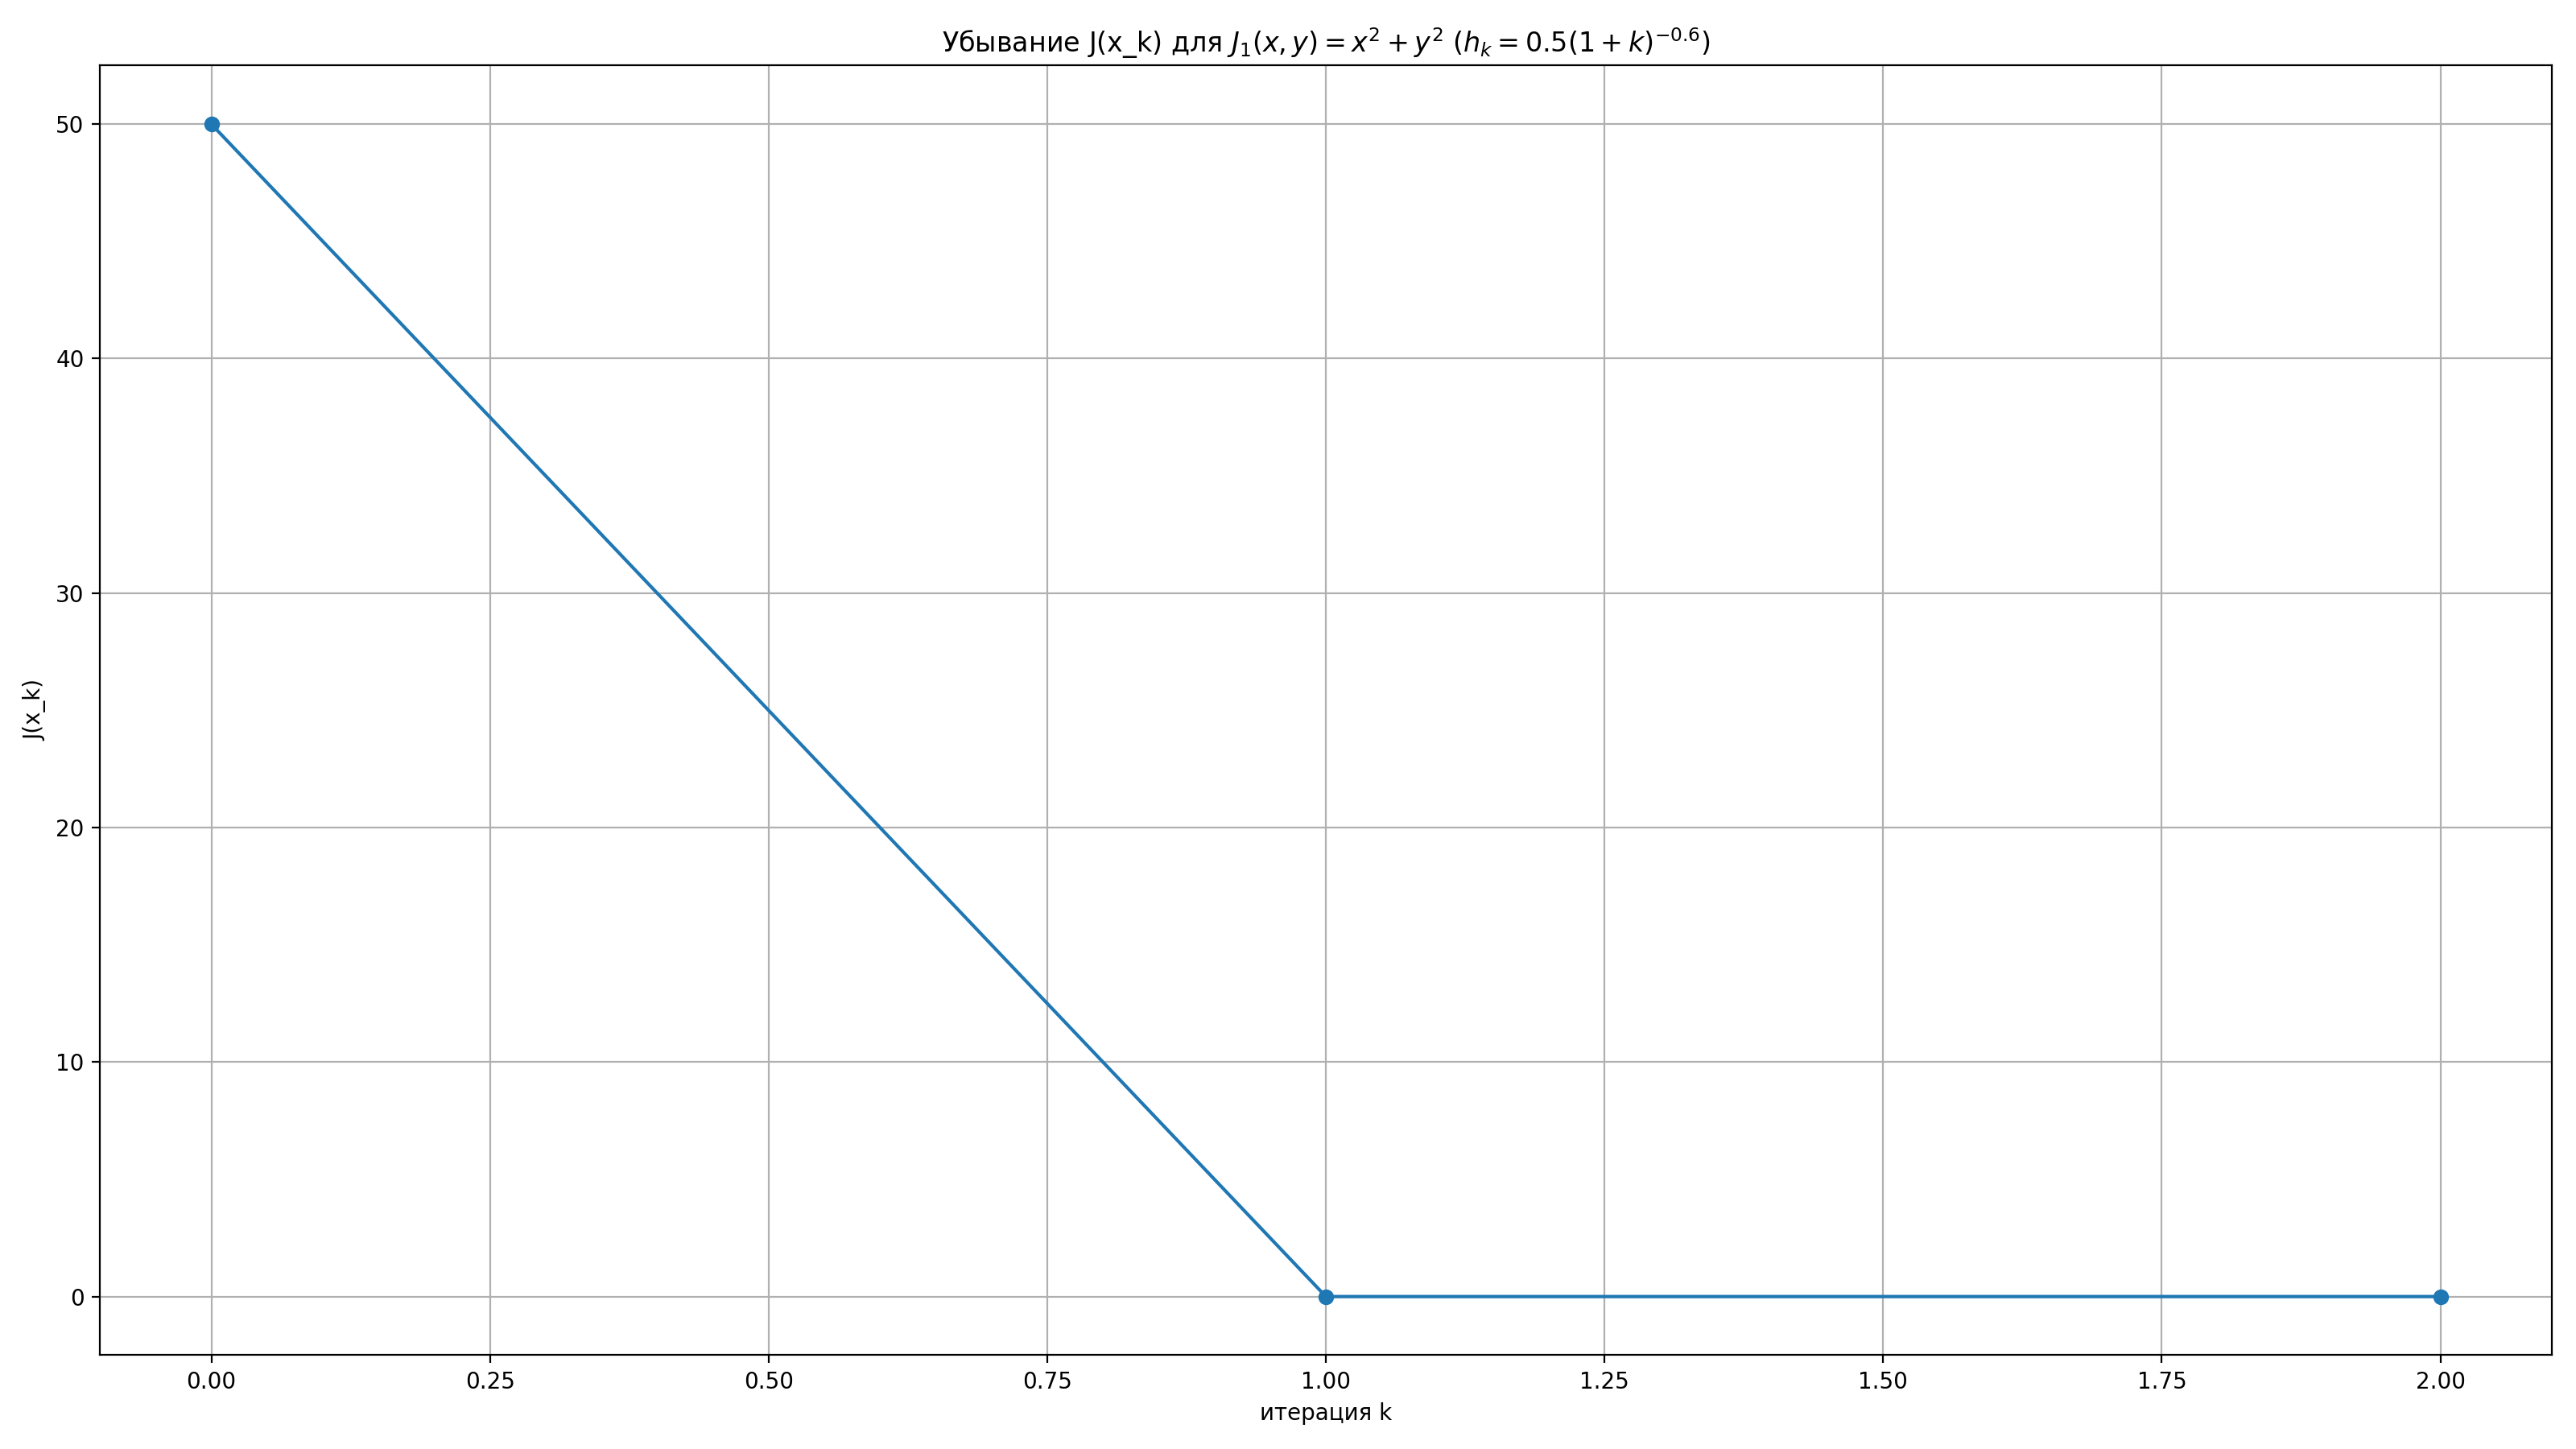

------------------------------------------------------------
Функция f2, режим шага: constant
  шаг: постоянный шаг h = 0.2
  x* = [2.73140939e-02 6.60655612e-72]
  J(x*) = 0.00002984
  число итераций: 323
  причина остановки: tol_f: |J_(k+1)-J_k| = 9.78e-07
  файлы графиков: f2_traj_constant.png, f2_J_constant.png
  Траектория:


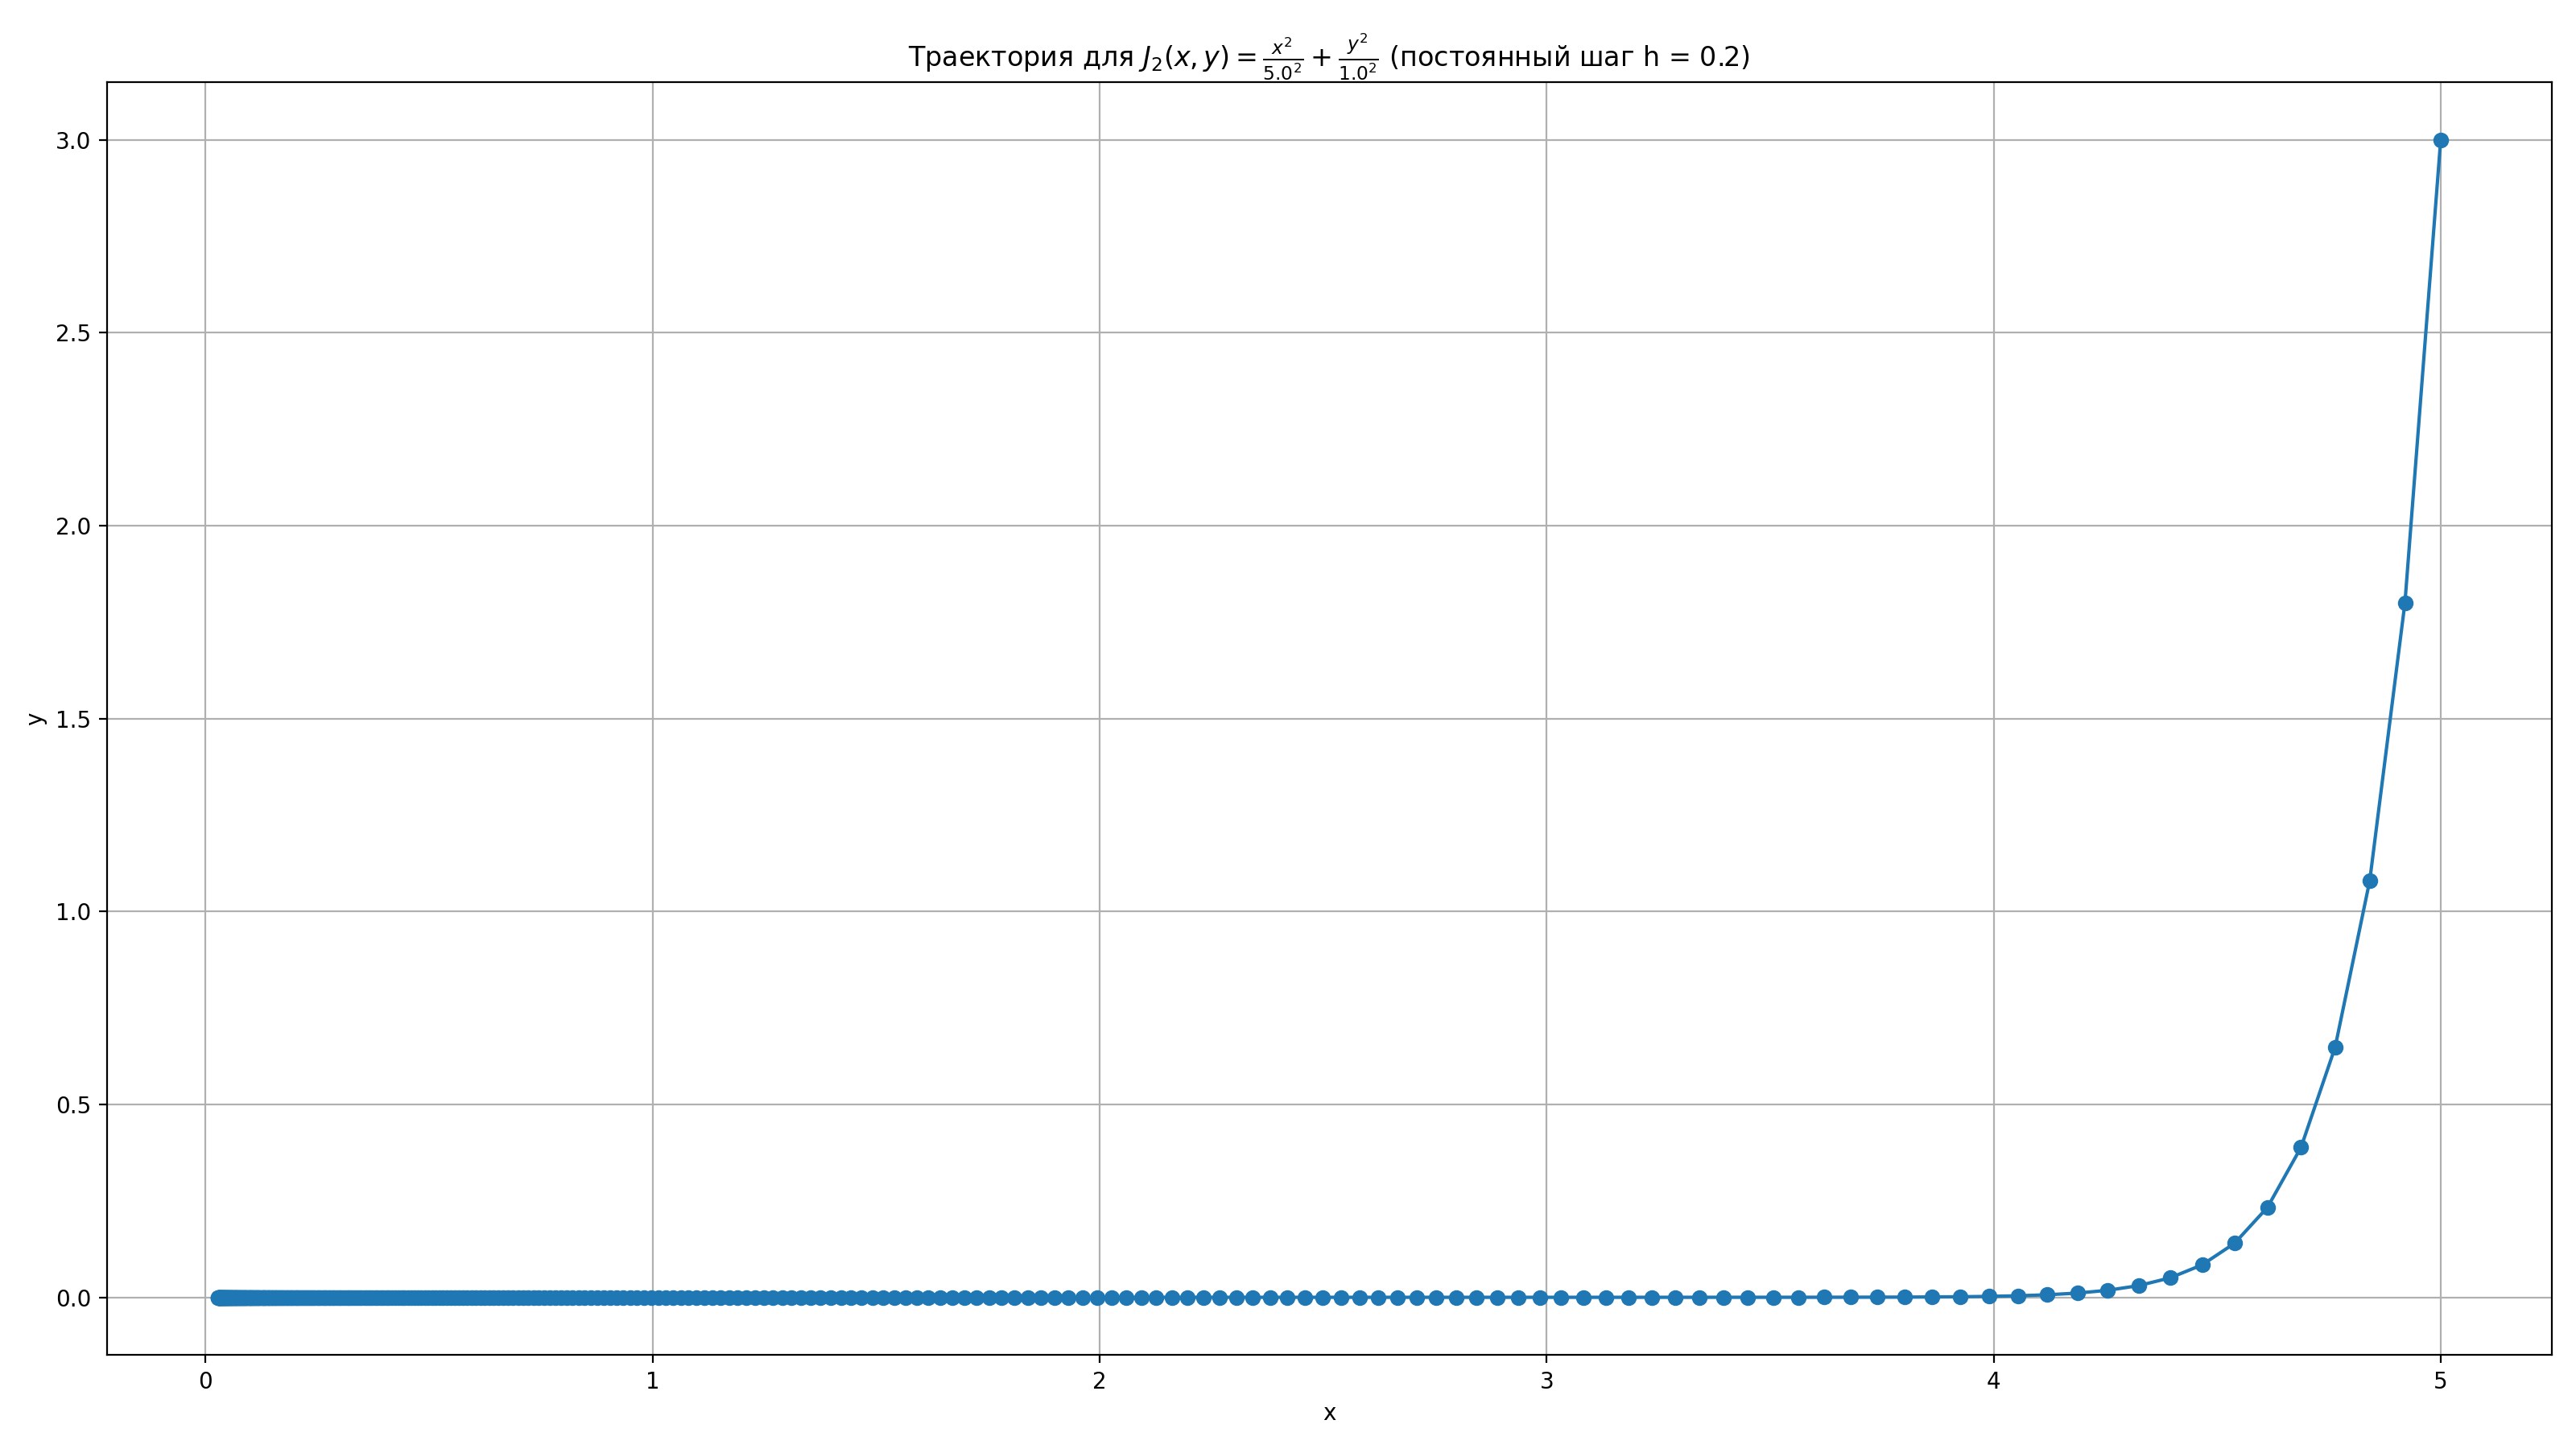

  Значение J(x_k):


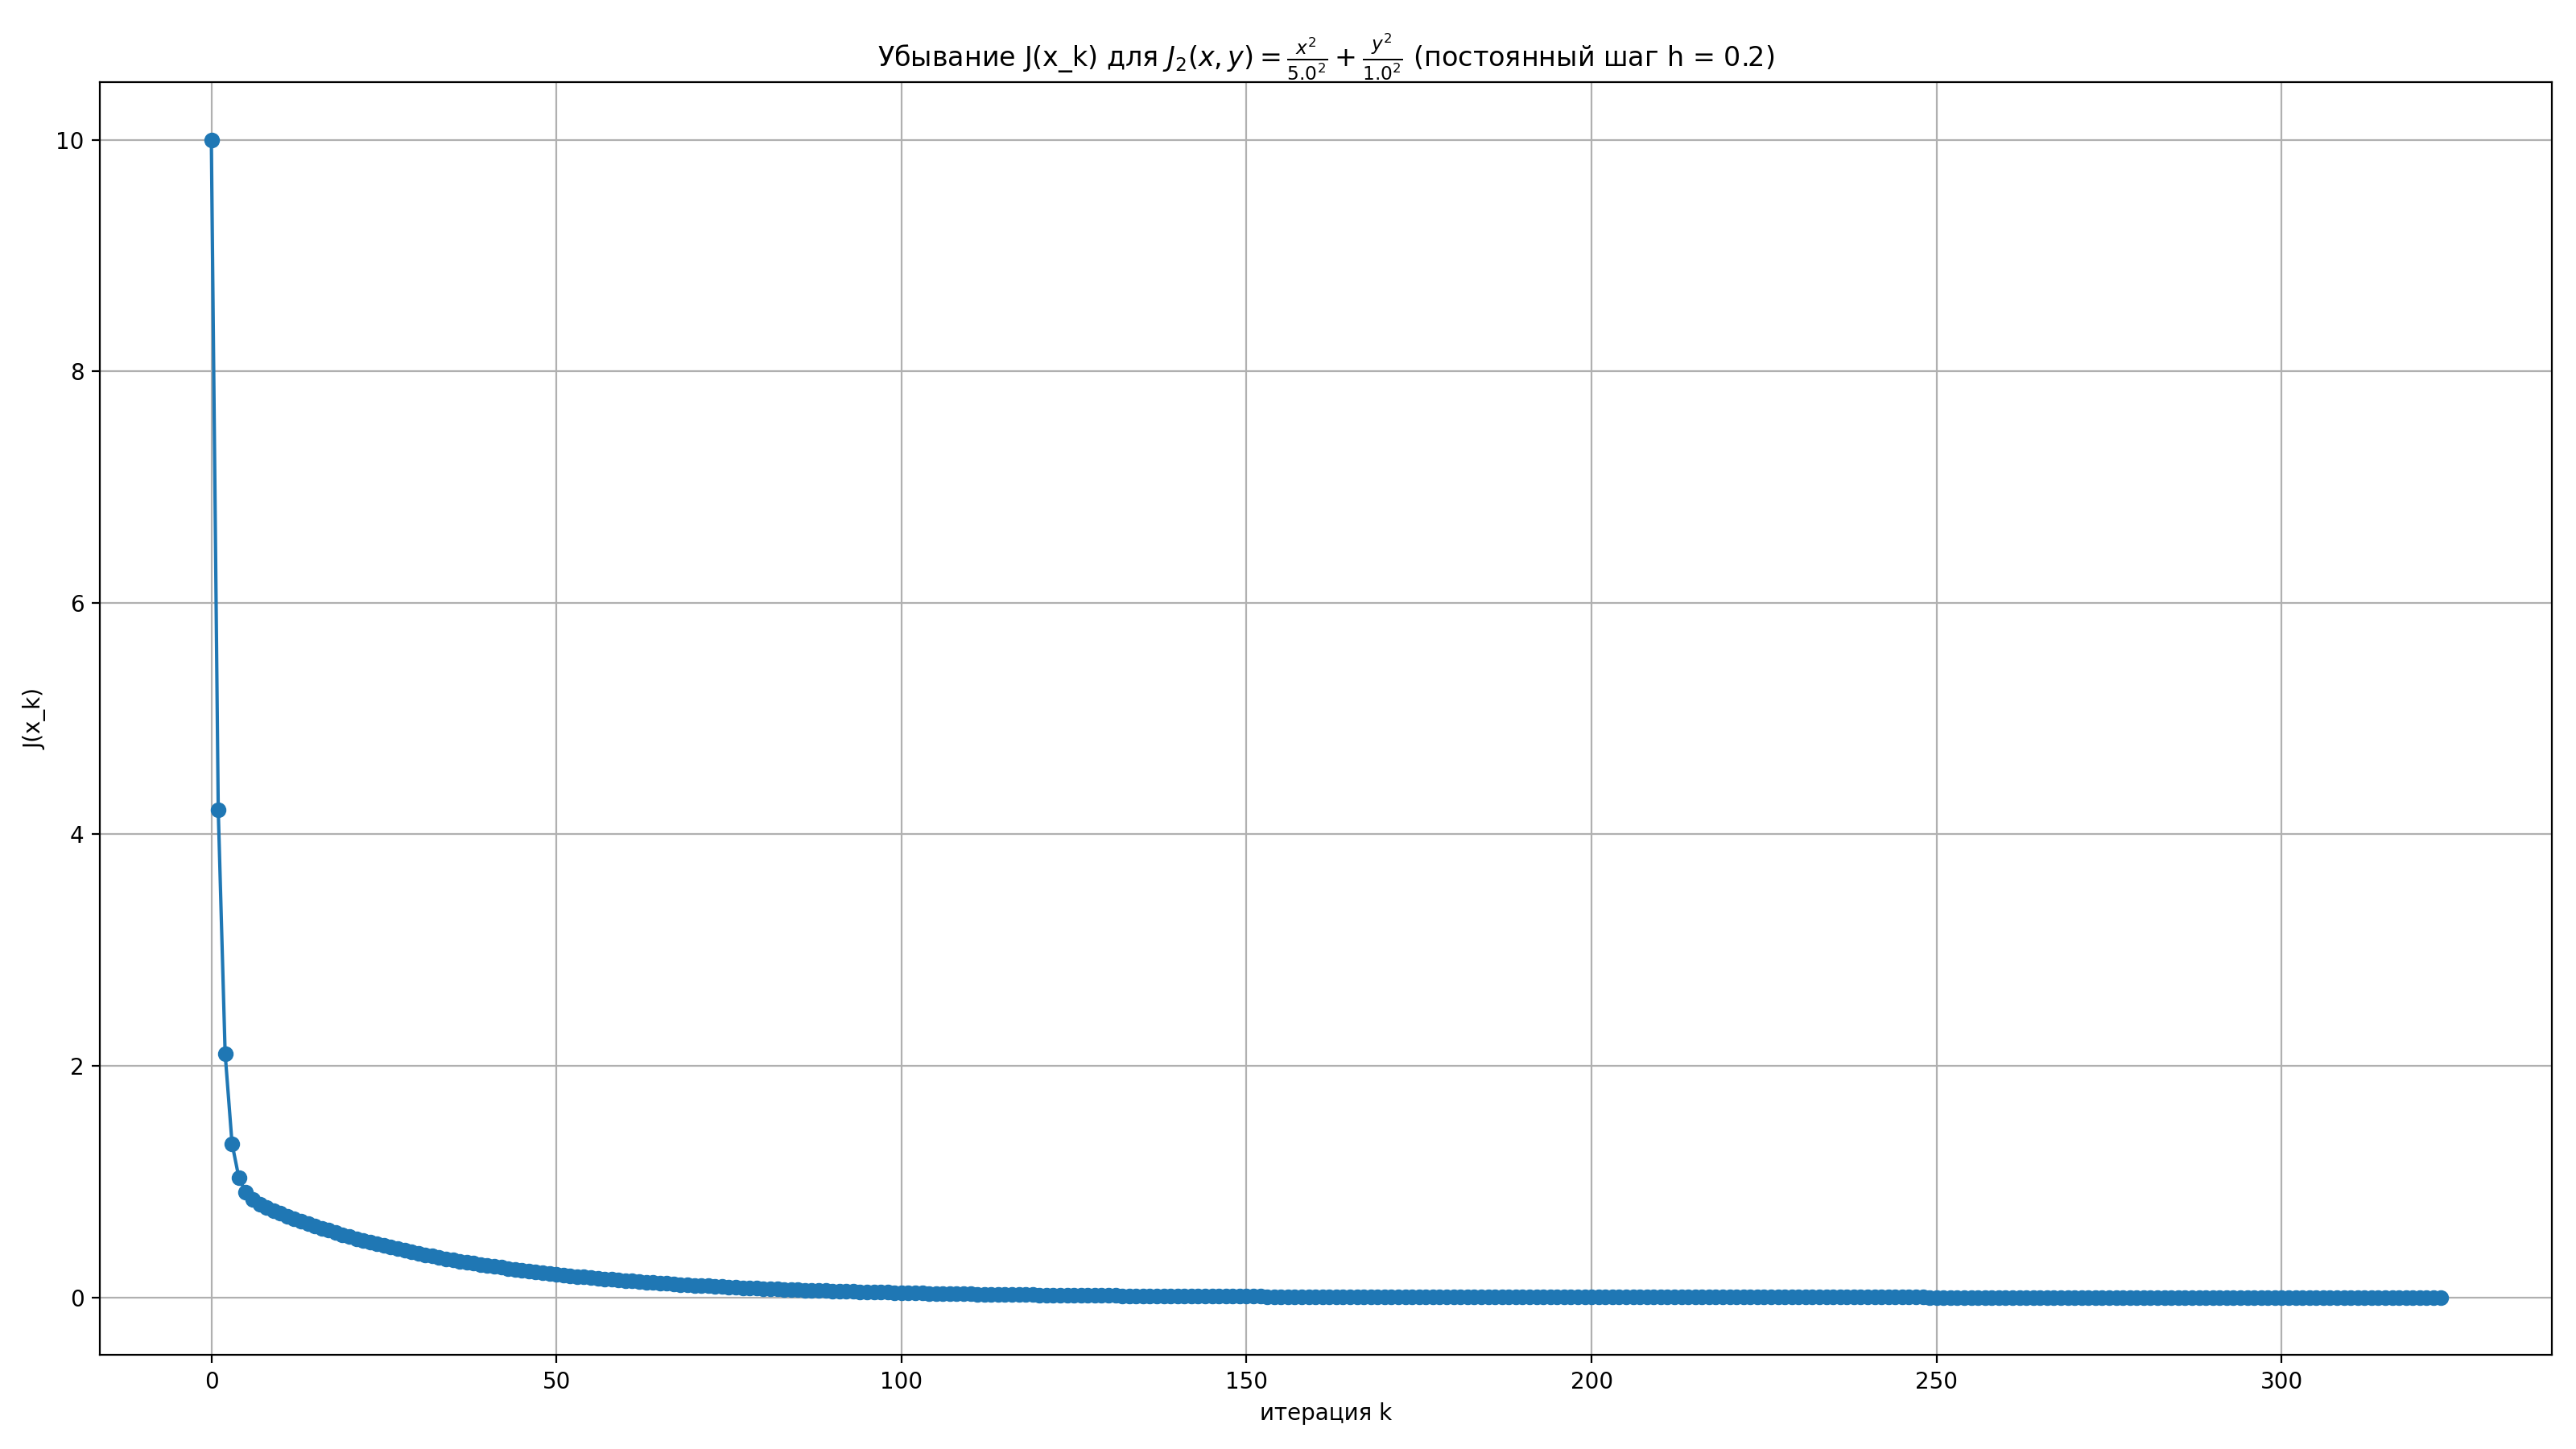

------------------------------------------------------------
Функция f2, режим шага: power
  шаг: $h_k = 0.5 (1 + k)^{-0.6}$
  x* = [0.23413872 0.        ]
  J(x*) = 0.00219284
  число итераций: 5505
  причина остановки: tol_f: |J_(k+1)-J_k| = 1.00e-06
  файлы графиков: f2_traj_power.png, f2_J_power.png
  Траектория:


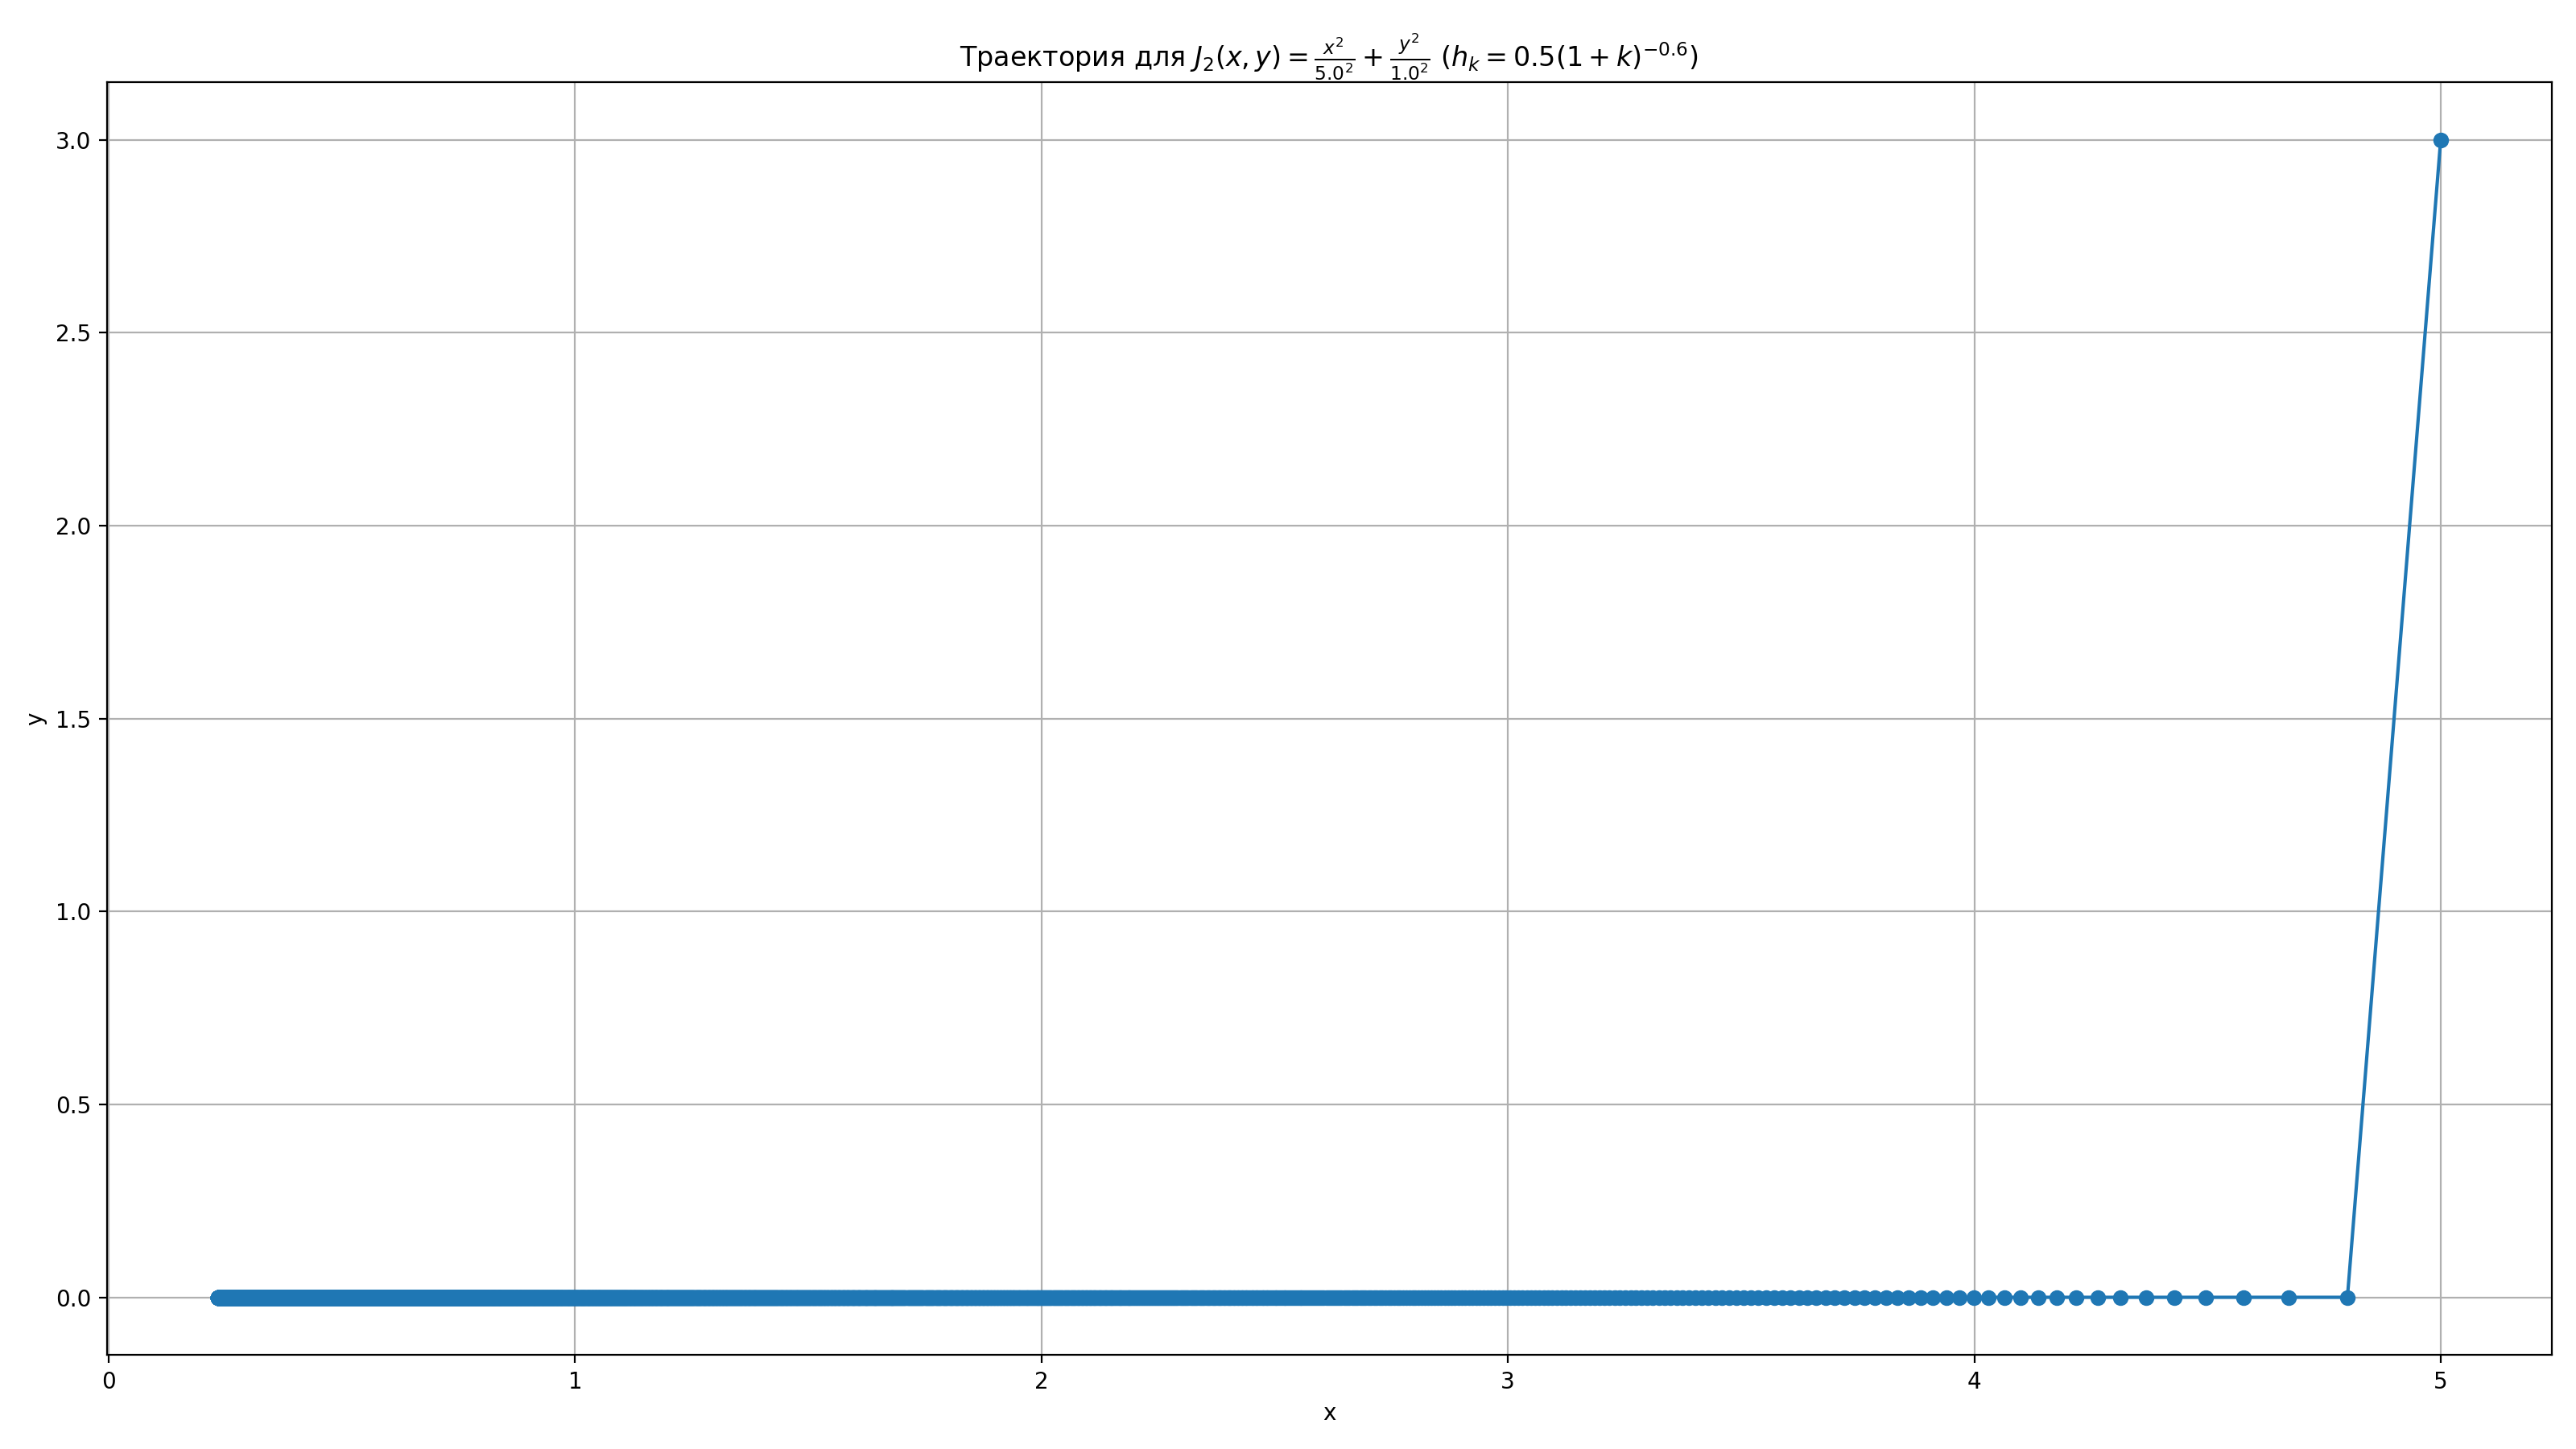

  Значение J(x_k):


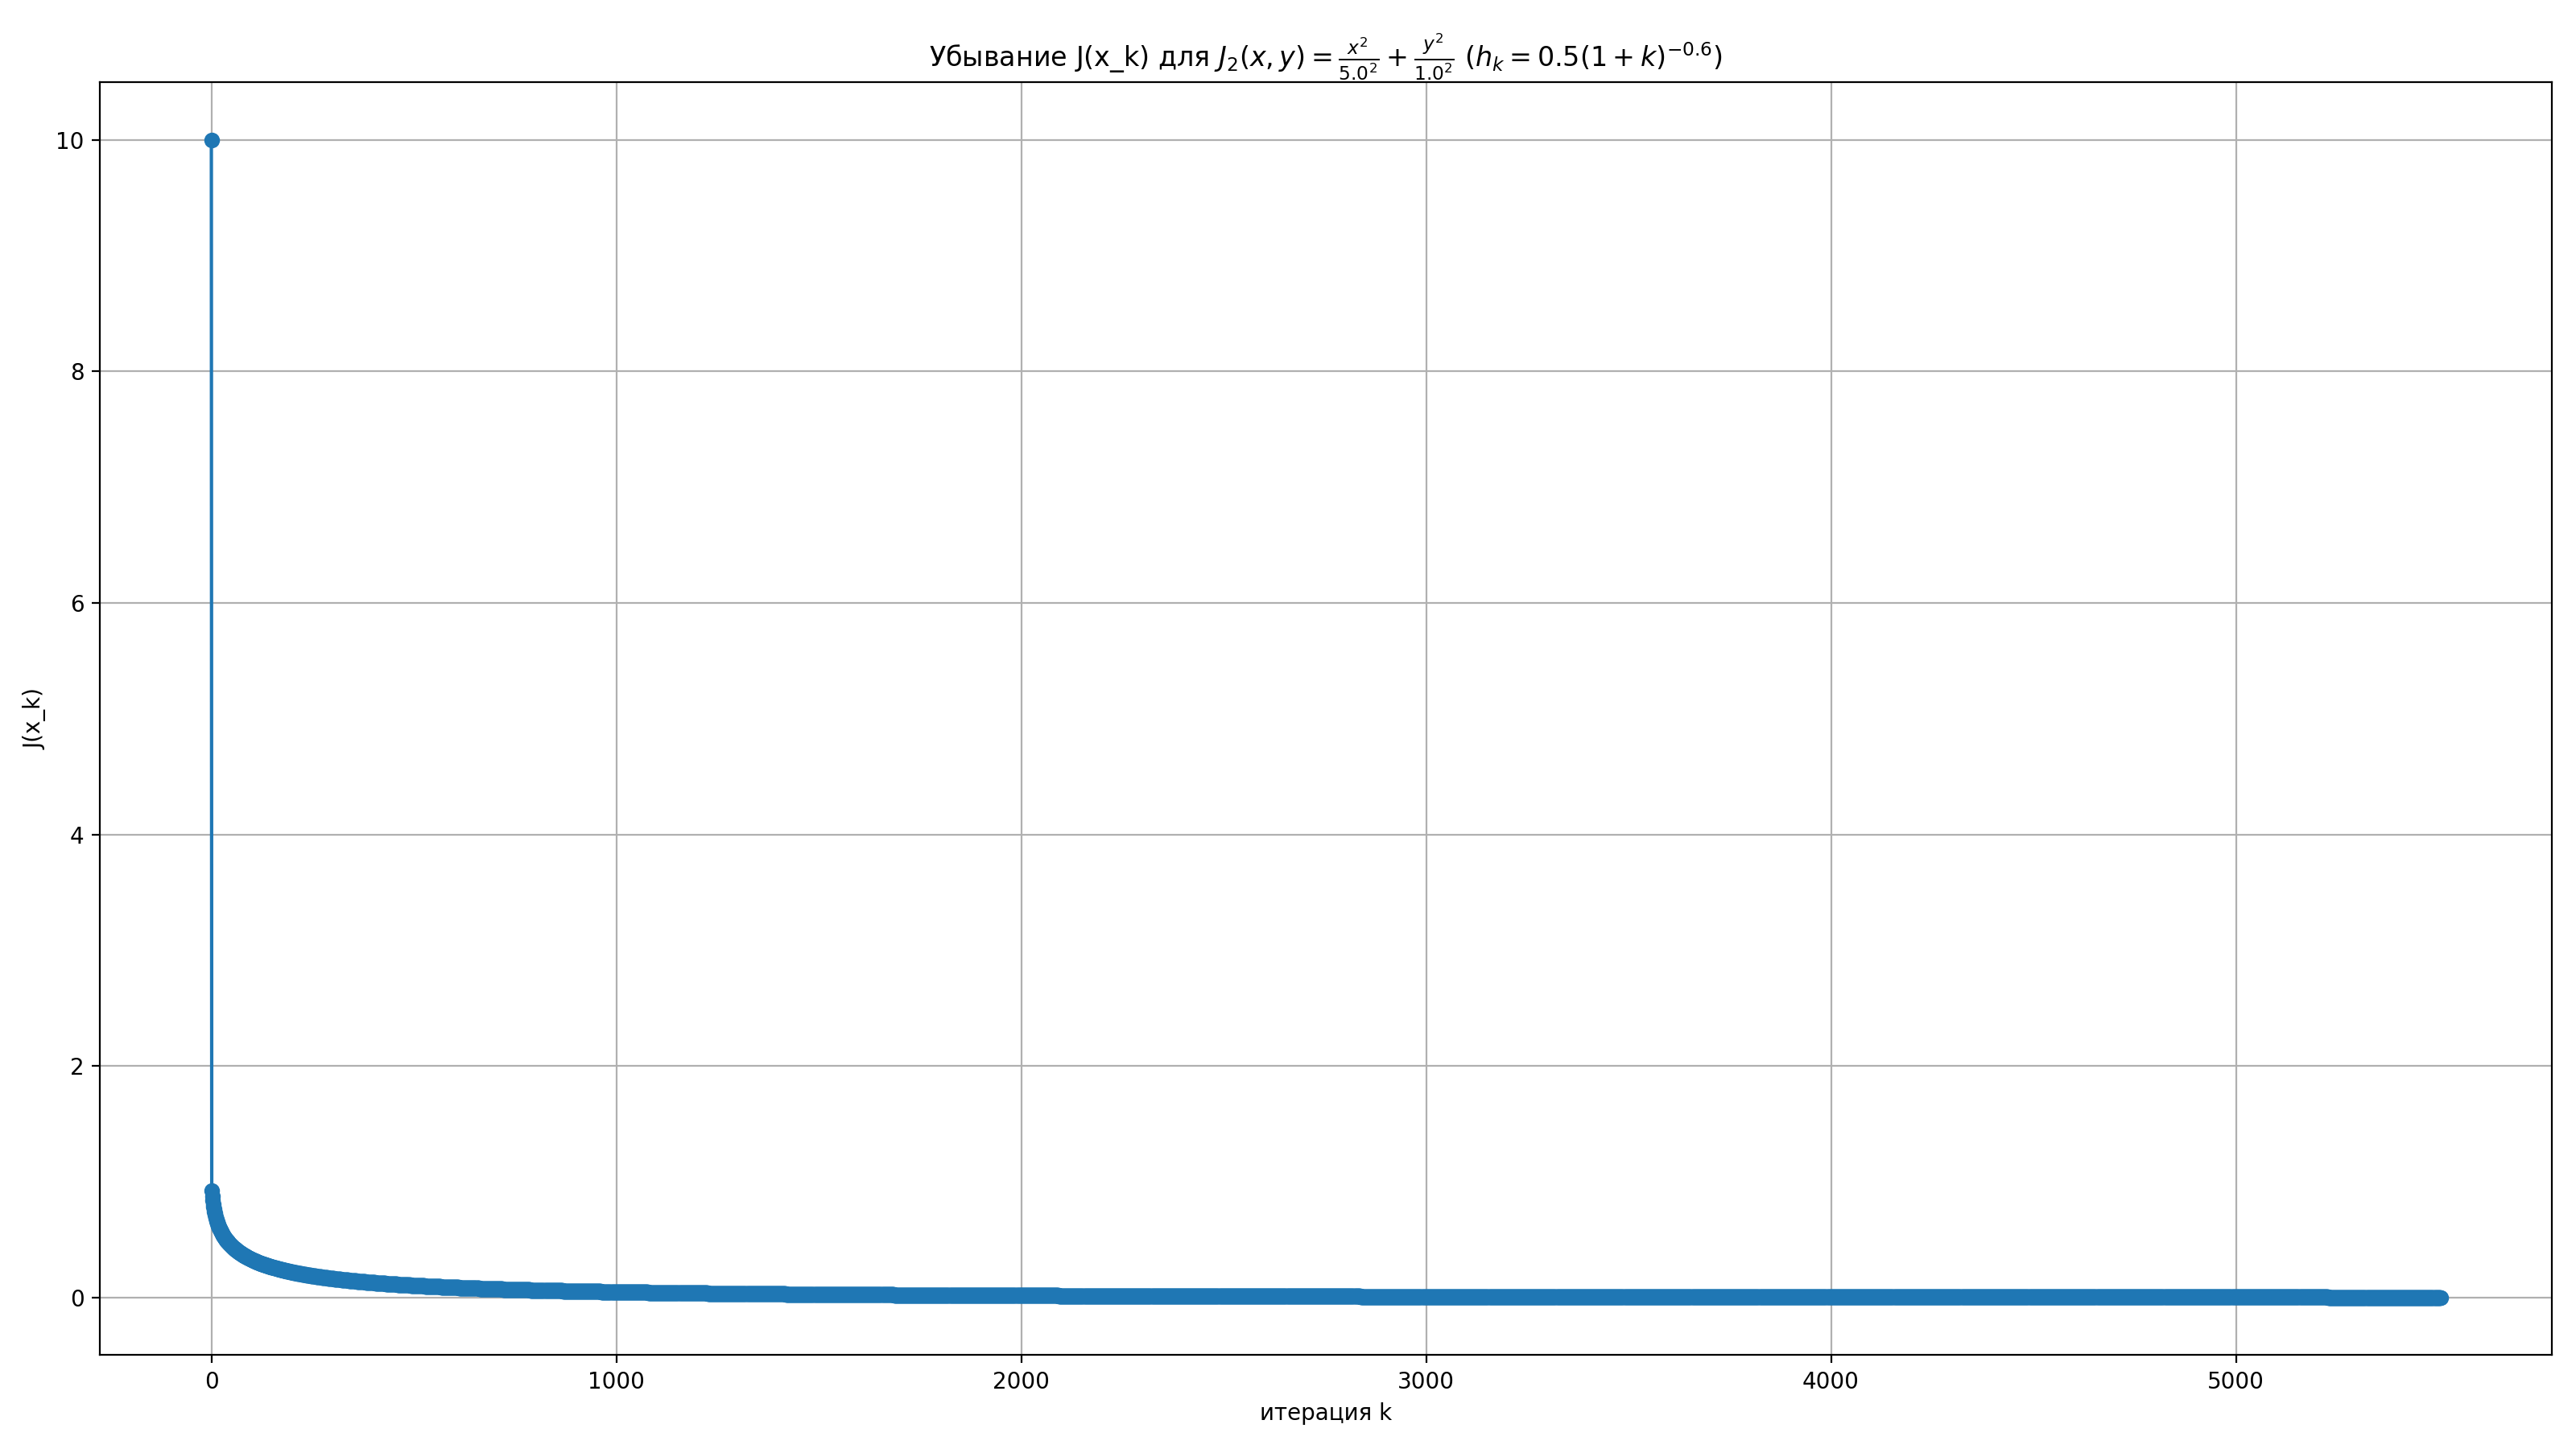

------------------------------------------------------------
Функция f3, режим шага: constant
  шаг: постоянный шаг h = 0.01
  x* = [1.         1.00488784]
  J(x*) = 1.00002389
  число итераций: 332
  причина остановки: tol_f: |J_(k+1)-J_k| = 9.85e-07
  файлы графиков: f3_traj_constant.png, f3_J_constant.png
  Траектория:


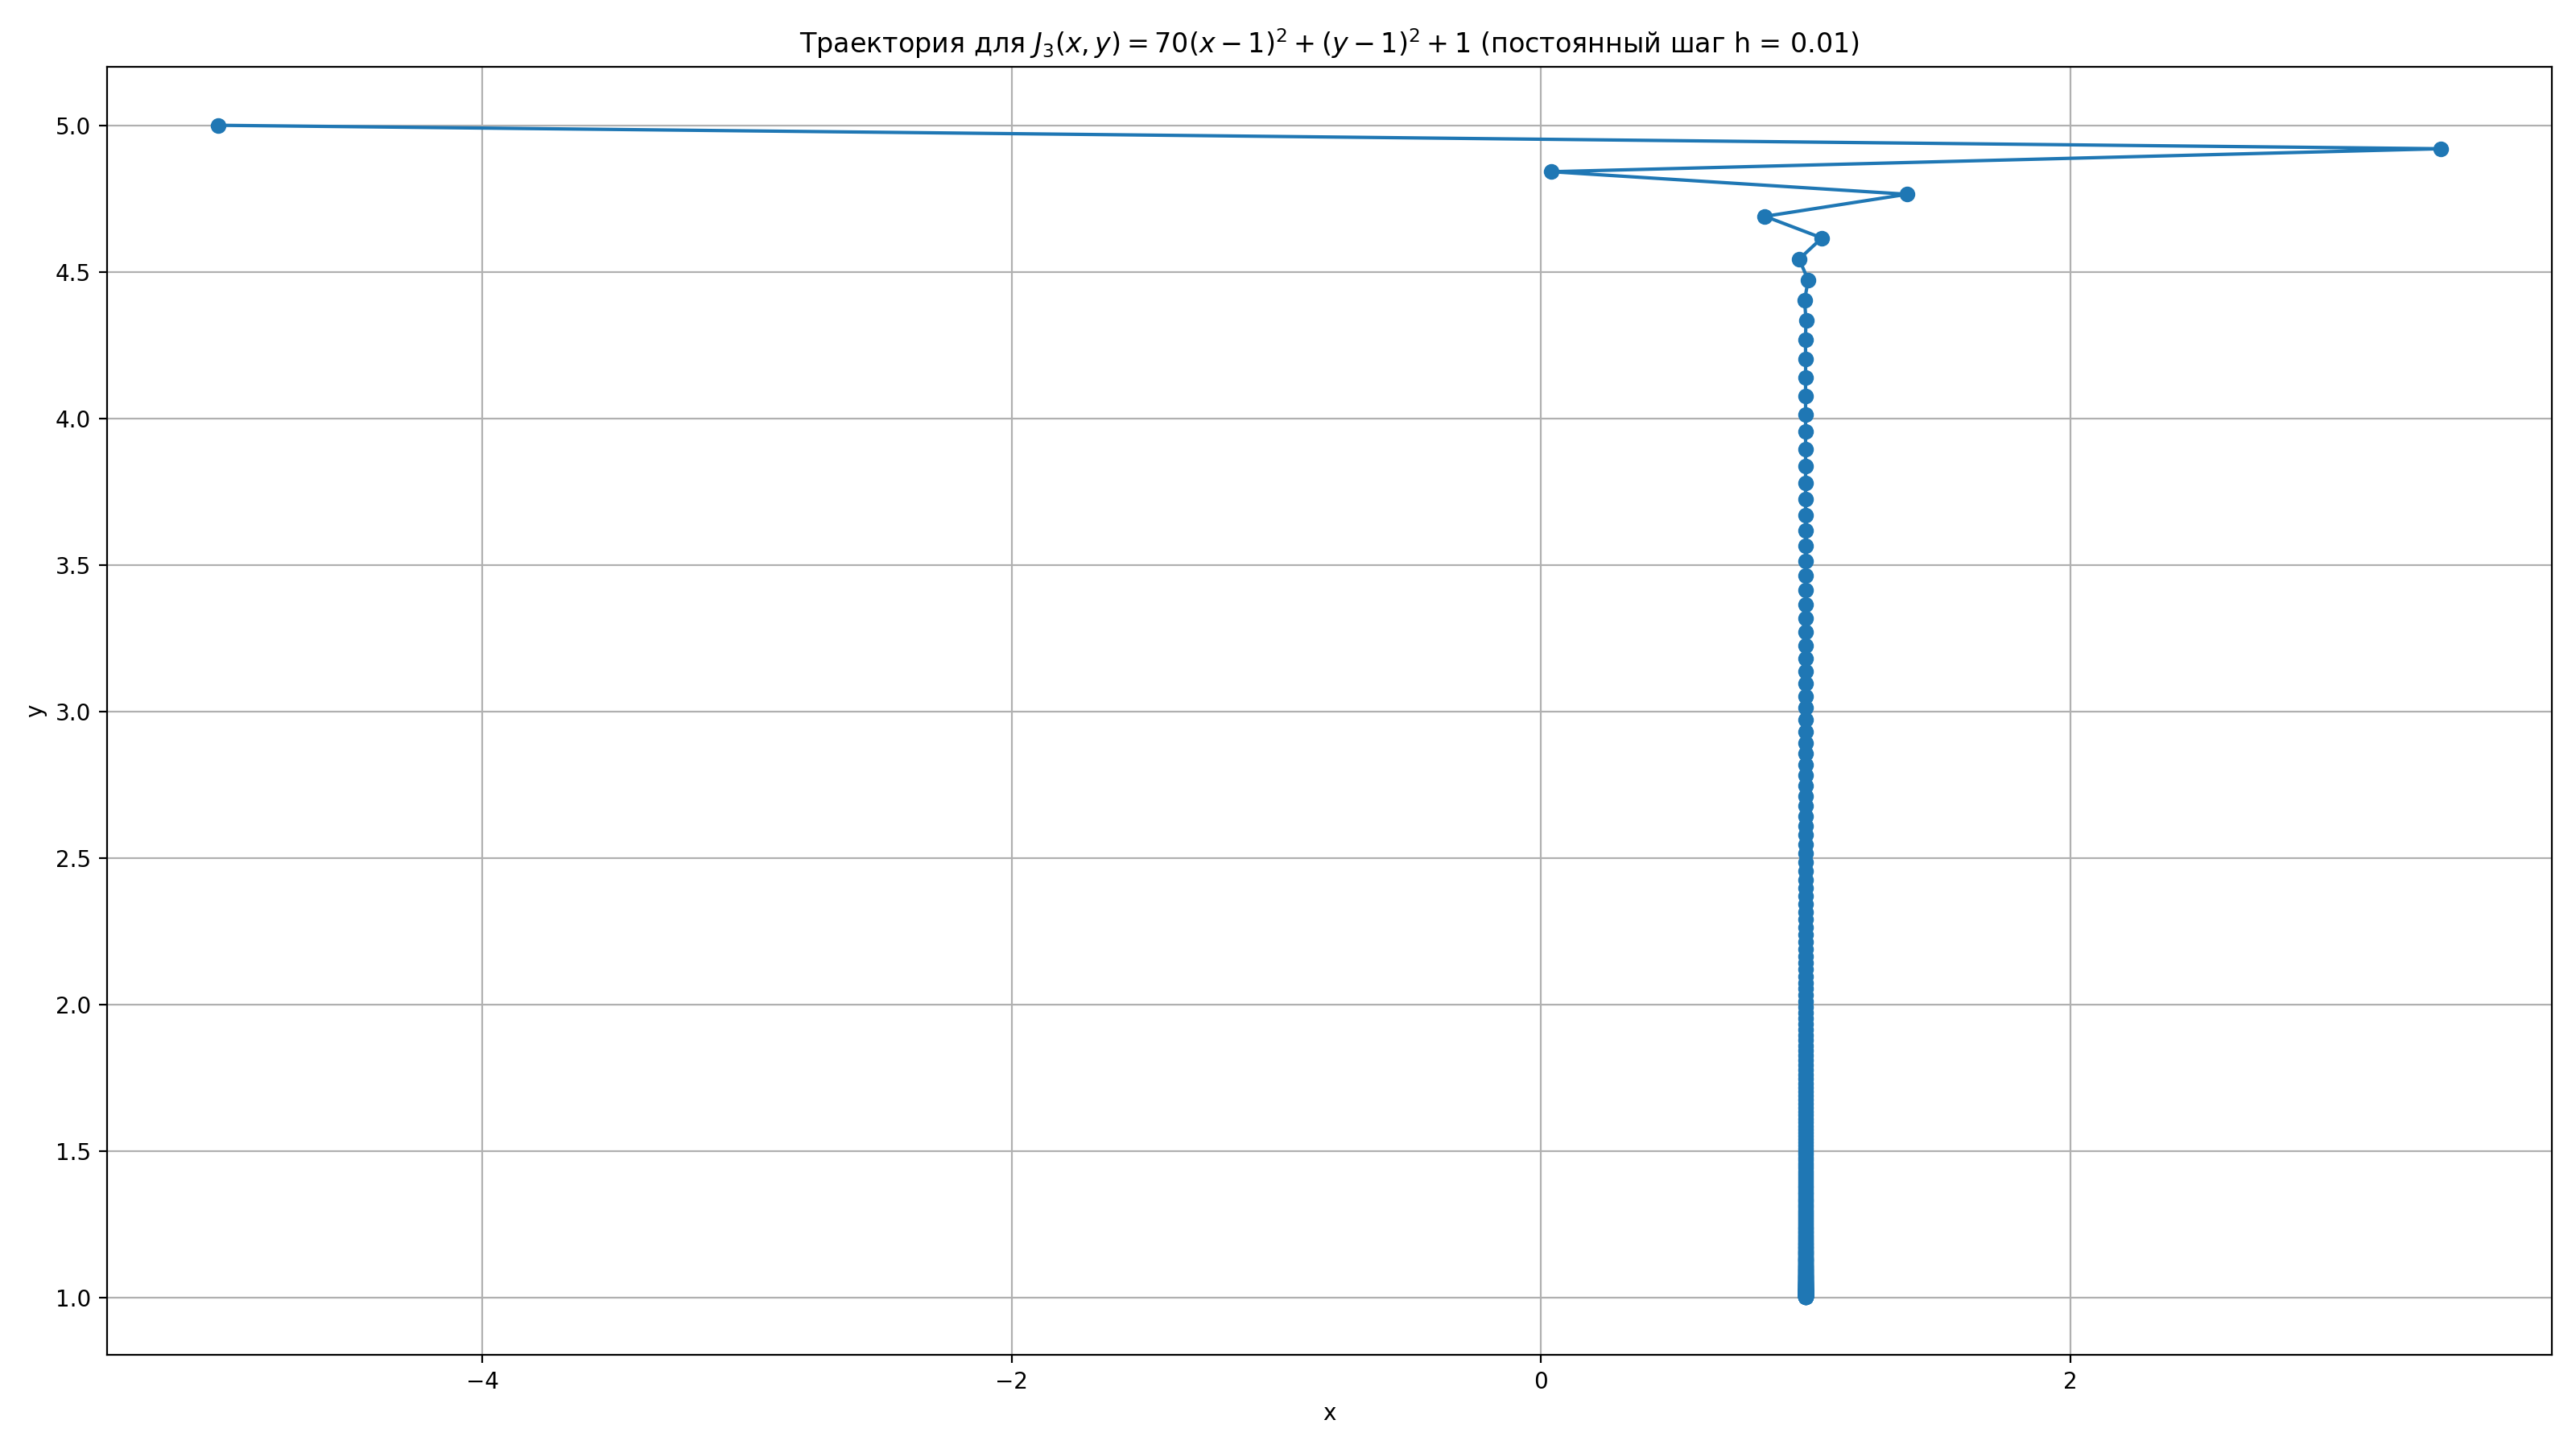

  Значение J(x_k):


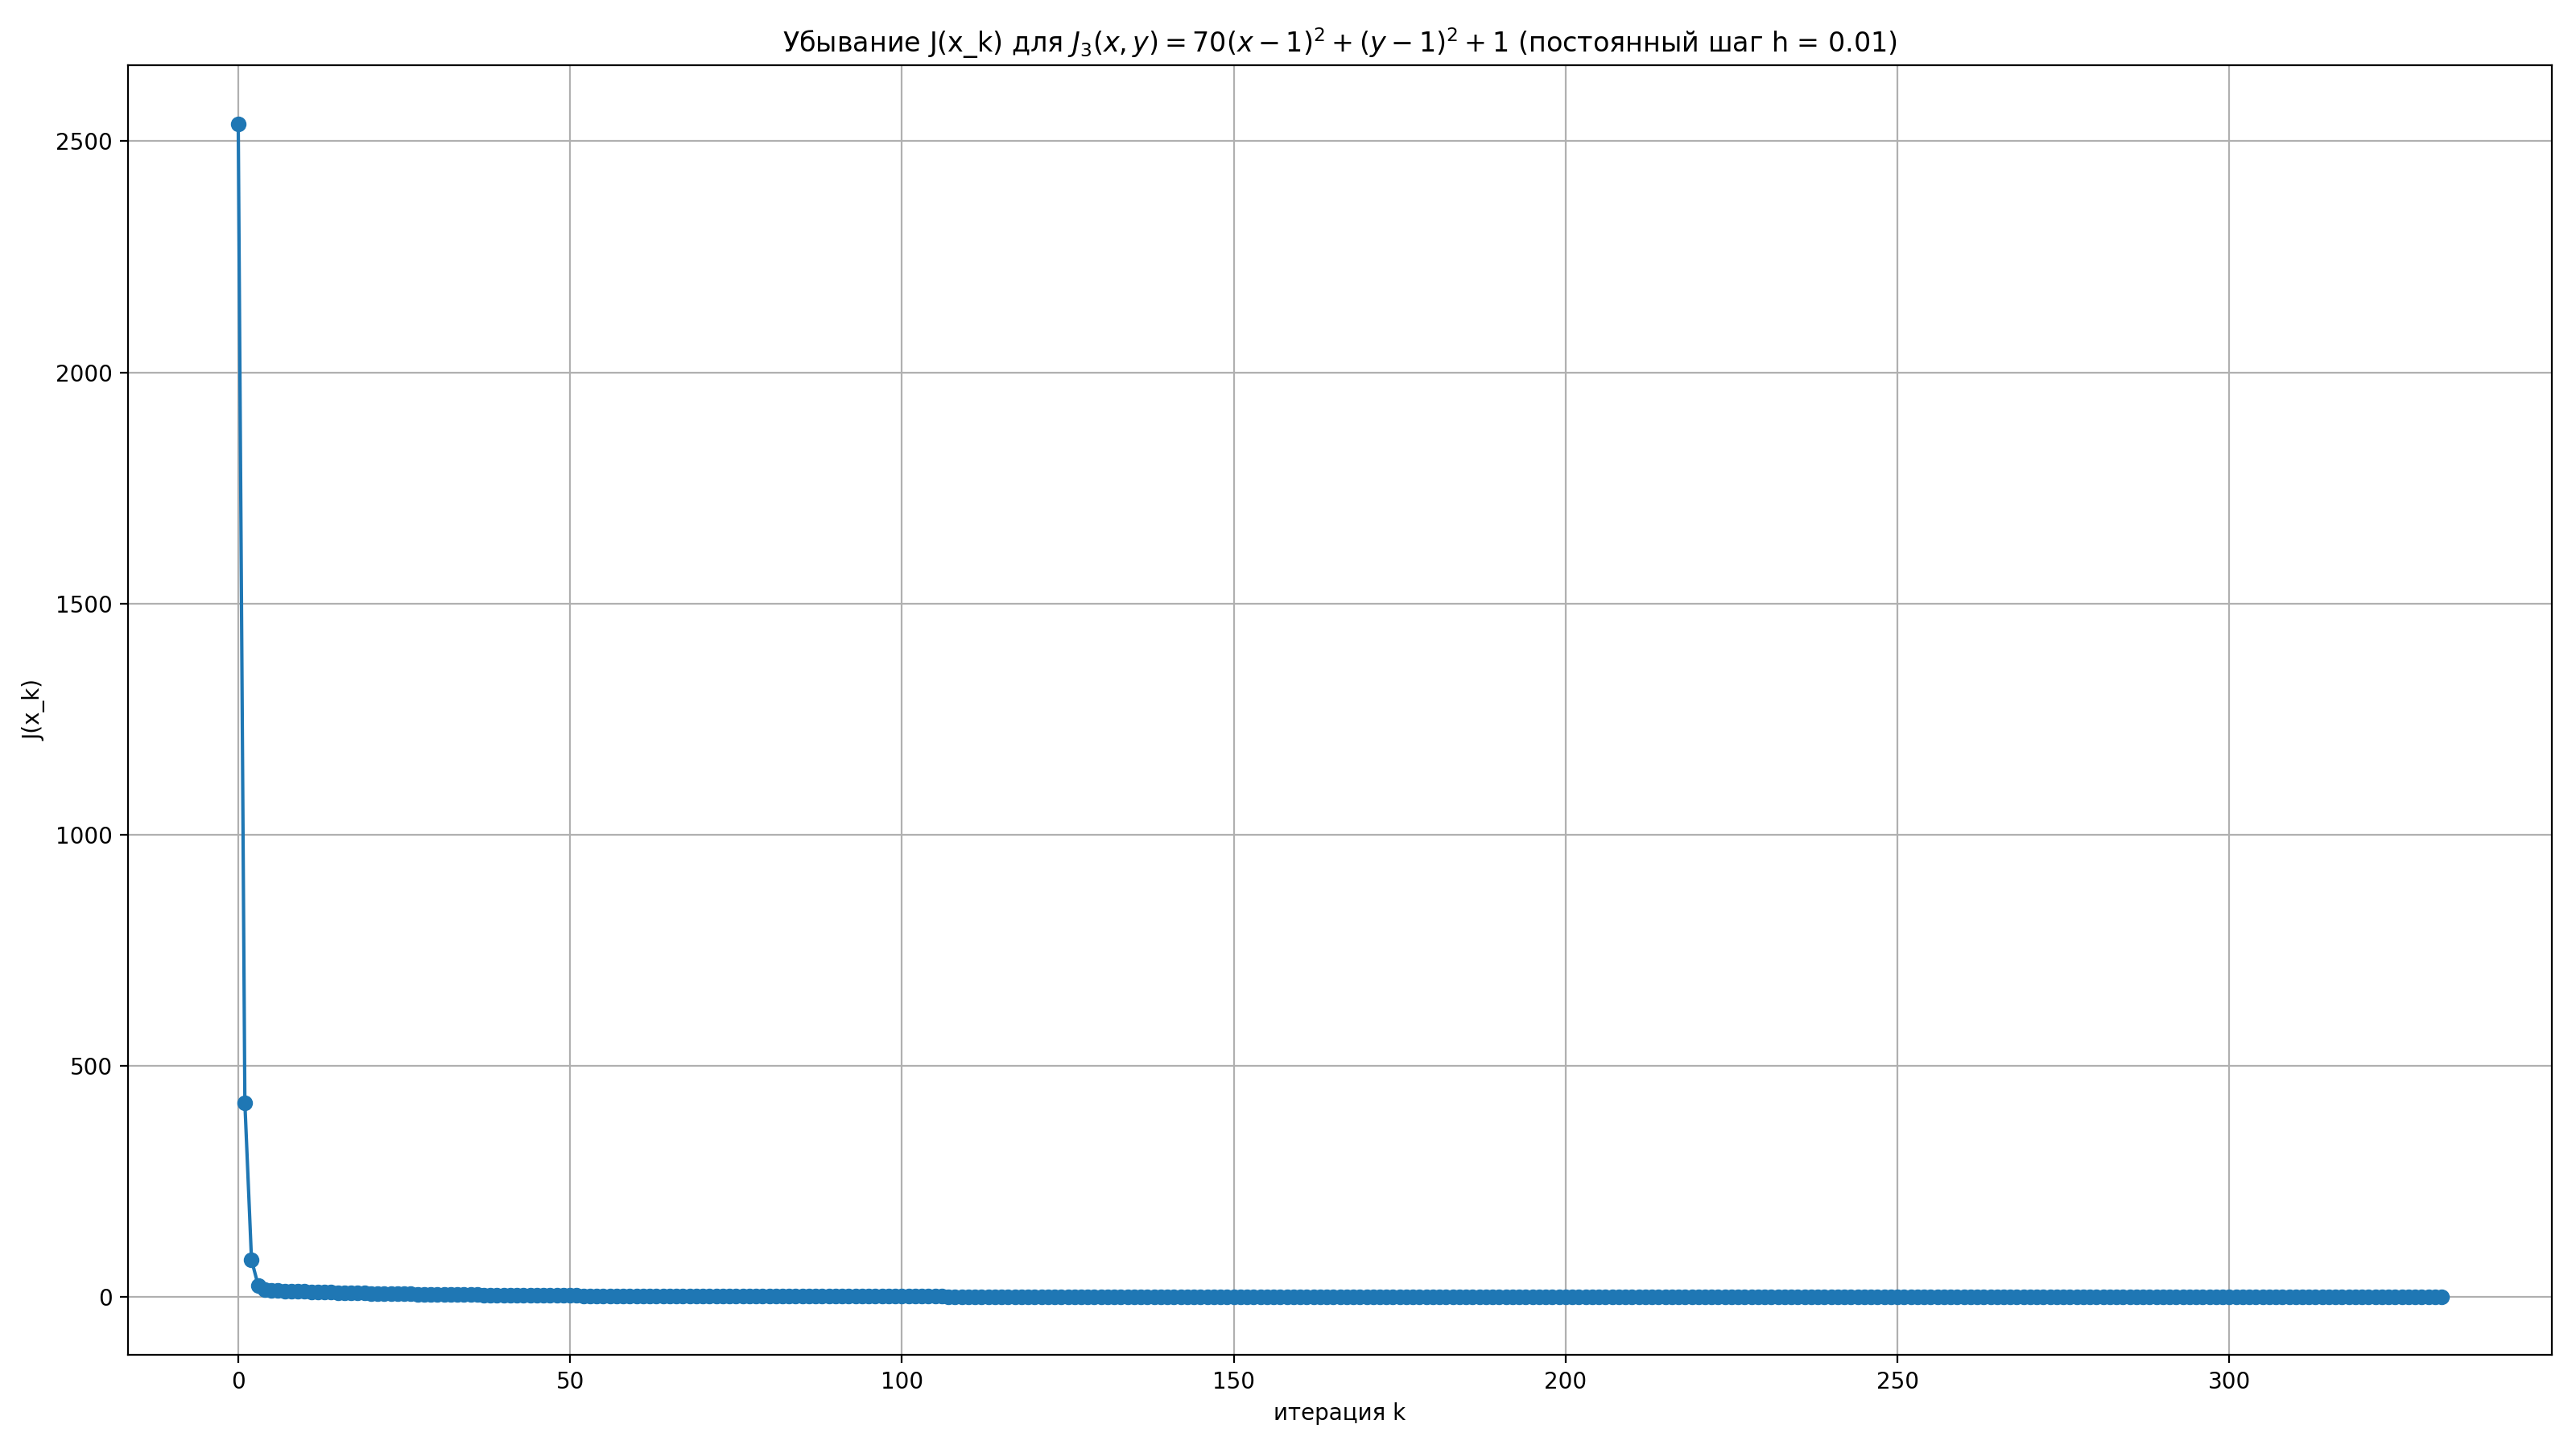

------------------------------------------------------------
Функция f3, режим шага: power
  шаг: $h_k = 0.5 (1 + k)^{-0.9}$
  x* = [1.00000016 1.        ]
  J(x*) = 1.00000000
  число итераций: 111
  причина остановки: tol_f: |J_(k+1)-J_k| = 1.90e-08
  файлы графиков: f3_traj_power.png, f3_J_power.png
  Траектория:


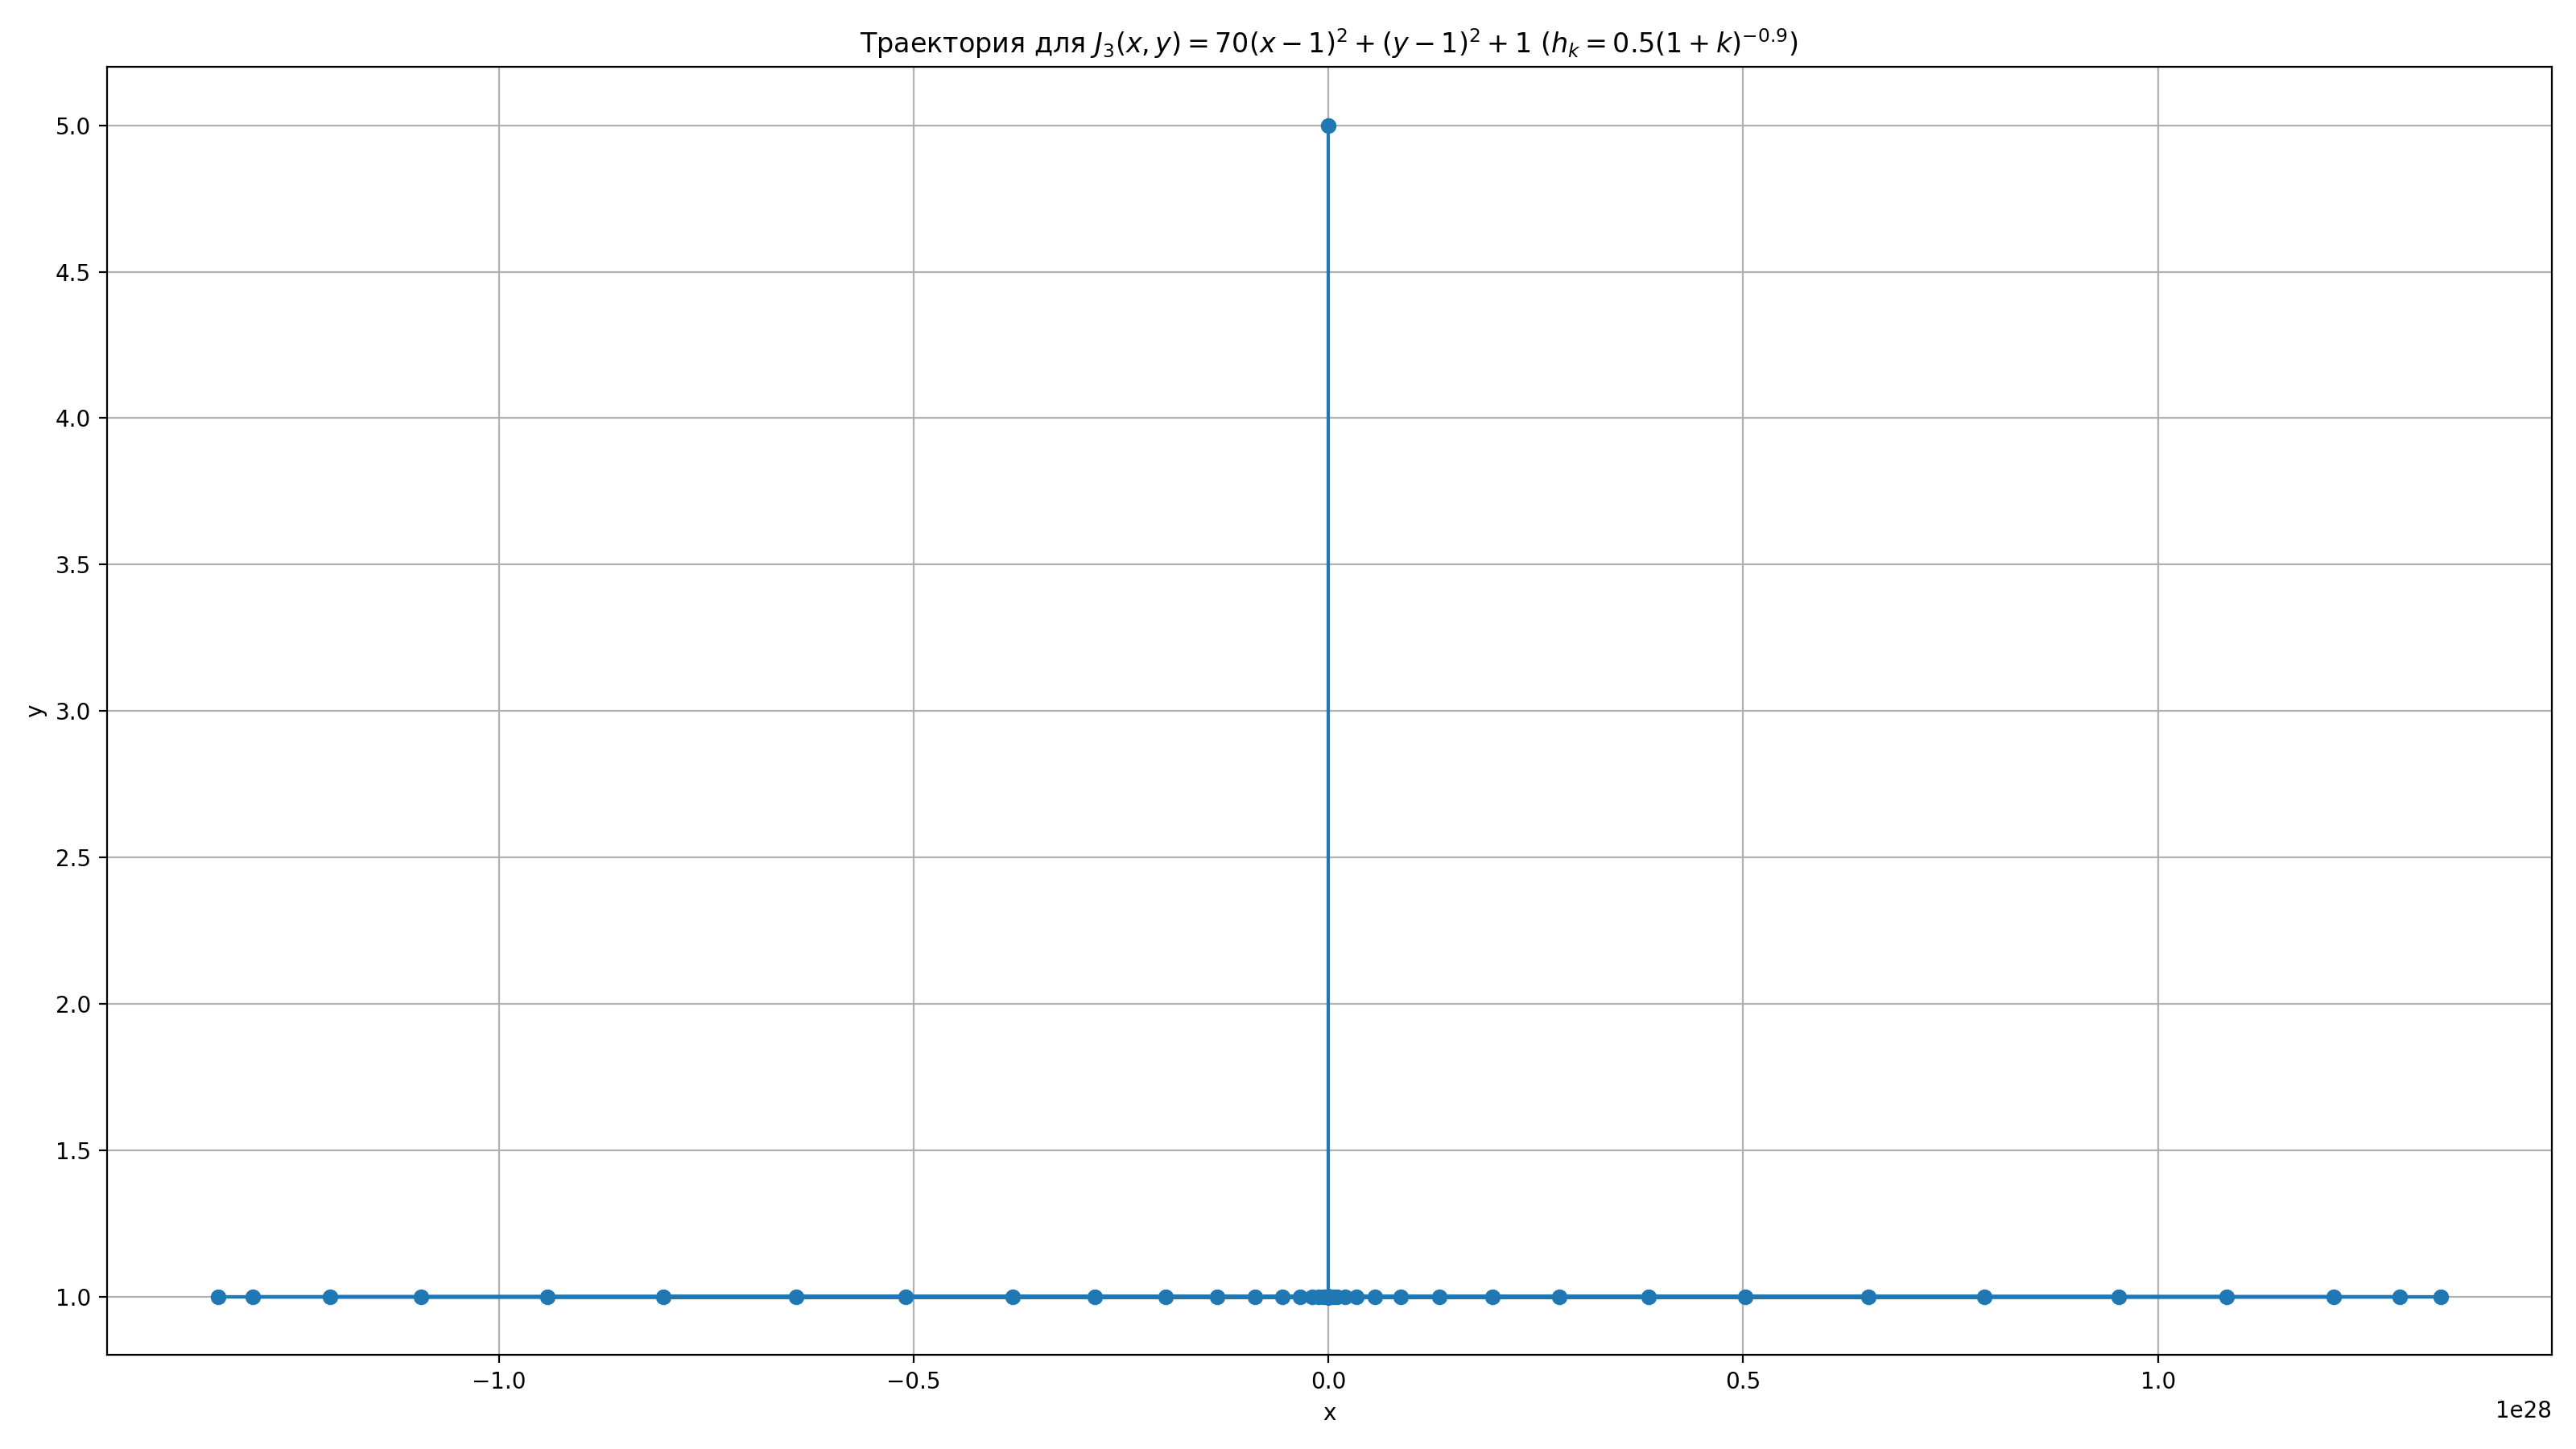

  Значение J(x_k):


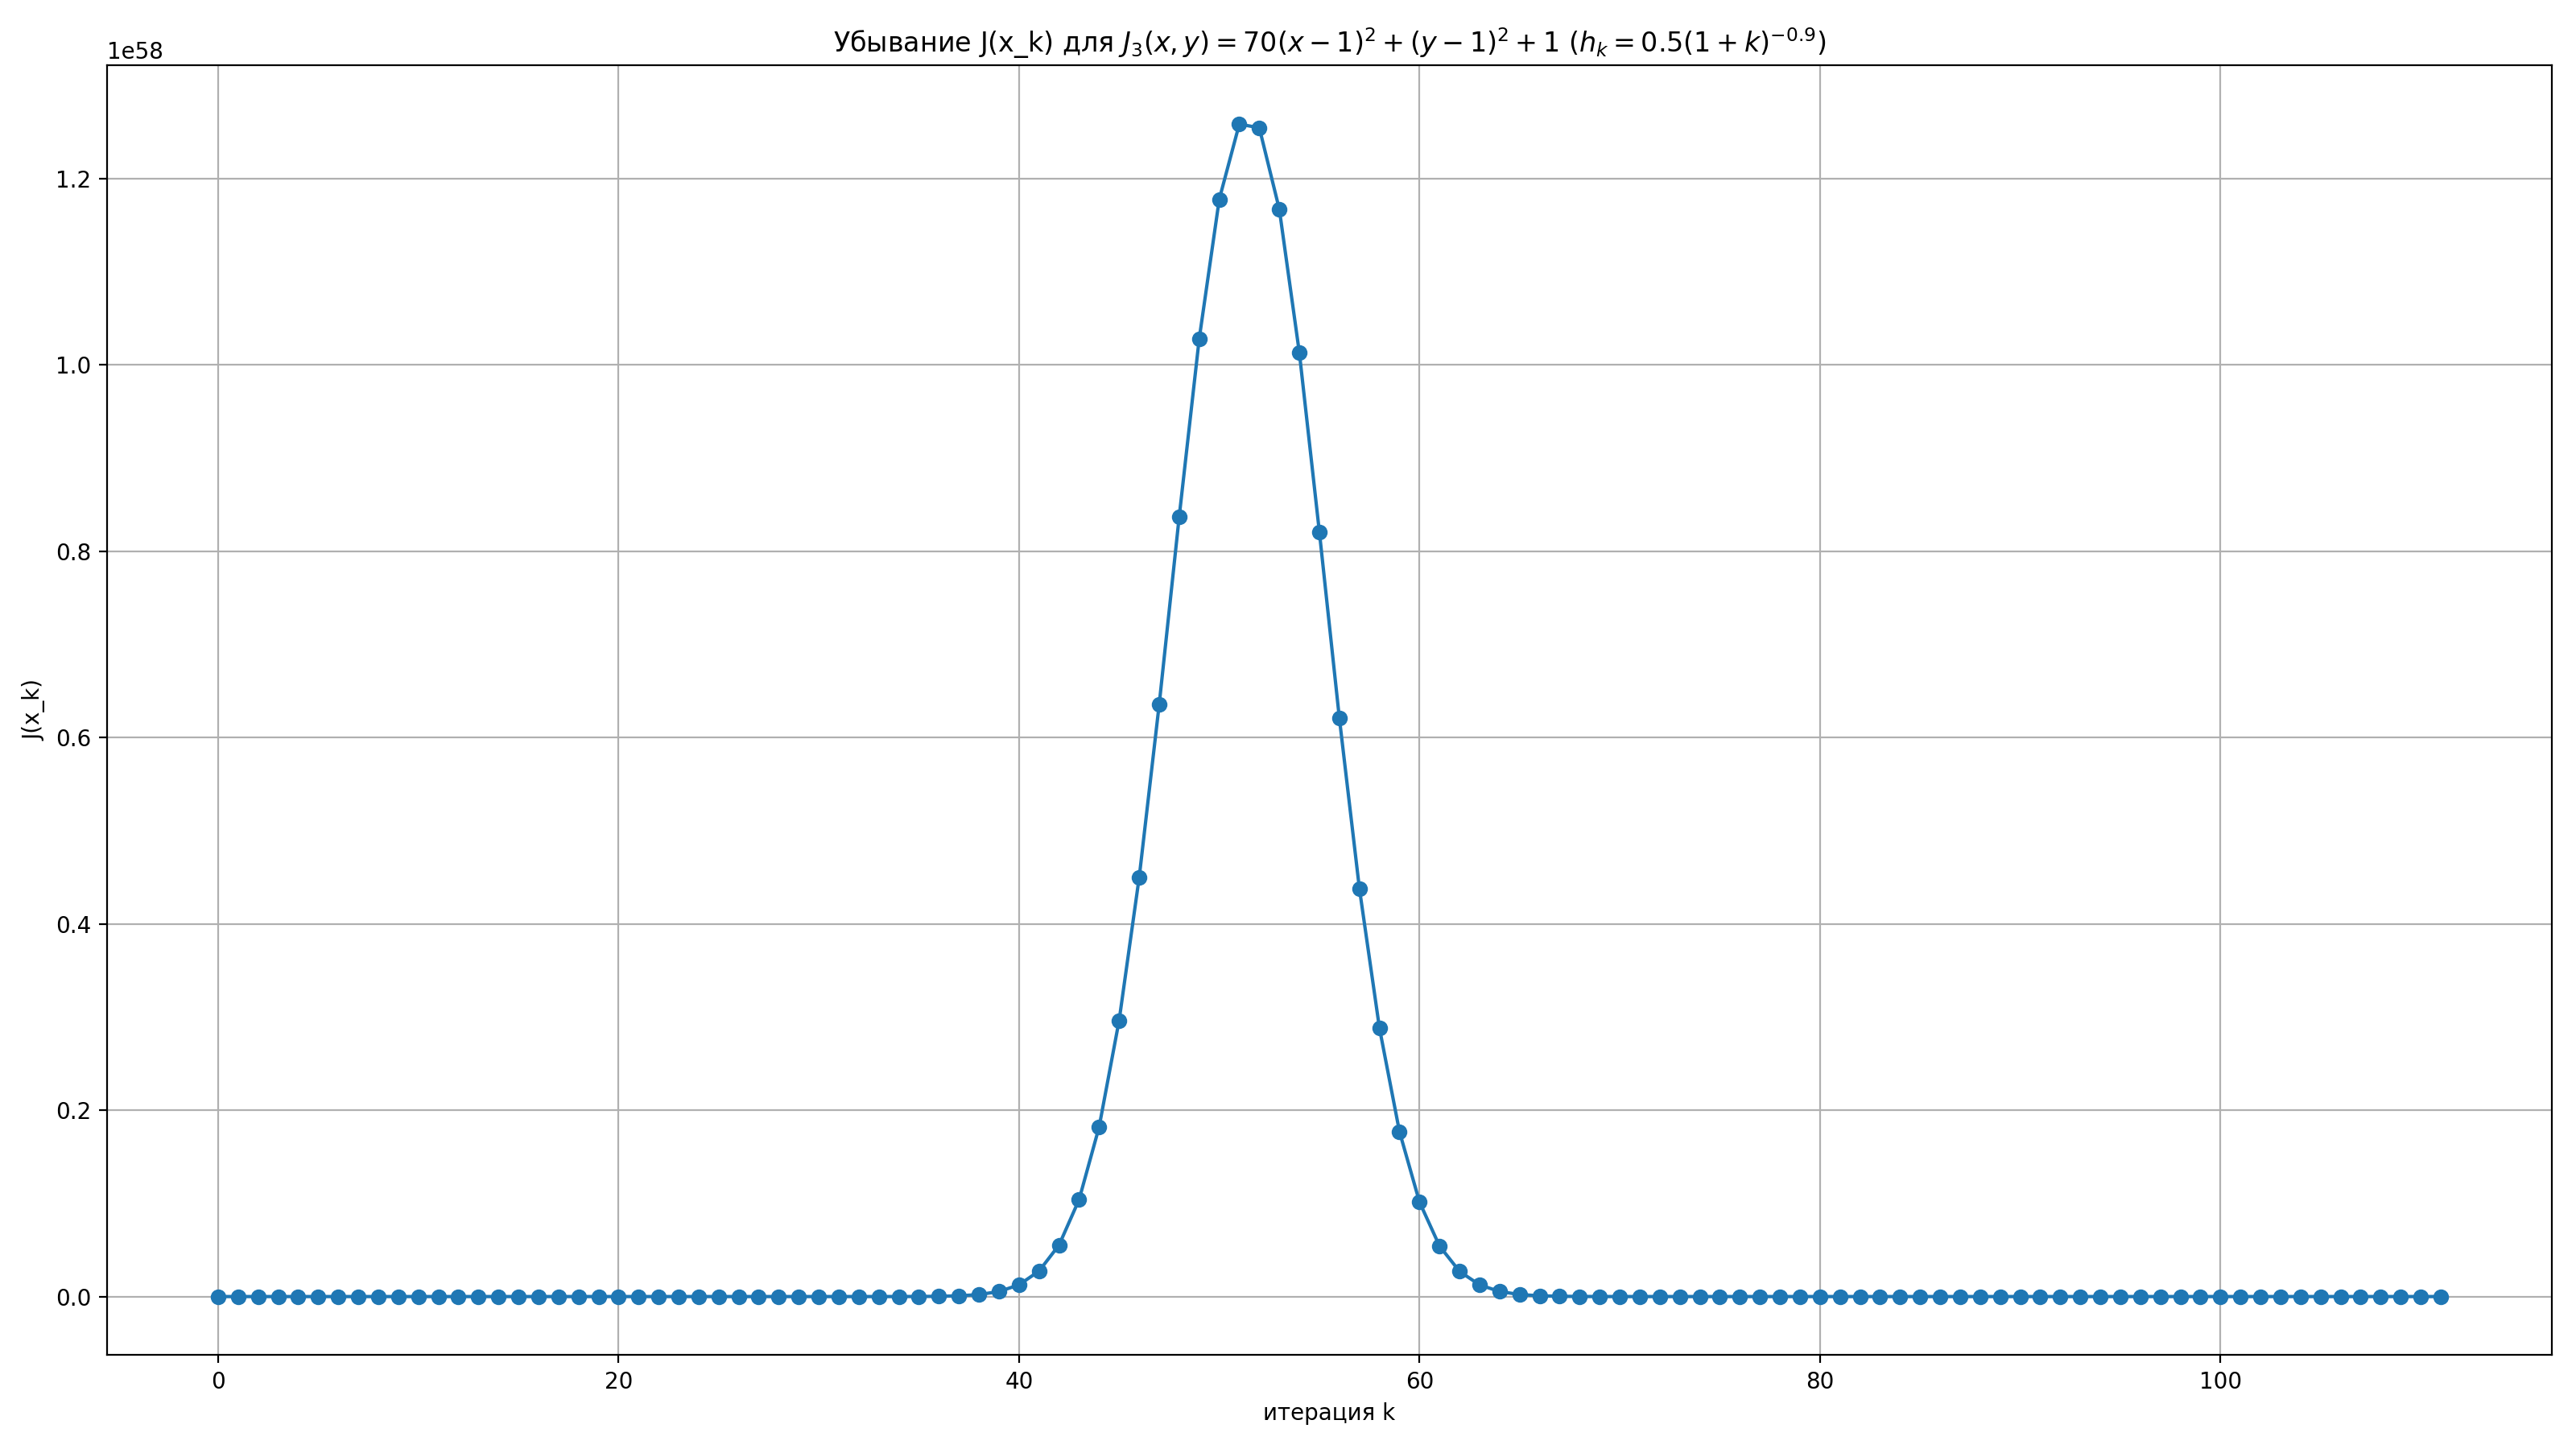

------------------------------------------------------------
Функция f4, режим шага: constant
  шаг: постоянный шаг h = 0.001
  x* = [8.         1.00017529]
  J(x*) = 1.00000218
  число итераций: 61
  причина остановки: tol_f: |J_(k+1)-J_k| = 7.82e-07
  файлы графиков: f4_traj_constant.png, f4_J_constant.png
  Траектория:


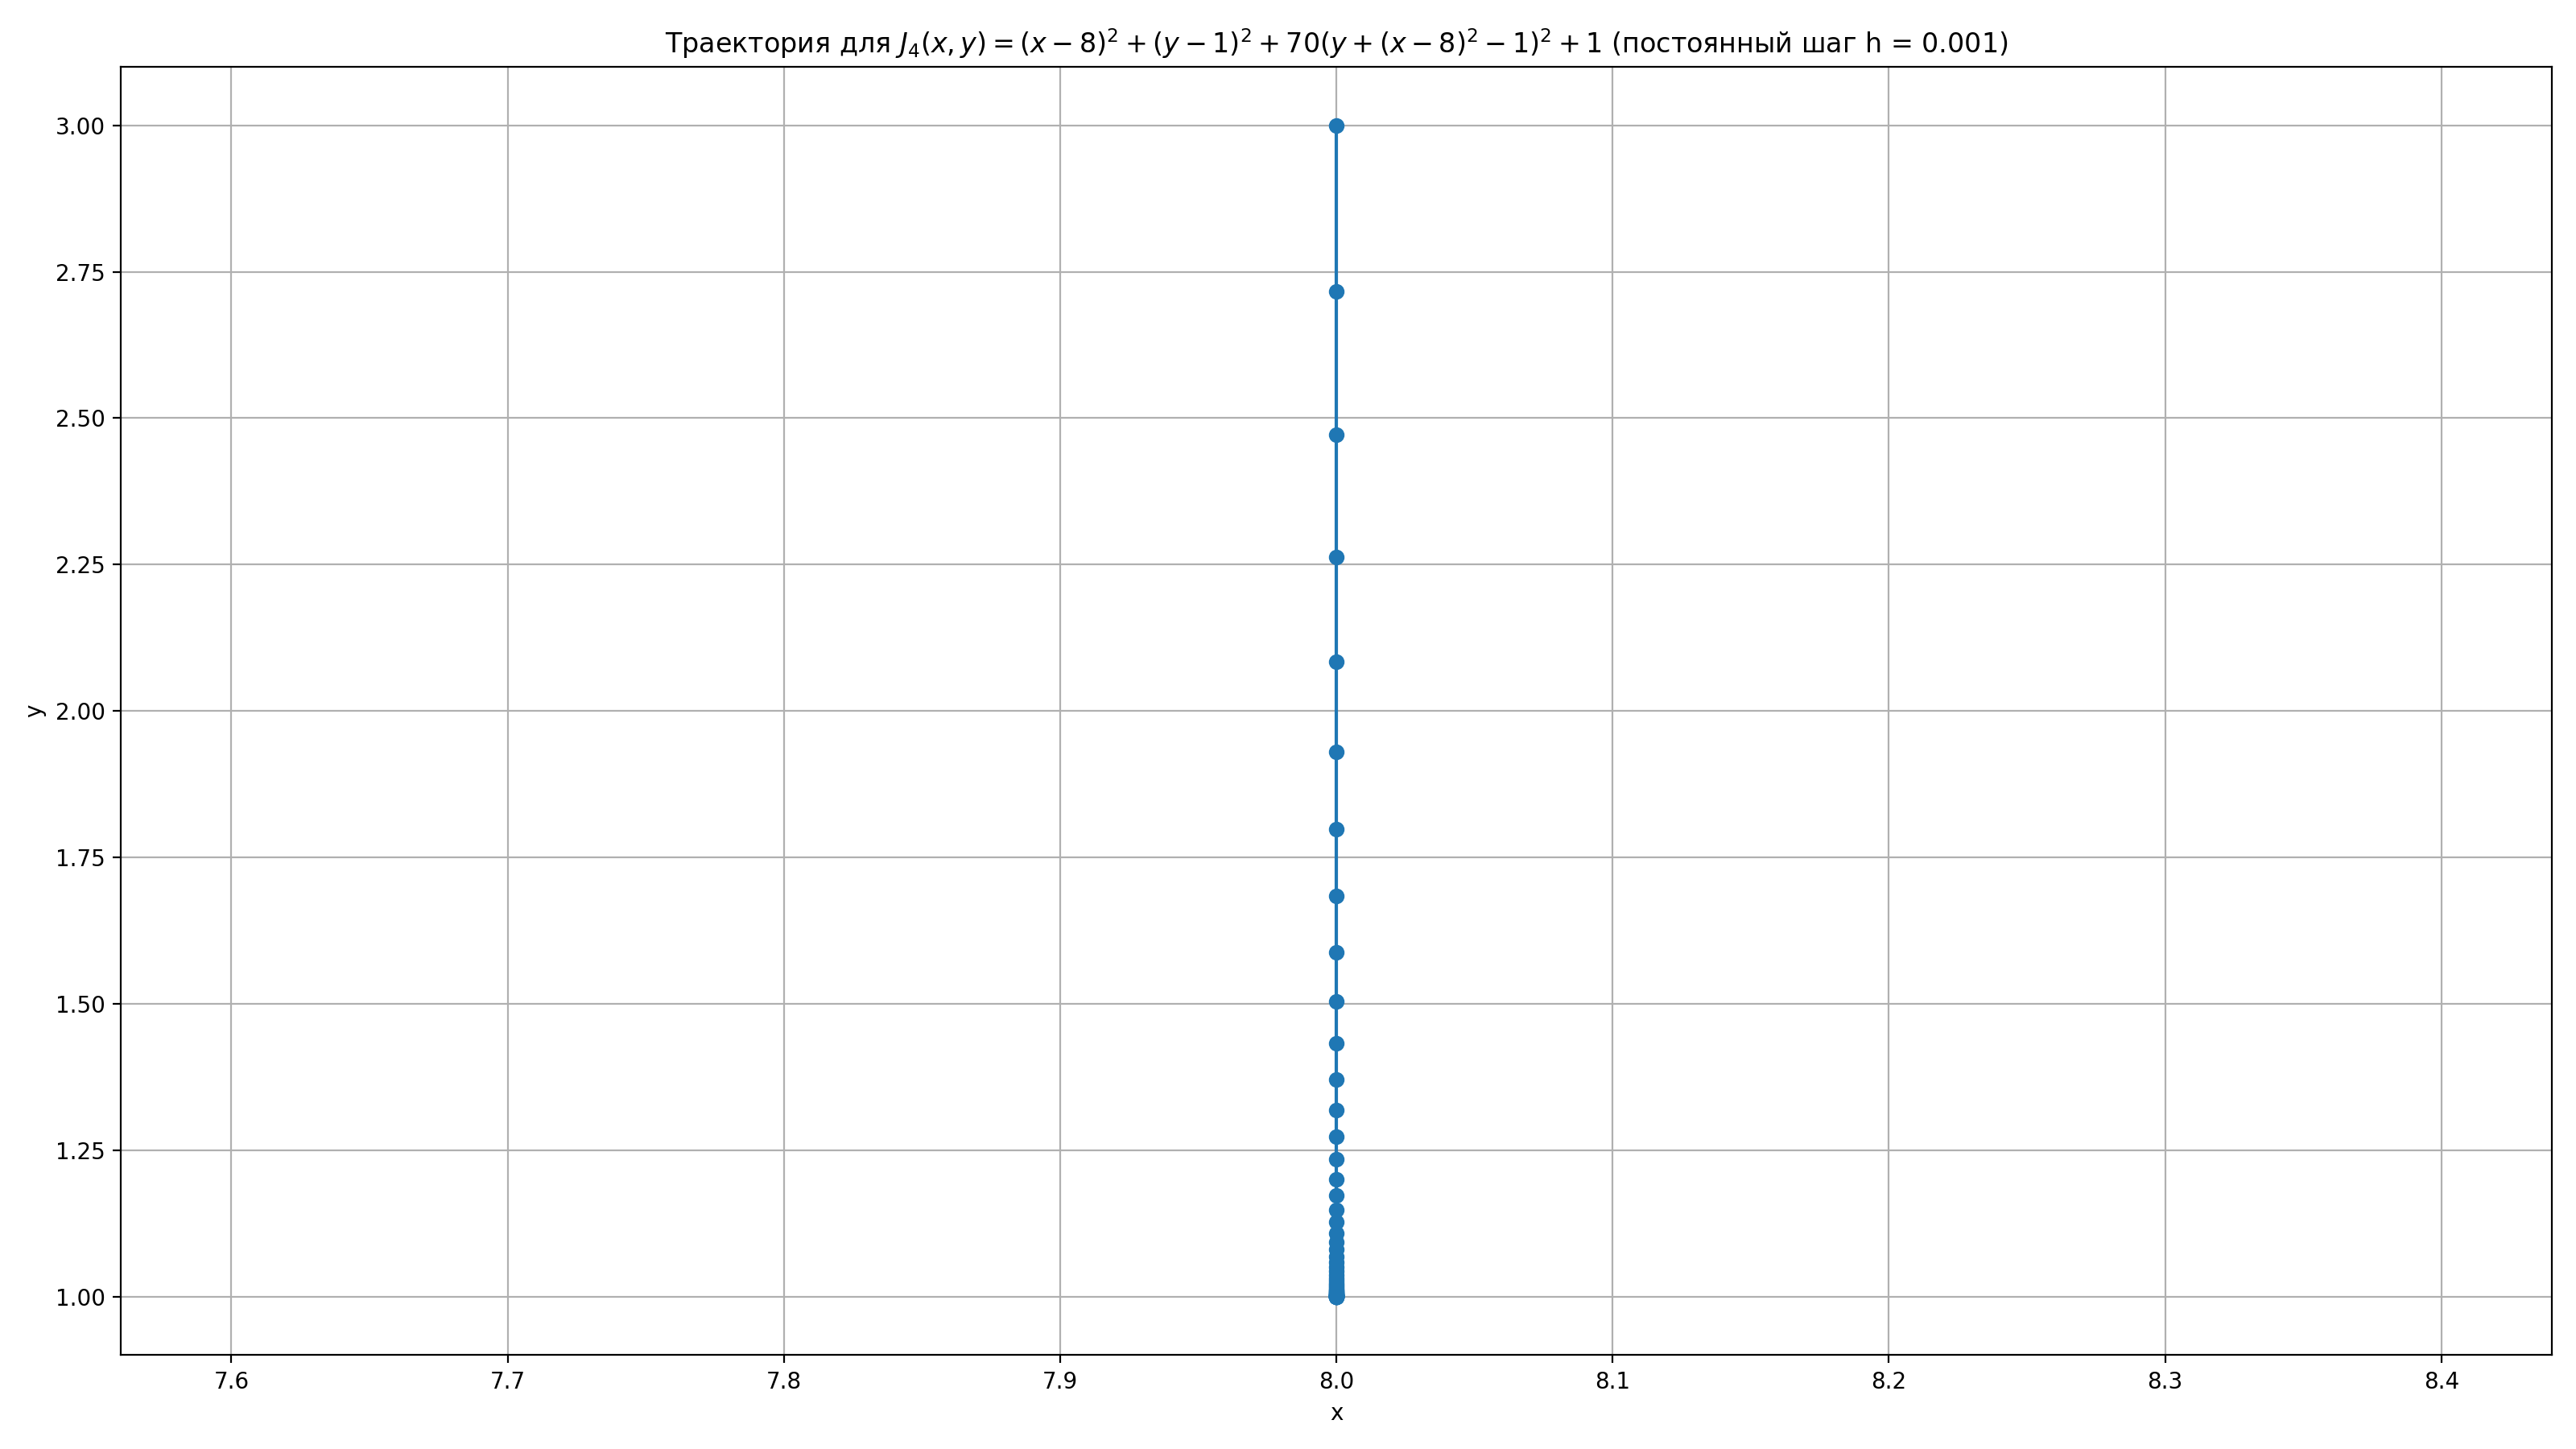

  Значение J(x_k):


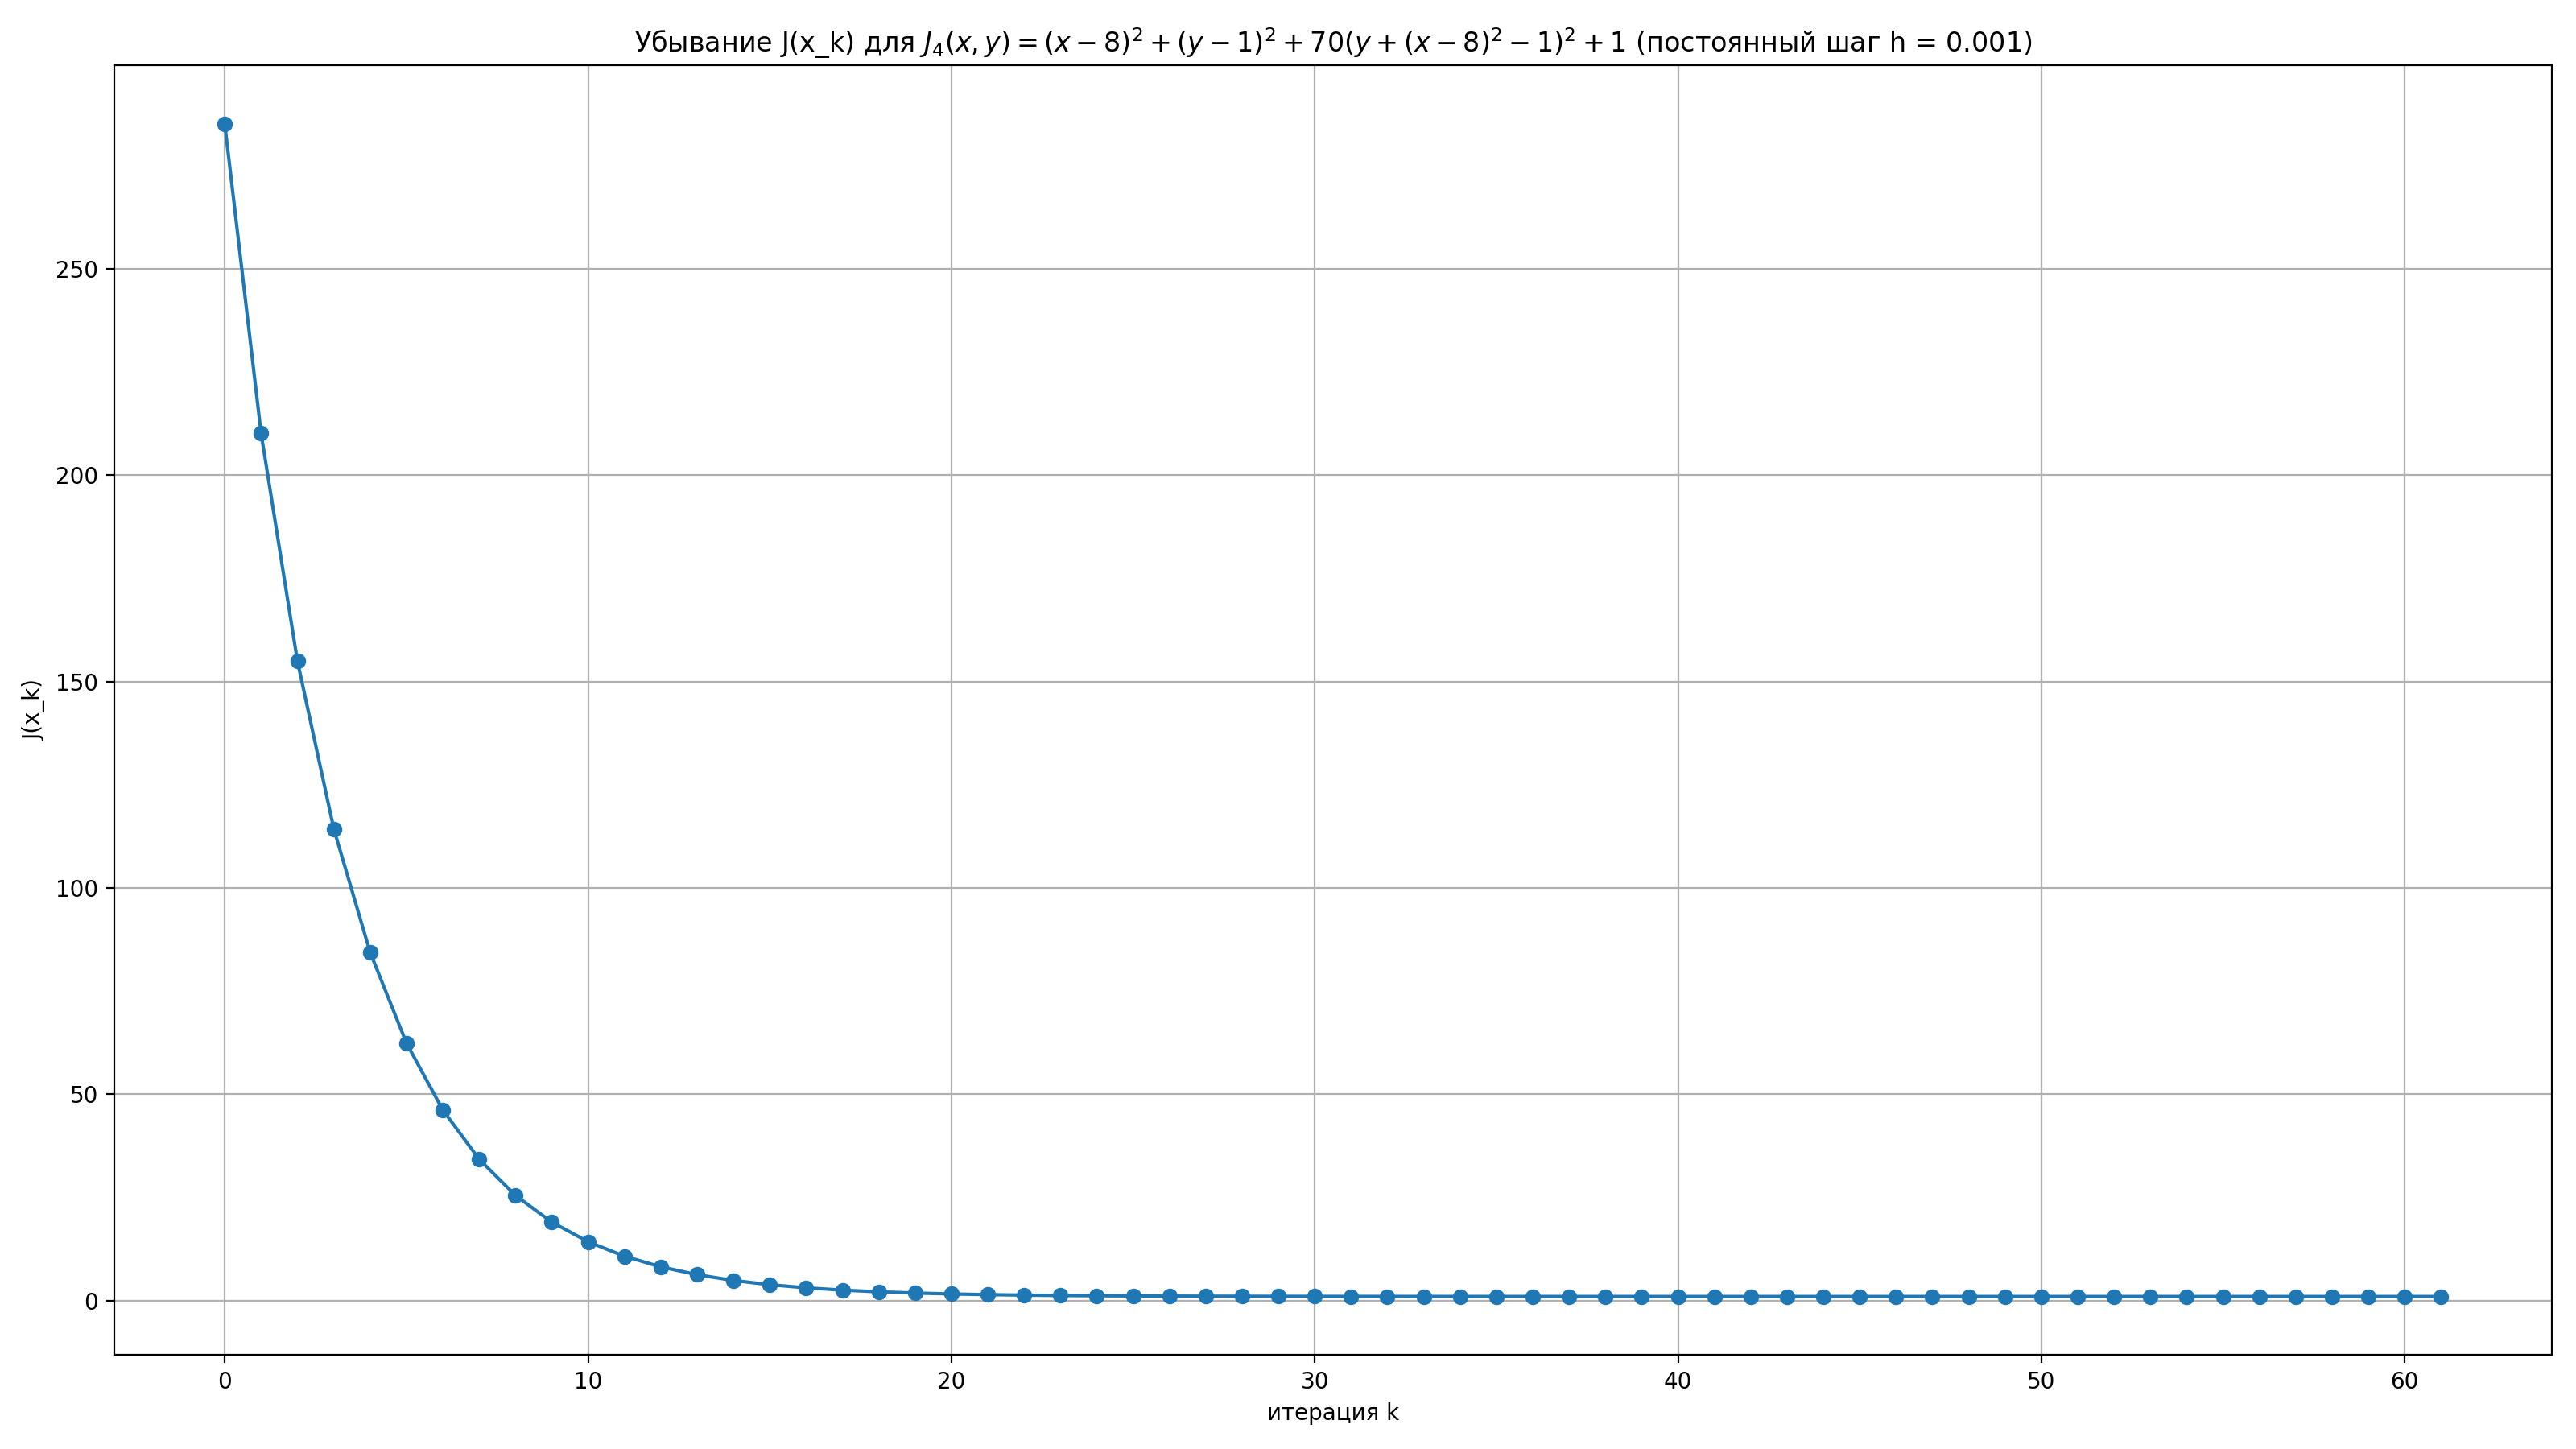

------------------------------------------------------------
Функция f4, режим шага: power
  шаг: $h_k = 0.05 (1 + k)^{-0.9}$
  x* = [8.         1.00002768]
  J(x*) = 1.00000005
  число итераций: 12
  причина остановки: tol_f: |J_(k+1)-J_k| = 8.79e-07
  файлы графиков: f4_traj_power.png, f4_J_power.png
  Траектория:


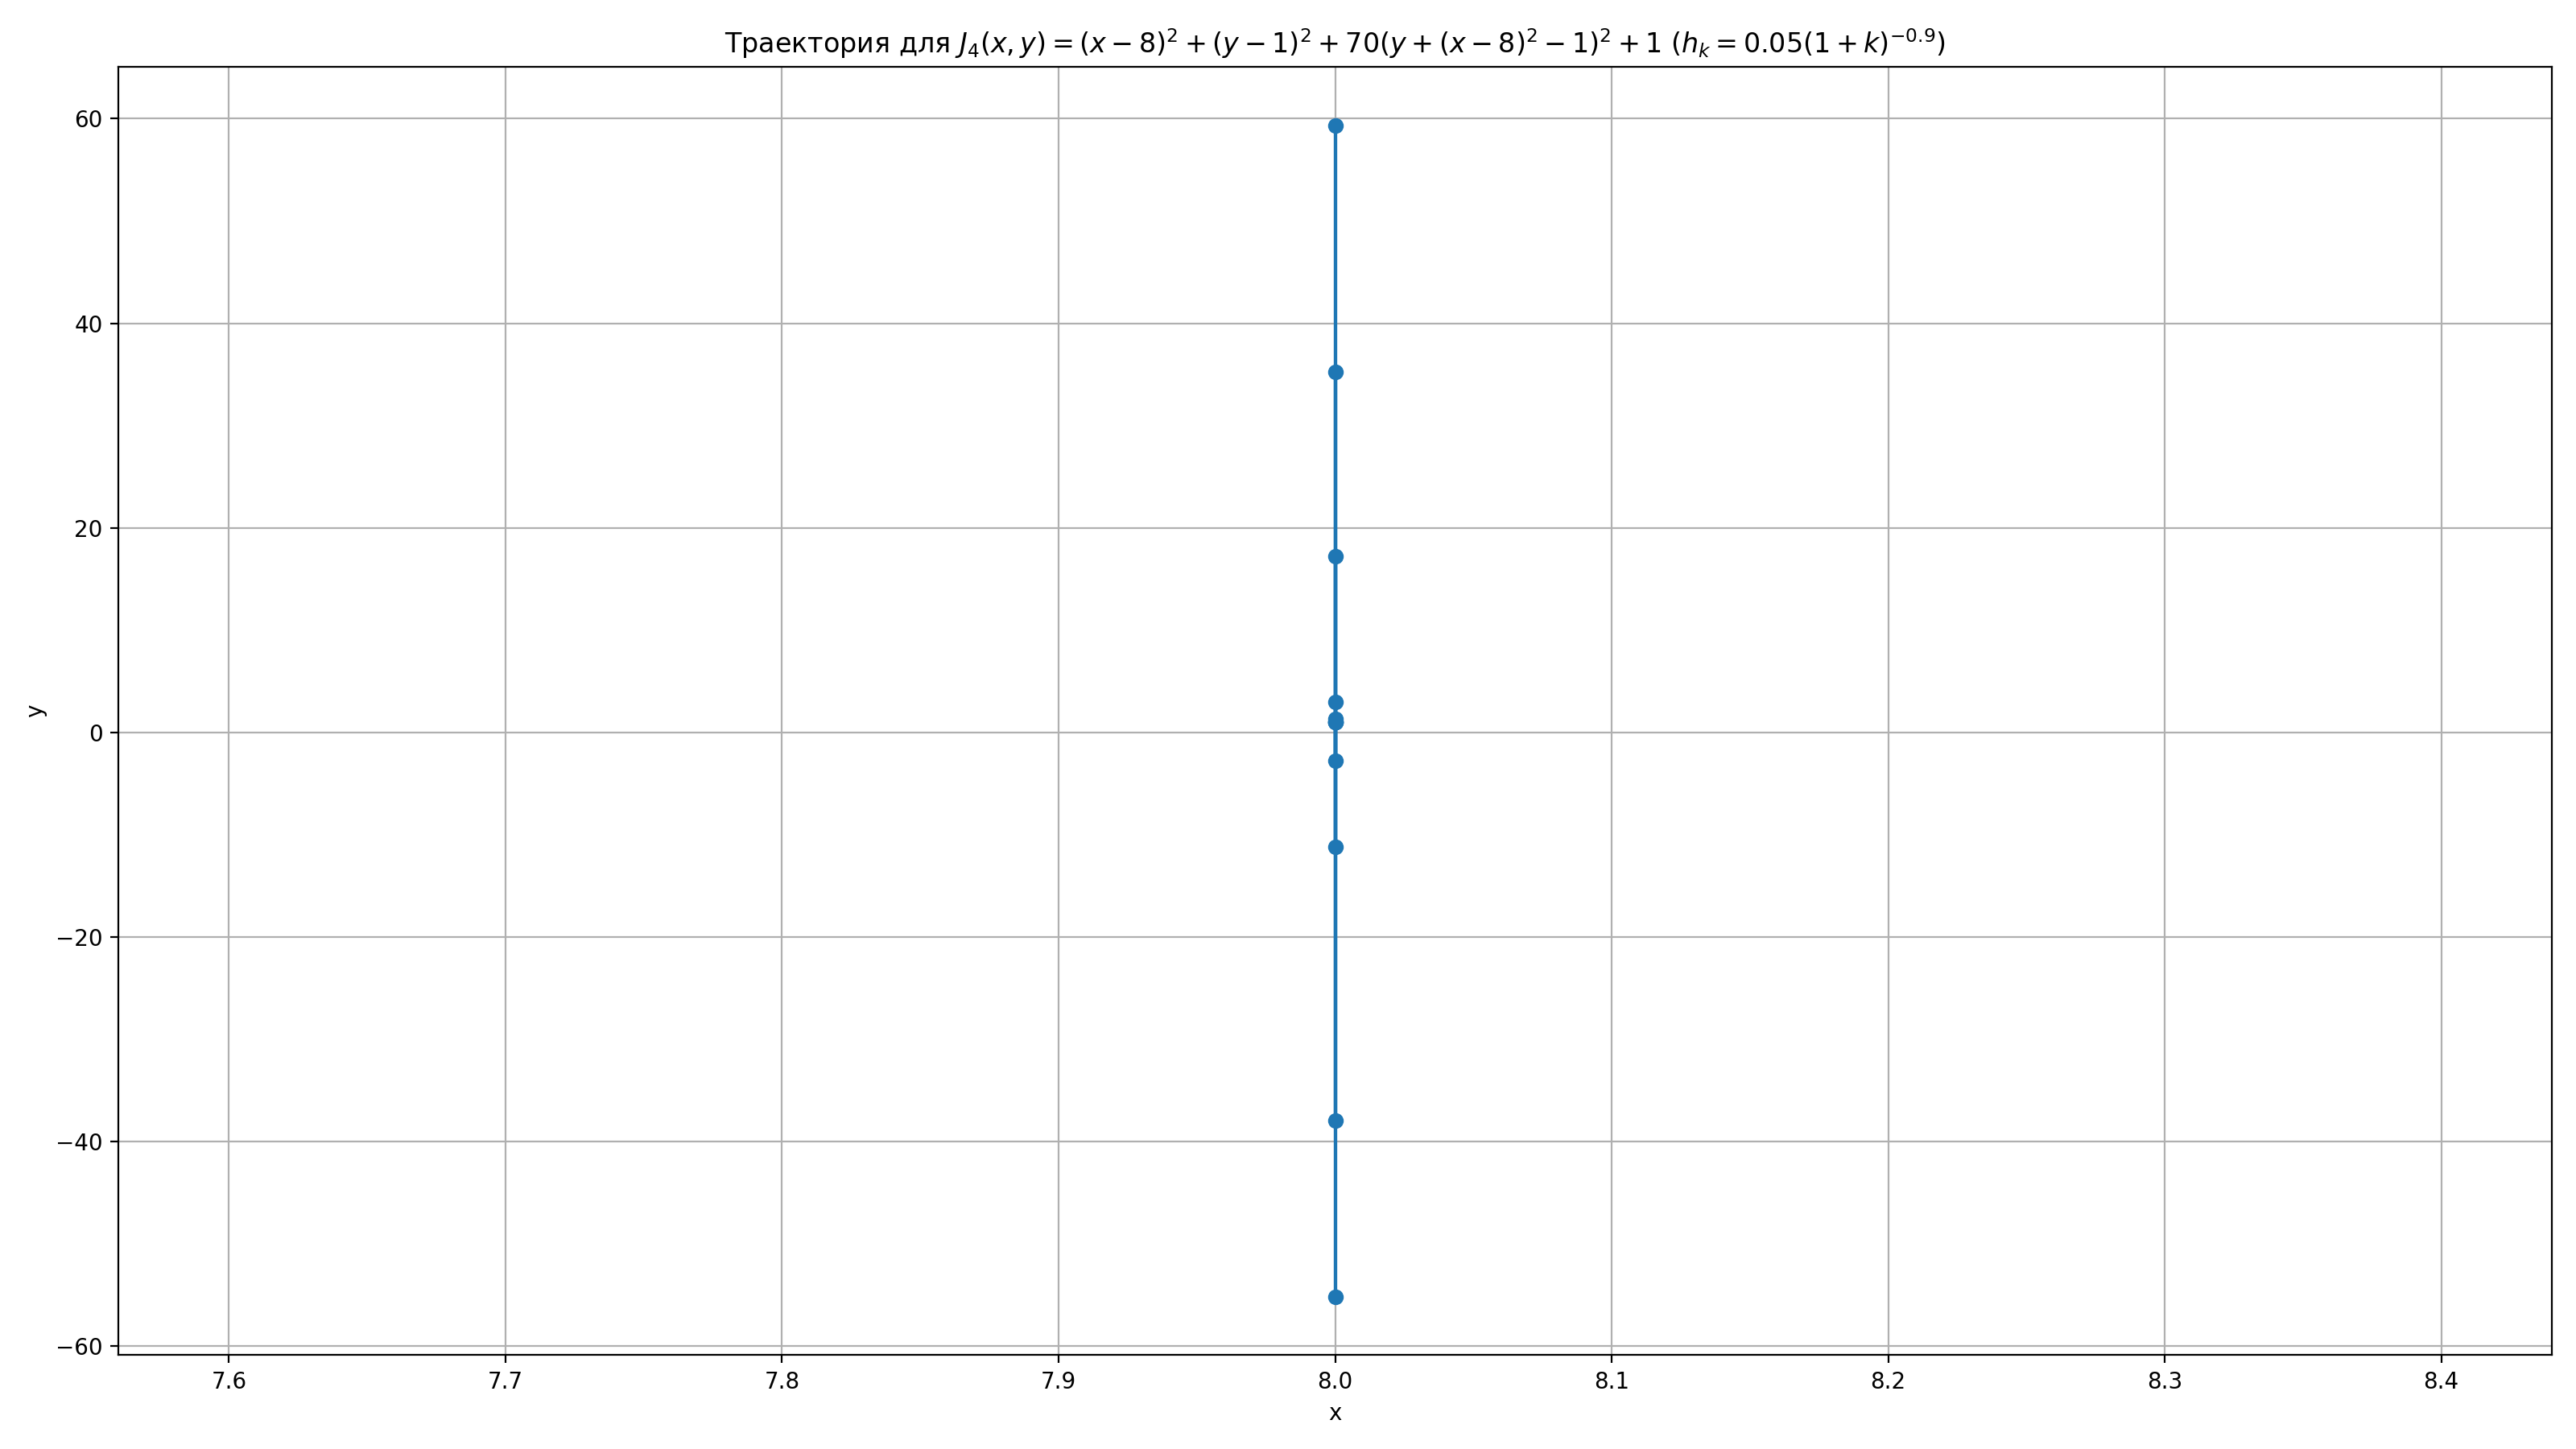

  Значение J(x_k):


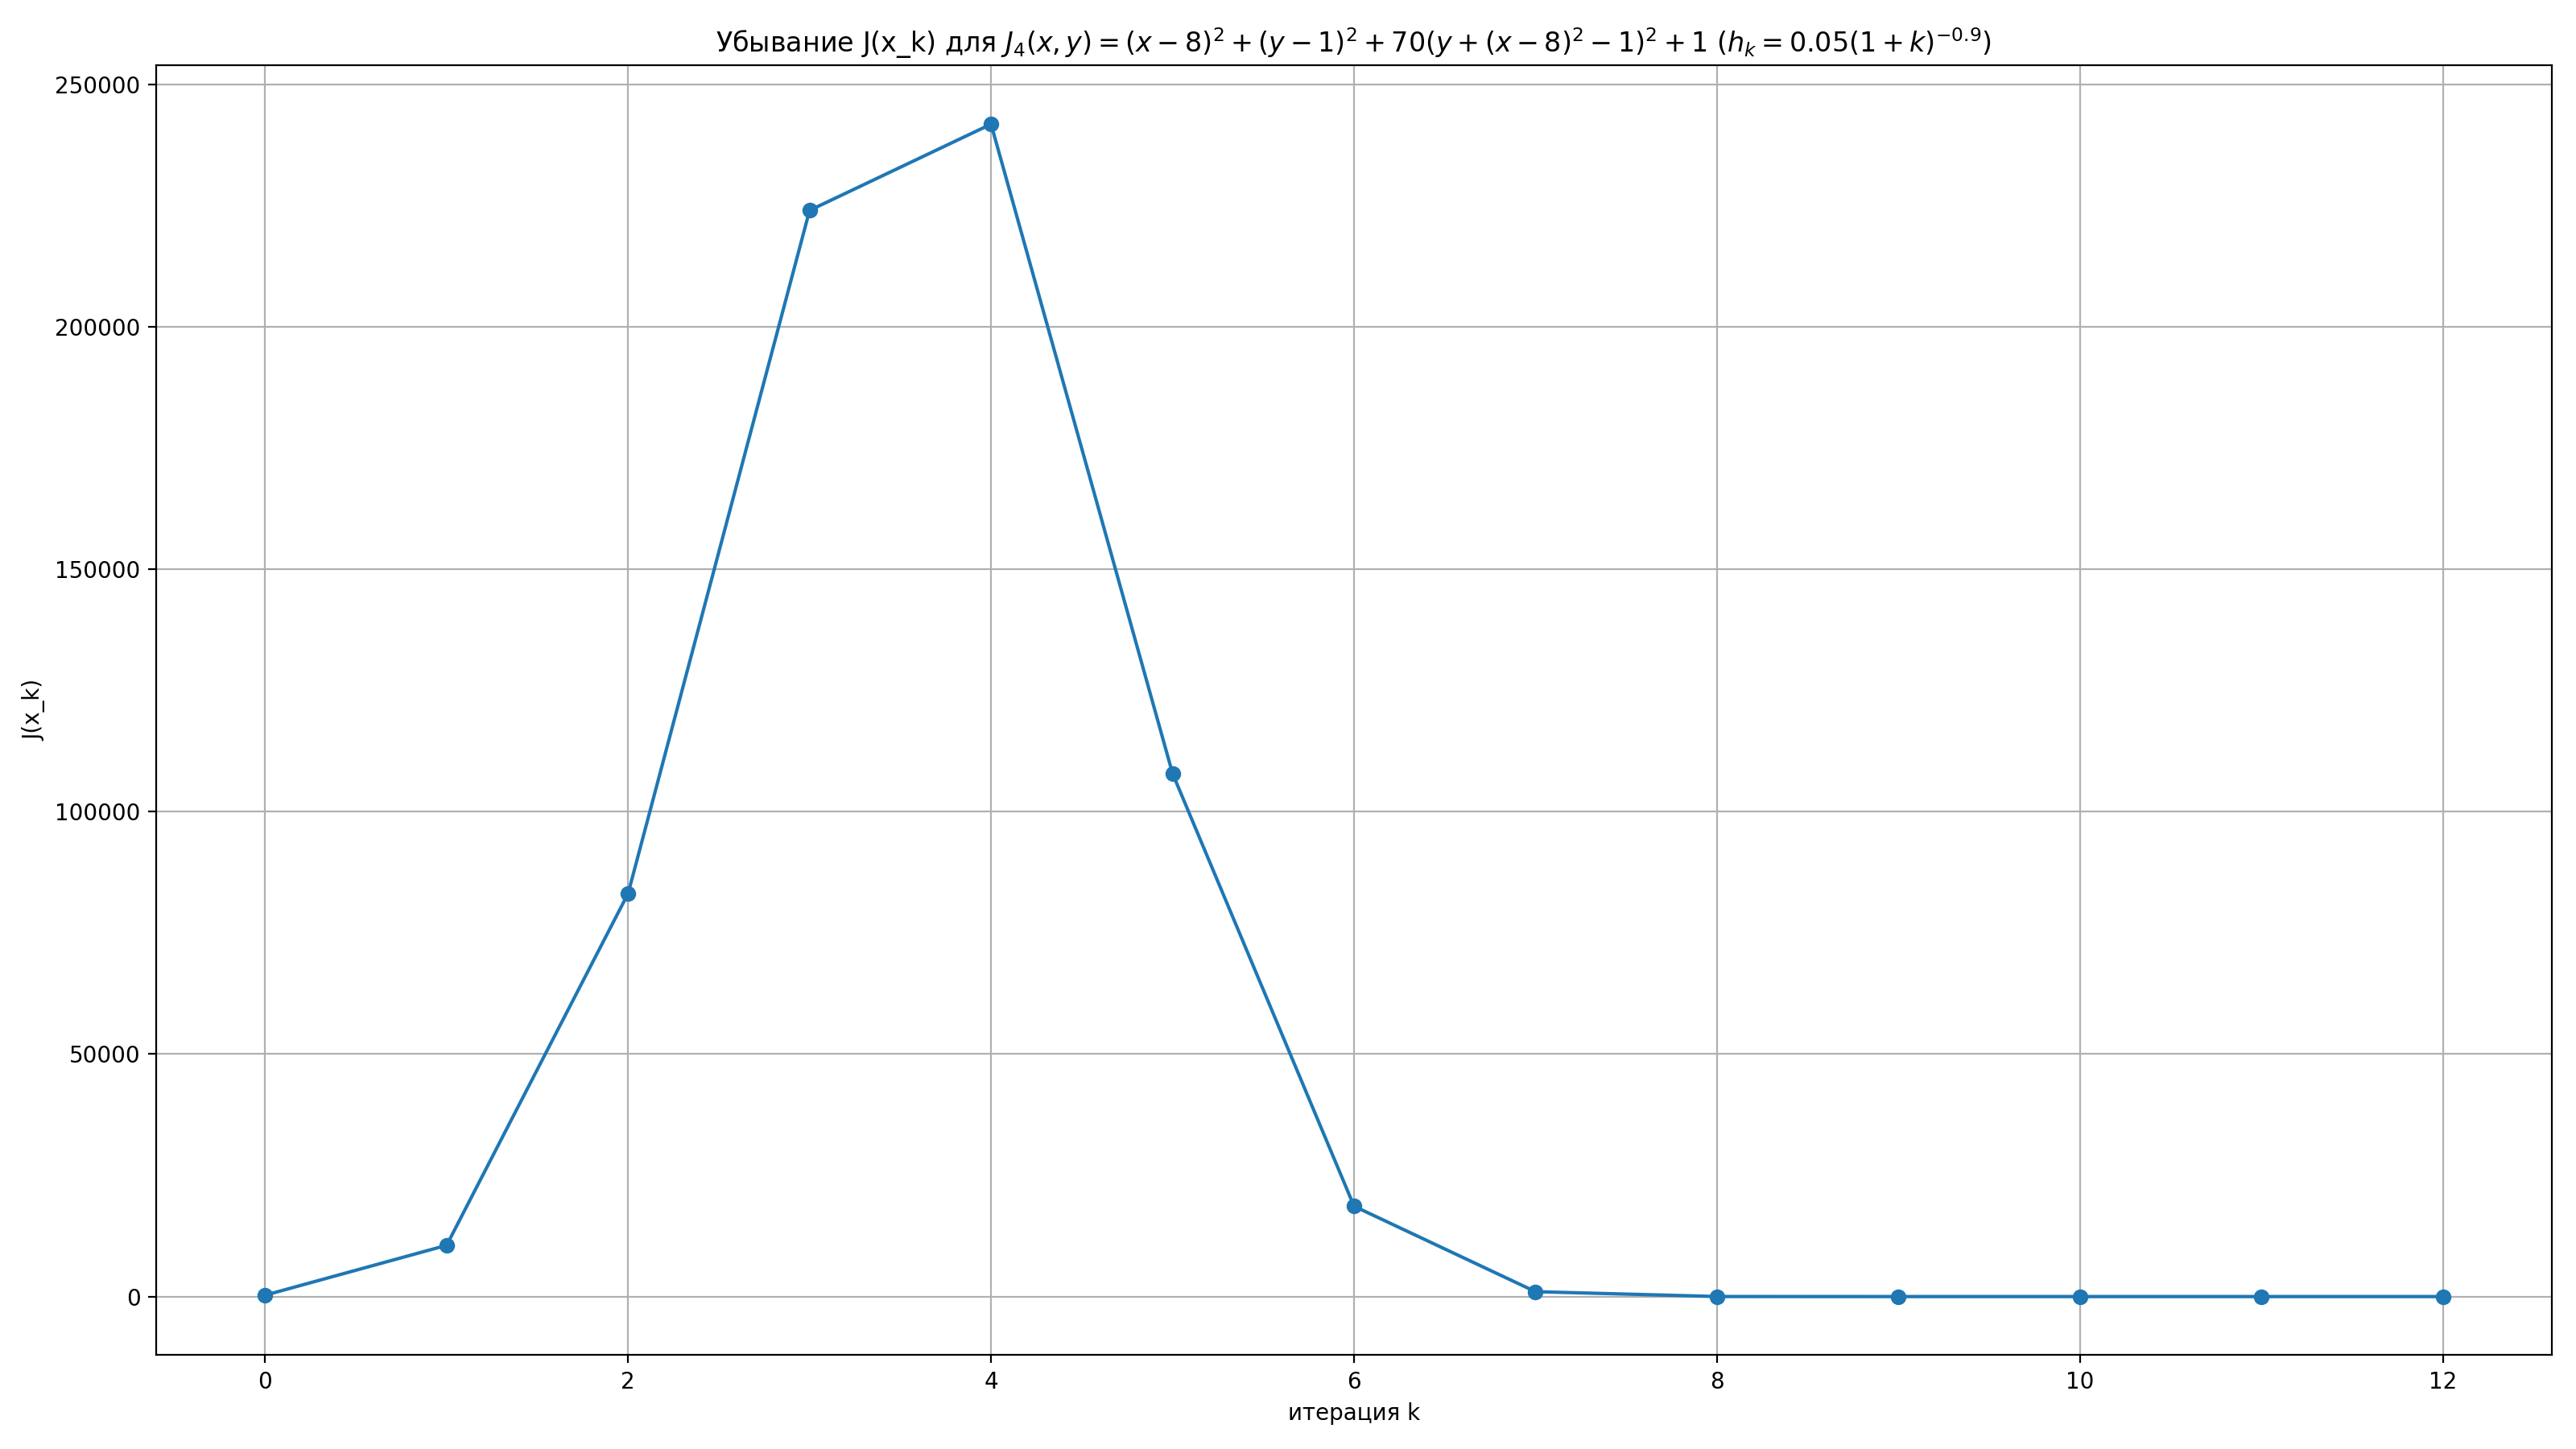

------------------------------------------------------------
Функция f1, режим шага: 1_over_k
  шаг: h_k = 0.5 / (k+1)
  x* = [0. 0.]
  J(x*) = 0.00000000
  число итераций: 2
  причина остановки: tol_x: ||x_(k+1)-x_k|| = 0.00e+00
  файлы графиков: f1_traj_1_over_k.png, f1_J_1_over_k.png
  Траектория:


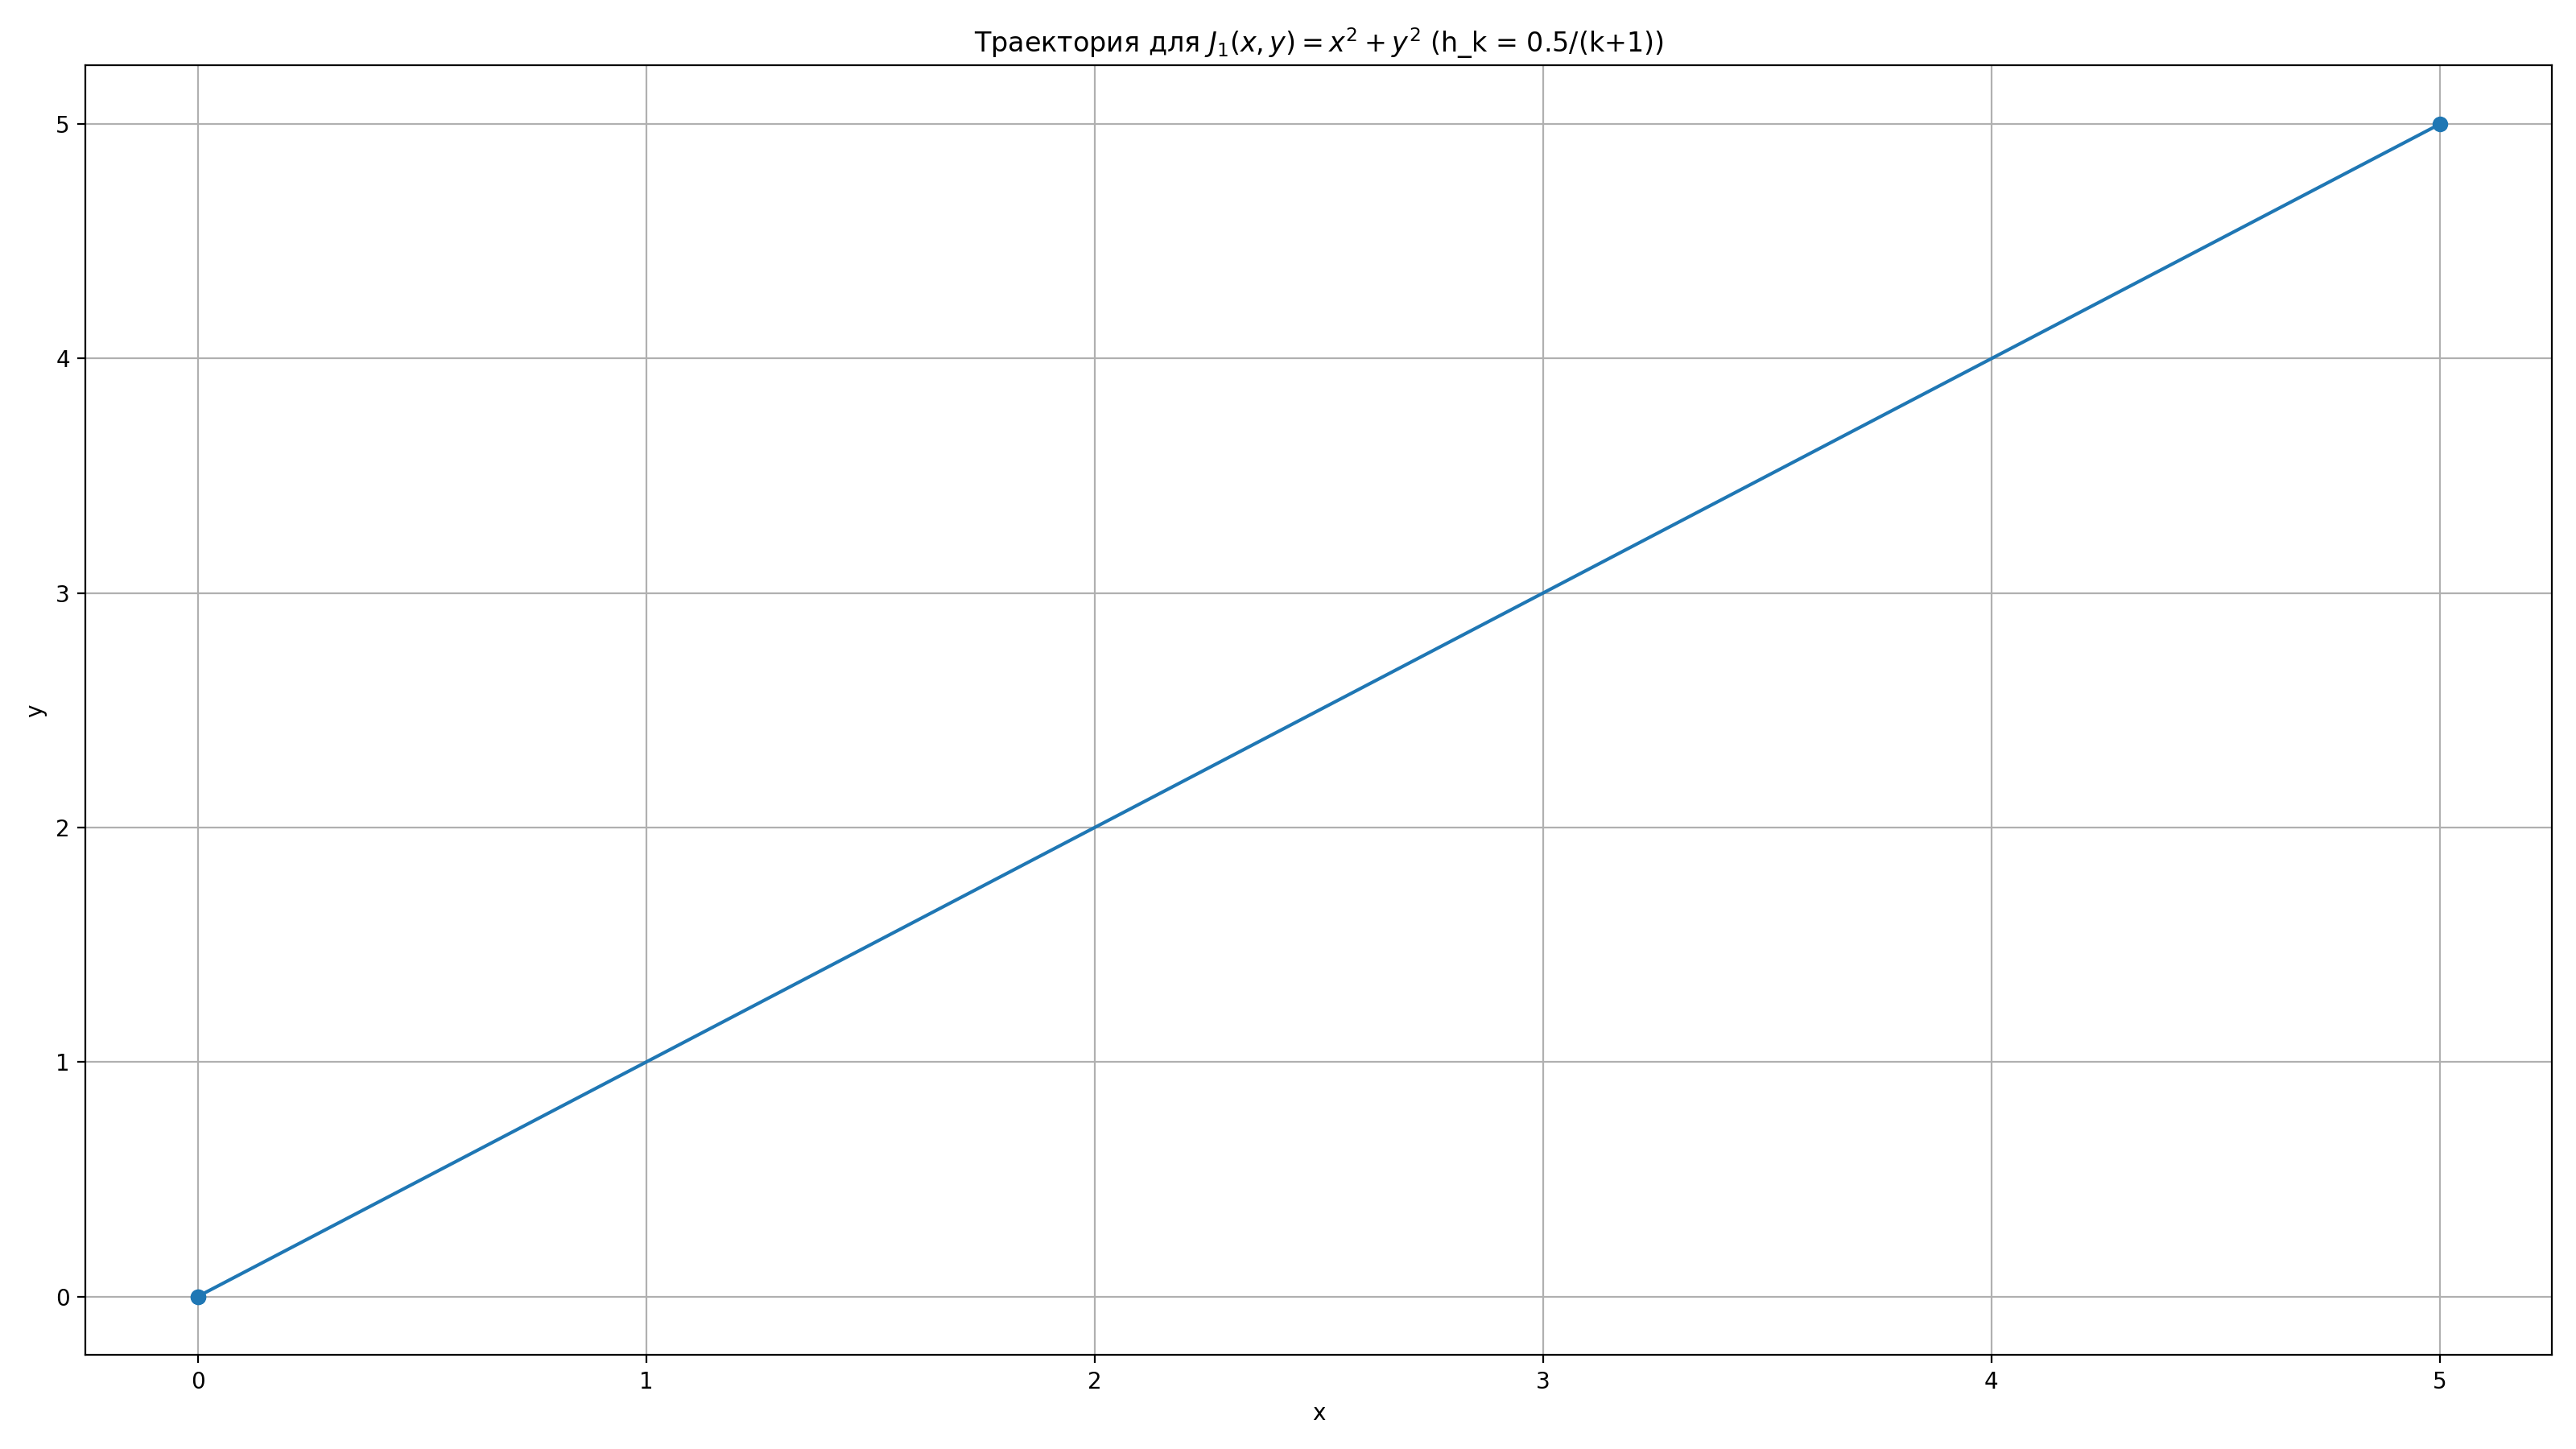

  Значение J(x_k):


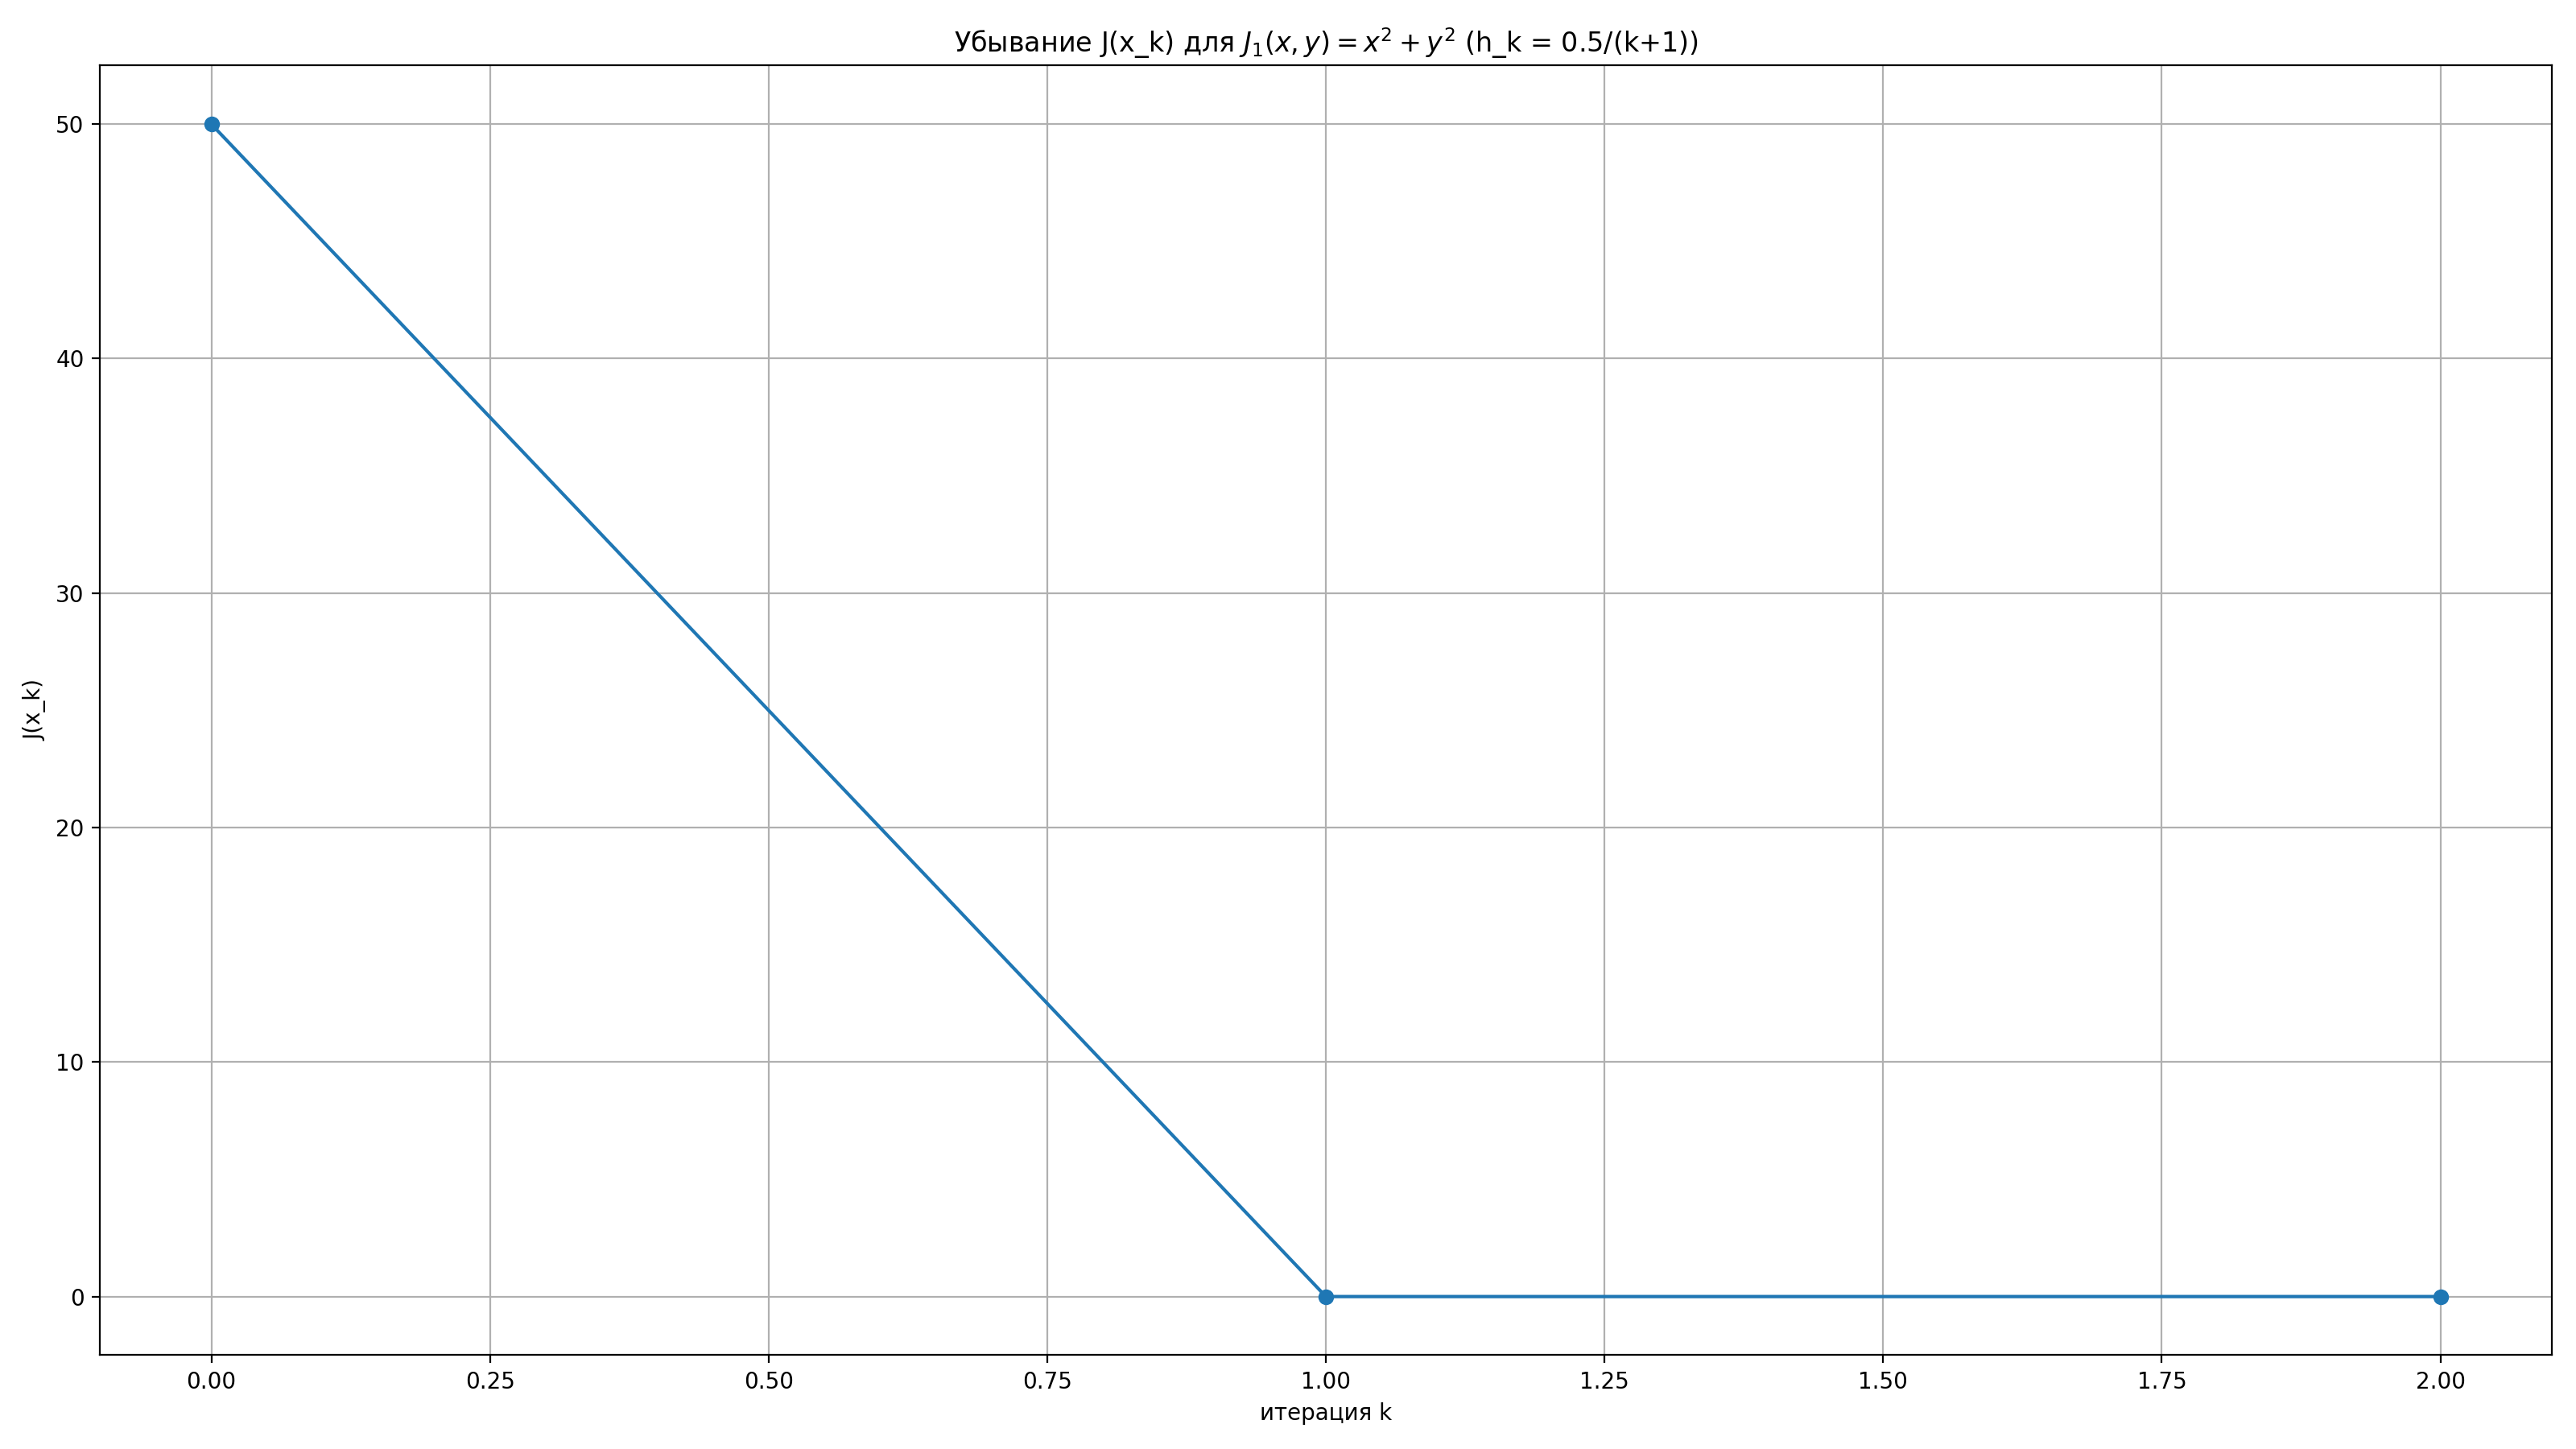

------------------------------------------------------------


In [18]:
from IPython.display import Image, display  # если ещё не импортировал

for (key, mode), info in results.items():
    print(f"Функция {key}, режим шага: {mode}")
    print(f"  шаг: {info['step_descr']}")
    print(f"  x* = {info['x_star']}")
    print(f"  J(x*) = {info['J_star']:.8f}")
    print(f"  число итераций: {info['iters']}")
    print(f"  причина остановки: {info['stop_reason']}")
    print(f"  файлы графиков: {info['traj_file']}, {info['J_file']}")
    
    print("  Траектория:")
    display(Image(filename=info["traj_file"]))
    print("  Значение J(x_k):")
    display(Image(filename=info["J_file"]))

    print("-" * 60)

In [25]:
def latex_escape_text(s: str) -> str:
    s = str(s)
    return s.replace("_", r"\_")


func_labels = {
    "f1": r"$J_1$",
    "f2": r"$J_2$",
    "f3": r"$J_3$",
    "f4": r"$J_4$",
}

rows = []

for (key, mode), info in results.items():
    x_star = info["x_star"]
    row = {
        "Функция": func_labels.get(key, key),
        "Режим шага": info["step_descr"],
        "Найденная точка $x^*$": f"({x_star[0]:.6f}, {x_star[1]:.6f})",
        "$J(x^*)$": f"{info['J_star']:.8f}",
        "Критерий остановки": latex_escape_text(info["stop_reason"]),
    }
    rows.append(row)

df_res = pd.DataFrame(rows)

# Показать в ноутбуке
df_res

,Функция,Режим шага,Найденная точка $x^*$,$J(x^*)$,Критерий остановки
0,$J_1$,постоянный шаг h = 0.2,"(0.000508, 0.000508)",0.00000052,tol\_f: |J\_(k+1)-J\_k| = 9.17e-07
1,$J_1$,$h_k = 0.5 (1 + k)^{-0.6}$,"(0.000000, 0.000000)",0.00000000,tol\_x: ||x\_(k+1)-x\_k|| = 0.00e+00
2,$J_2$,постоянный шаг h = 0.2,"(0.027314, 0.000000)",0.00002984,tol\_f: |J\_(k+1)-J\_k| = 9.78e-07
3,$J_2$,$h_k = 0.5 (1 + k)^{-0.6}$,"(0.234139, 0.000000)",0.00219284,tol\_f: |J\_(k+1)-J\_k| = 1.00e-06
4,$J_3$,постоянный шаг h = 0.01,"(1.000000, 1.004888)",1.00002389,tol\_f: |J\_(k+1)-J\_k| = 9.85e-07
5,$J_3$,$h_k = 0.5 (1 + k)^{-0.9}$,"(1.000000, 1.000000)",1.00000000,tol\_f: |J\_(k+1)-J\_k| = 1.90e-08
6,$J_4$,постоянный шаг h = 0.001,"(8.000000, 1.000175)",1.00000218,tol\_f: |J\_(k+1)-J\_k| = 7.82e-07
7,$J_4$,$h_k = 0.05 (1 + k)^{-0.9}$,"(8.000000, 1.000028)",1.00000005,tol\_f: |J\_(k+1)-J\_k| = 8.79e-07
8,$J_1$,h_k = 0.5 / (k+1),"(0.000000, 0.000000)",0.00000000,tol\_x: ||x\_(k+1)-x\_k|| = 0.00e+00


In [26]:
df_res.to_csv("gd_results.csv", index=False)
print("CSV сохранён в gd_results.csv")

CSV сохранён в gd_results.csv


In [27]:
latex_body = df_res.to_latex(
    index=False,
    escape=False,               # чтобы формулы не экранировались
    column_format="|c|c|c|c|c|"
)

table_tex = r"""\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{%
""" + latex_body + r"""
    }
    \caption{Итоговые точки минимума и значения функционала для разных режимов шага.}
    \label{tab:ravine_results}
\end{table}
"""

with open("gd_results_table.tex", "w", encoding="utf-8") as f:
    f.write(table_tex)

print("LaTeX-таблица сохранена в gd_results_table.tex")

LaTeX-таблица сохранена в gd_results_table.tex
